# codes

In [9]:
from train_nn import train_nn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_nn_cv(X, y, scaler_y,
                hidden_dims,
                activation='ReLU',
                lr=1e-3,
                weight_decay=0.0,
                epochs=50,
                batch_size=32,
                cv=5,
                random_state=42):
    """
    K-fold cross-validation with scatter plots and metrics on training and validation.
    Computes validation MSE (normalized), R², and Pearson correlation for both splits.
    At the end, prints lists of validation metrics (formatted to 4 decimal places)
    and their mean±std.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    fold_models    = []
    fold_val_loss  = []
    fold_val_r2    = []
    fold_val_corr  = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\n=== Fold {fold}/{cv} ===")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train on the training split
        model, train_loss_hist = train_nn(
            X_train, y_train,
            hidden_dims  = hidden_dims,
            activation   = activation,
            lr           = lr,
            weight_decay = weight_decay,
            epochs       = epochs,
            batch_size   = batch_size
        )

        model.eval()
        # ---- TRAINING METRICS & PLOT ----
        with torch.no_grad():
            pred_train_norm = model(torch.from_numpy(X_train).float()).cpu().numpy().ravel()
        true_train = scaler_y.inverse_transform(y_train.reshape(-1,1)).ravel()
        pred_train = scaler_y.inverse_transform(pred_train_norm.reshape(-1,1)).ravel()
        r2_train   = r2_score(true_train, pred_train)
        corr_train = np.corrcoef(true_train, pred_train)[0,1]
        print(f"Fold {fold} Training R²: {r2_train:.4f}, Pearson r: {corr_train:.4f}")

        plt.figure()
        plt.scatter(true_train, pred_train, alpha=0.6)
        mn, mx = true_train.min(), true_train.max()
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        plt.xlabel('True Output')
        plt.ylabel('Predicted Output')
        plt.title(f'Fold {fold} — Training True vs. Predicted')
        plt.tight_layout()
        plt.show()

        # ---- VALIDATION METRICS & PLOT ----
        with torch.no_grad():
            pred_val_tensor = model(torch.from_numpy(X_val).float()).cpu()
        y_val_tensor = torch.from_numpy(y_val).unsqueeze(1)
        val_mse_norm = nn.MSELoss()(pred_val_tensor, y_val_tensor).item()
        pred_val_norm = pred_val_tensor.numpy().ravel()
        true_val = scaler_y.inverse_transform(y_val.reshape(-1,1)).ravel()
        pred_val = scaler_y.inverse_transform(pred_val_norm.reshape(-1,1)).ravel()
        r2_val   = r2_score(true_val, pred_val)
        corr_val = np.corrcoef(true_val, pred_val)[0,1]

        print(f"Fold {fold} Validation MSE (norm): {val_mse_norm:.4f}")
        print(f"Fold {fold} Validation R²: {r2_val:.4f}, Pearson r: {corr_val:.4f}")

        plt.figure()
        plt.scatter(true_val, pred_val, alpha=0.6)
        mn, mx = true_val.min(), true_val.max()
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        plt.xlabel('True Output')
        plt.ylabel('Predicted Output')
        plt.title(f'Fold {fold} — Validation True vs. Predicted')
        plt.tight_layout()
        plt.show()

        # collect validation metrics
        fold_models.append(model)
        fold_val_loss.append(val_mse_norm)
        fold_val_r2.append(r2_val)
        fold_val_corr.append(corr_val)

    # after all folds, summarize
    mean_mse = np.mean(fold_val_loss)
    std_mse  = np.std(fold_val_loss)
    mean_r2  = np.mean(fold_val_r2)
    std_r2   = np.std(fold_val_r2)
    mean_corr = np.mean(fold_val_corr)
    std_corr  = np.std(fold_val_corr)

    print("\n=== Validation MSE per fold ===")
    print([f"{v:.4f}" for v in fold_val_loss])
    print(f"Mean MSE (norm): {mean_mse:.4f} ± {std_mse:.4f}")

    print("\n=== Validation R² per fold ===")
    print([f"{v:.4f}" for v in fold_val_r2])
    print(f"Mean R²: {mean_r2:.4f} ± {std_r2:.4f}")

    print("\n=== Validation Pearson r per fold ===")
    print([f"{v:.4f}" for v in fold_val_corr])
    print(f"Mean Pearson r: {mean_corr:.4f} ± {std_corr:.4f}")

    return fold_models, fold_val_loss


# NO Removal of the Inputs

In [10]:
from data_preprocessing import preprocess_data

use_mask = [True] * 18
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/training_validation.csv'
X, y, quality, scaler_X, scaler_y = preprocess_data(csv_path, use_mask)


import pickle
# 3) Save scalers with pickle
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)


# [3, 3] Relu


=== Fold 1/7 ===
Epoch   1/250  MSE=1.1773
Epoch  10/250  MSE=0.5148
Epoch  20/250  MSE=0.1875
Epoch  30/250  MSE=0.1181
Epoch  40/250  MSE=0.0866
Epoch  50/250  MSE=0.0643
Epoch  60/250  MSE=0.0525
Epoch  70/250  MSE=0.0437
Epoch  80/250  MSE=0.0378
Epoch  90/250  MSE=0.0387
Epoch 100/250  MSE=0.0329
Epoch 110/250  MSE=0.0334
Epoch 120/250  MSE=0.0310
Epoch 130/250  MSE=0.0288
Epoch 140/250  MSE=0.0278
Epoch 150/250  MSE=0.0296
Epoch 160/250  MSE=0.0256
Epoch 170/250  MSE=0.0224
Epoch 180/250  MSE=0.0211
Epoch 190/250  MSE=0.0203
Epoch 200/250  MSE=0.0207
Epoch 210/250  MSE=0.0192
Epoch 220/250  MSE=0.0186
Epoch 230/250  MSE=0.0184
Epoch 240/250  MSE=0.0198
Epoch 250/250  MSE=0.0155


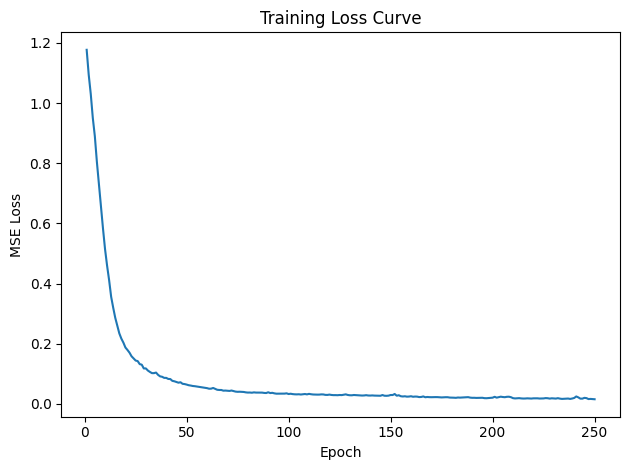

Fold 1 Training R²: 0.9872, Pearson r: 0.9936


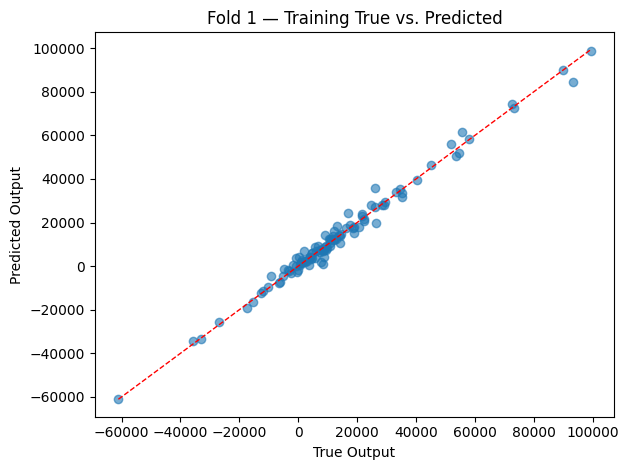

Fold 1 Validation MSE (norm): 0.2032
Fold 1 Validation R²: -0.0160, Pearson r: 0.6823


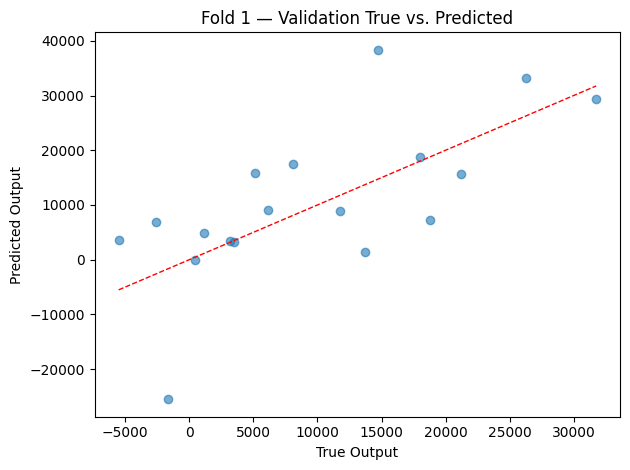


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9172
Epoch  10/250  MSE=0.8394
Epoch  20/250  MSE=0.6764
Epoch  30/250  MSE=0.5057
Epoch  40/250  MSE=0.3706
Epoch  50/250  MSE=0.2940
Epoch  60/250  MSE=0.2482
Epoch  70/250  MSE=0.2002
Epoch  80/250  MSE=0.1706
Epoch  90/250  MSE=0.1548
Epoch 100/250  MSE=0.1409
Epoch 110/250  MSE=0.1330
Epoch 120/250  MSE=0.1334
Epoch 130/250  MSE=0.1152
Epoch 140/250  MSE=0.1054
Epoch 150/250  MSE=0.1007
Epoch 160/250  MSE=0.0930
Epoch 170/250  MSE=0.0896
Epoch 180/250  MSE=0.0865
Epoch 190/250  MSE=0.0836
Epoch 200/250  MSE=0.0806
Epoch 210/250  MSE=0.0772
Epoch 220/250  MSE=0.0769
Epoch 230/250  MSE=0.0738
Epoch 240/250  MSE=0.0738
Epoch 250/250  MSE=0.0873


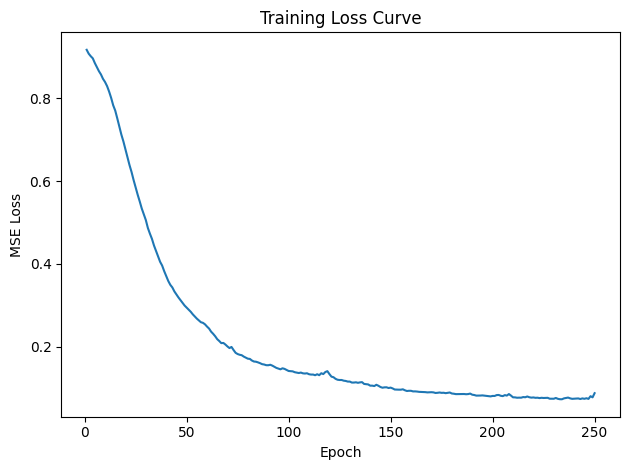

Fold 2 Training R²: 0.9100, Pearson r: 0.9559


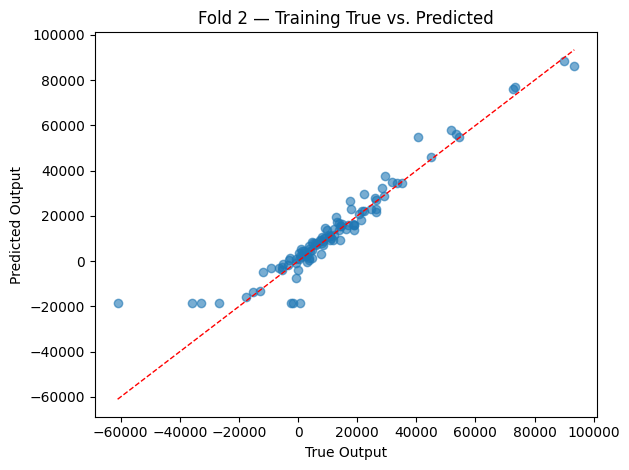

Fold 2 Validation MSE (norm): 0.2578
Fold 2 Validation R²: 0.8139, Pearson r: 0.9272


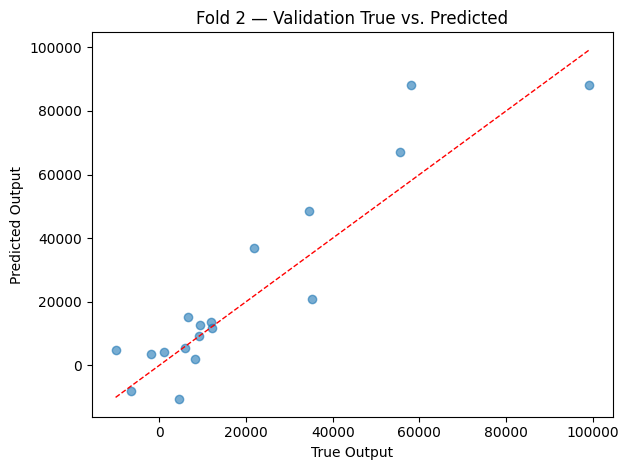


=== Fold 3/7 ===
Epoch   1/250  MSE=1.5207
Epoch  10/250  MSE=1.0098
Epoch  20/250  MSE=0.7163
Epoch  30/250  MSE=0.2183
Epoch  40/250  MSE=0.1414
Epoch  50/250  MSE=0.1224
Epoch  60/250  MSE=0.1141
Epoch  70/250  MSE=0.1044
Epoch  80/250  MSE=0.0943
Epoch  90/250  MSE=0.0887
Epoch 100/250  MSE=0.0846
Epoch 110/250  MSE=0.0765
Epoch 120/250  MSE=0.0704
Epoch 130/250  MSE=0.0651
Epoch 140/250  MSE=0.0599
Epoch 150/250  MSE=0.0566
Epoch 160/250  MSE=0.0510
Epoch 170/250  MSE=0.0461
Epoch 180/250  MSE=0.0446
Epoch 190/250  MSE=0.0419
Epoch 200/250  MSE=0.0392
Epoch 210/250  MSE=0.0362
Epoch 220/250  MSE=0.0327
Epoch 230/250  MSE=0.0333
Epoch 240/250  MSE=0.0312
Epoch 250/250  MSE=0.0300


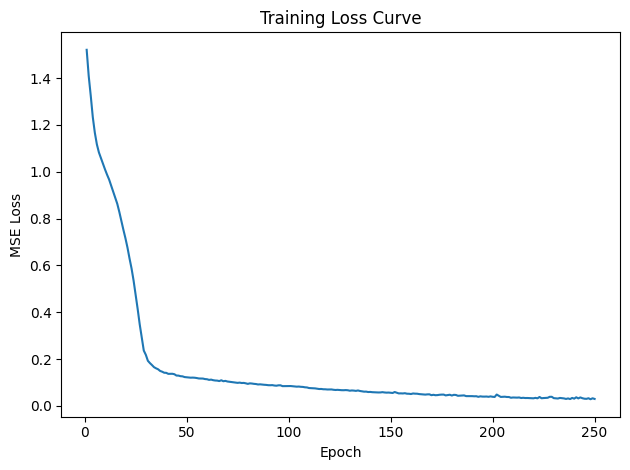

Fold 3 Training R²: 0.9736, Pearson r: 0.9871


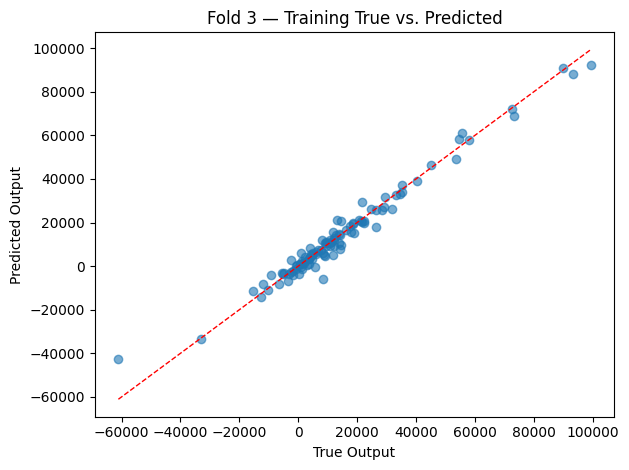

Fold 3 Validation MSE (norm): 0.3368
Fold 3 Validation R²: 0.5353, Pearson r: 0.8580


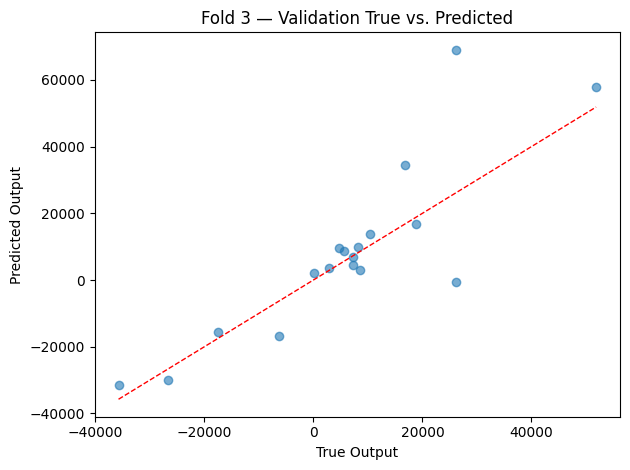


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8242
Epoch  10/250  MSE=0.8070
Epoch  20/250  MSE=0.8022
Epoch  30/250  MSE=0.8017
Epoch  40/250  MSE=0.8012
Epoch  50/250  MSE=0.8014
Epoch  60/250  MSE=0.8010
Epoch  70/250  MSE=0.8013
Epoch  80/250  MSE=0.8009
Epoch  90/250  MSE=0.8011
Epoch 100/250  MSE=0.8010
Epoch 110/250  MSE=0.8011
Epoch 120/250  MSE=0.8009
Epoch 130/250  MSE=0.8010
Epoch 140/250  MSE=0.8012
Epoch 150/250  MSE=0.8012
Epoch 160/250  MSE=0.8009
Epoch 170/250  MSE=0.8012
Epoch 180/250  MSE=0.8012
Epoch 190/250  MSE=0.8012
Epoch 200/250  MSE=0.8015
Epoch 210/250  MSE=0.8012
Epoch 220/250  MSE=0.8010
Epoch 230/250  MSE=0.8009
Epoch 240/250  MSE=0.8015
Epoch 250/250  MSE=0.8011


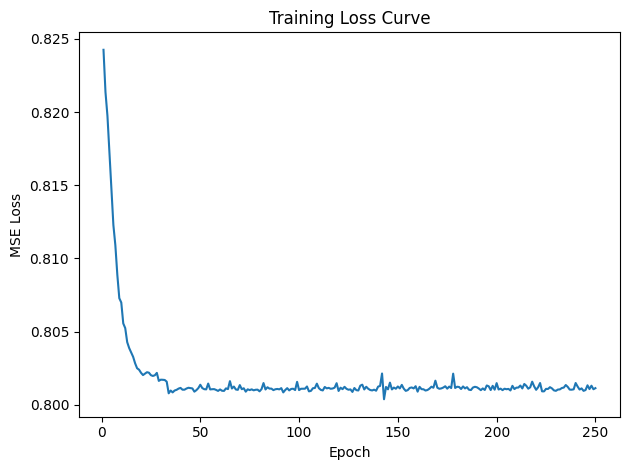

Fold 4 Training R²: -0.0001, Pearson r: nan


/home/kamiar/chevron/Acid-neural-net/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kamiar/chevron/Acid-neural-net/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


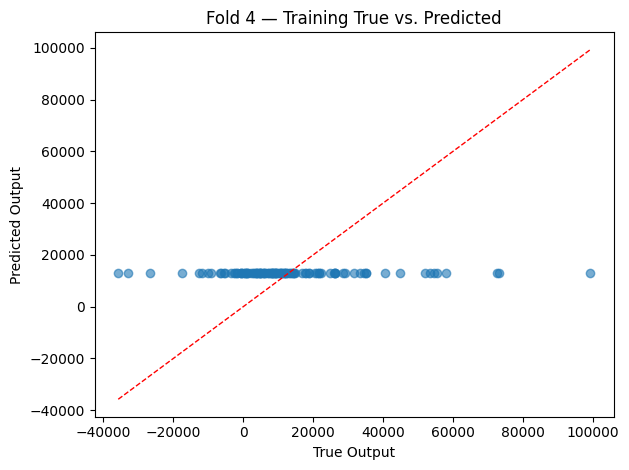

/home/kamiar/chevron/Acid-neural-net/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kamiar/chevron/Acid-neural-net/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 4 Validation MSE (norm): 2.1723
Fold 4 Validation R²: -0.0000, Pearson r: nan


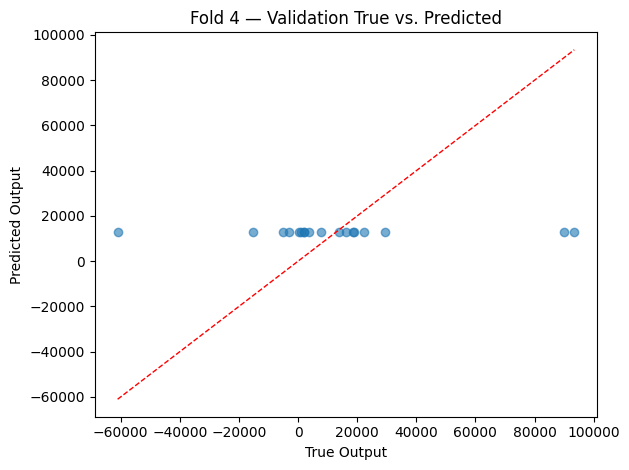


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0364
Epoch  10/250  MSE=0.8066
Epoch  20/250  MSE=0.3422
Epoch  30/250  MSE=0.1928
Epoch  40/250  MSE=0.1595
Epoch  50/250  MSE=0.1373
Epoch  60/250  MSE=0.1168
Epoch  70/250  MSE=0.1028
Epoch  80/250  MSE=0.0932
Epoch  90/250  MSE=0.0845
Epoch 100/250  MSE=0.0783
Epoch 110/250  MSE=0.0722
Epoch 120/250  MSE=0.0686
Epoch 130/250  MSE=0.0655
Epoch 140/250  MSE=0.0617
Epoch 150/250  MSE=0.0594
Epoch 160/250  MSE=0.0673
Epoch 170/250  MSE=0.0568
Epoch 180/250  MSE=0.0566
Epoch 190/250  MSE=0.0586
Epoch 200/250  MSE=0.0569
Epoch 210/250  MSE=0.0543
Epoch 220/250  MSE=0.0544
Epoch 230/250  MSE=0.0543
Epoch 240/250  MSE=0.0530
Epoch 250/250  MSE=0.0519


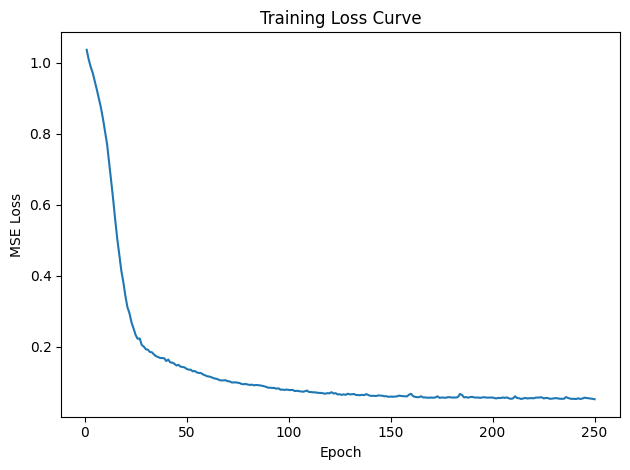

Fold 5 Training R²: 0.9510, Pearson r: 0.9752


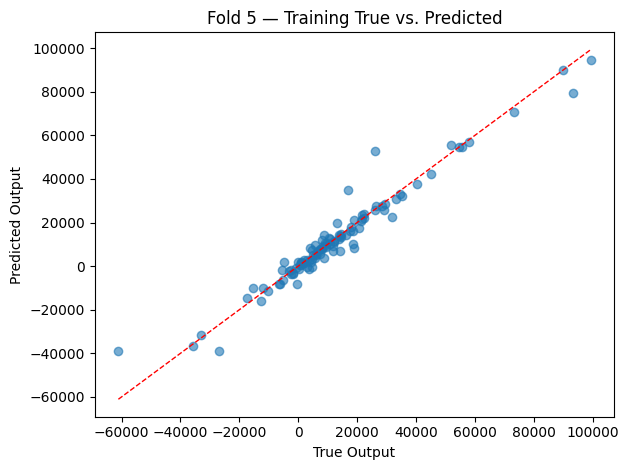

Fold 5 Validation MSE (norm): 0.2485
Fold 5 Validation R²: 0.6835, Pearson r: 0.8871


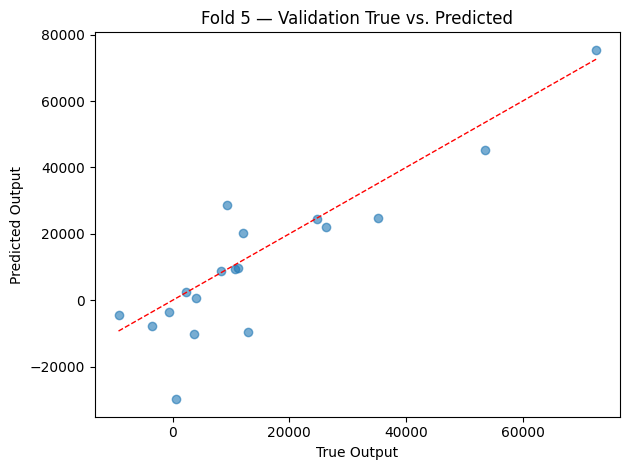


=== Fold 6/7 ===
Epoch   1/250  MSE=1.2003
Epoch  10/250  MSE=0.6299
Epoch  20/250  MSE=0.2051
Epoch  30/250  MSE=0.1241
Epoch  40/250  MSE=0.0902
Epoch  50/250  MSE=0.0764
Epoch  60/250  MSE=0.0613
Epoch  70/250  MSE=0.0552
Epoch  80/250  MSE=0.0520
Epoch  90/250  MSE=0.0466
Epoch 100/250  MSE=0.0447
Epoch 110/250  MSE=0.0448
Epoch 120/250  MSE=0.0409
Epoch 130/250  MSE=0.0407
Epoch 140/250  MSE=0.0355
Epoch 150/250  MSE=0.0297
Epoch 160/250  MSE=0.0272
Epoch 170/250  MSE=0.0281
Epoch 180/250  MSE=0.0276
Epoch 190/250  MSE=0.0250
Epoch 200/250  MSE=0.0238
Epoch 210/250  MSE=0.0238
Epoch 220/250  MSE=0.0222
Epoch 230/250  MSE=0.0225
Epoch 240/250  MSE=0.0223
Epoch 250/250  MSE=0.0215


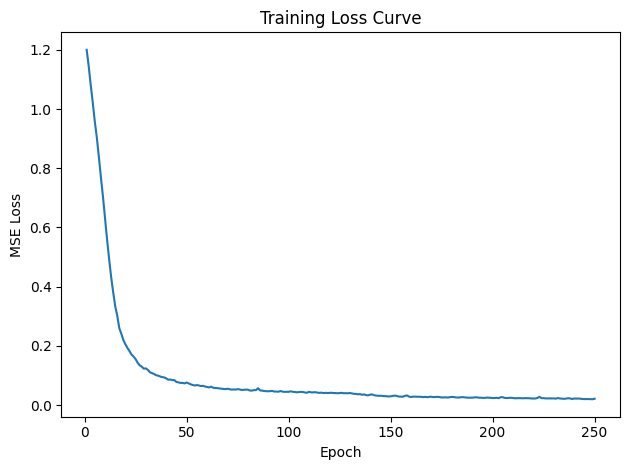

Fold 6 Training R²: 0.9804, Pearson r: 0.9905


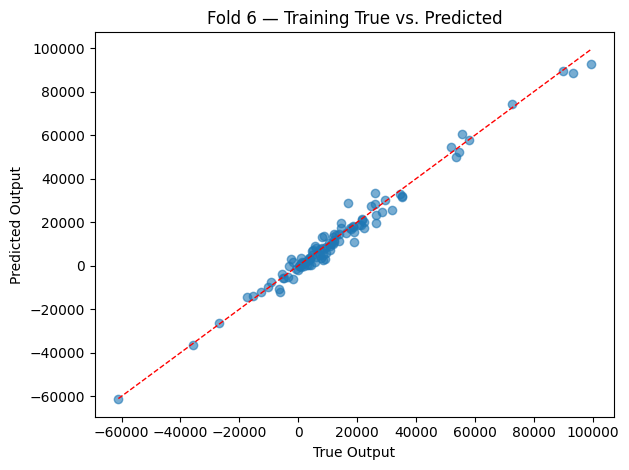

Fold 6 Validation MSE (norm): 0.7332
Fold 6 Validation R²: 0.3140, Pearson r: 0.6543


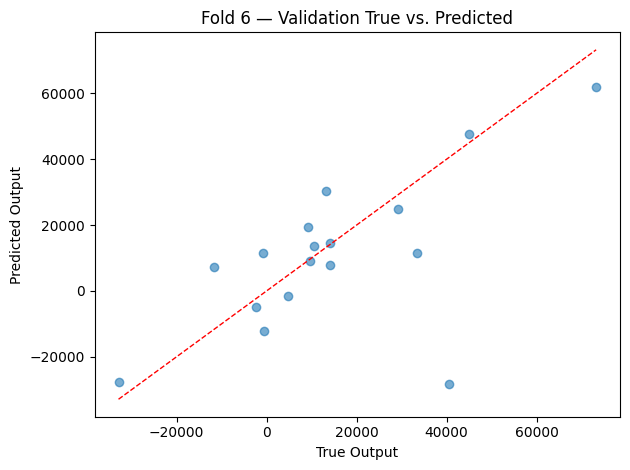


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1887
Epoch  10/250  MSE=0.9871
Epoch  20/250  MSE=0.6250
Epoch  30/250  MSE=0.4148
Epoch  40/250  MSE=0.2944
Epoch  50/250  MSE=0.2229
Epoch  60/250  MSE=0.1496
Epoch  70/250  MSE=0.1090
Epoch  80/250  MSE=0.0808
Epoch  90/250  MSE=0.0627
Epoch 100/250  MSE=0.0533
Epoch 110/250  MSE=0.0491
Epoch 120/250  MSE=0.0391
Epoch 130/250  MSE=0.0342
Epoch 140/250  MSE=0.0348
Epoch 150/250  MSE=0.0269
Epoch 160/250  MSE=0.0273
Epoch 170/250  MSE=0.0298
Epoch 180/250  MSE=0.0234
Epoch 190/250  MSE=0.0243
Epoch 200/250  MSE=0.0261
Epoch 210/250  MSE=0.0226
Epoch 220/250  MSE=0.0220
Epoch 230/250  MSE=0.0233
Epoch 240/250  MSE=0.0216
Epoch 250/250  MSE=0.0235


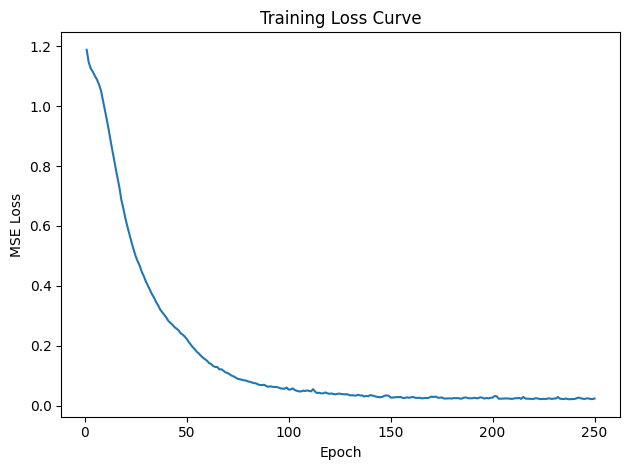

Fold 7 Training R²: 0.9817, Pearson r: 0.9909


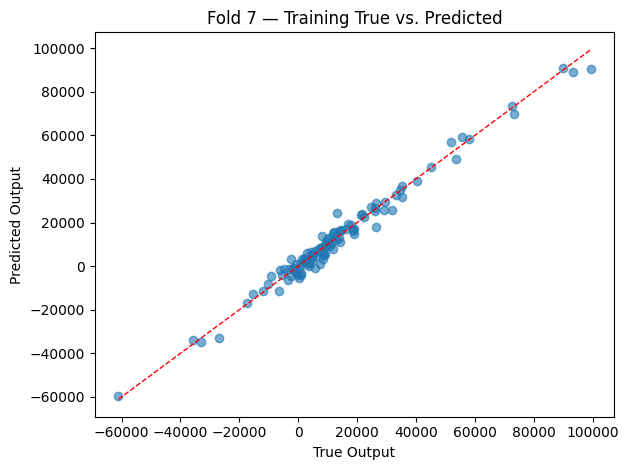

Fold 7 Validation MSE (norm): 0.2586
Fold 7 Validation R²: 0.3837, Pearson r: 0.7651


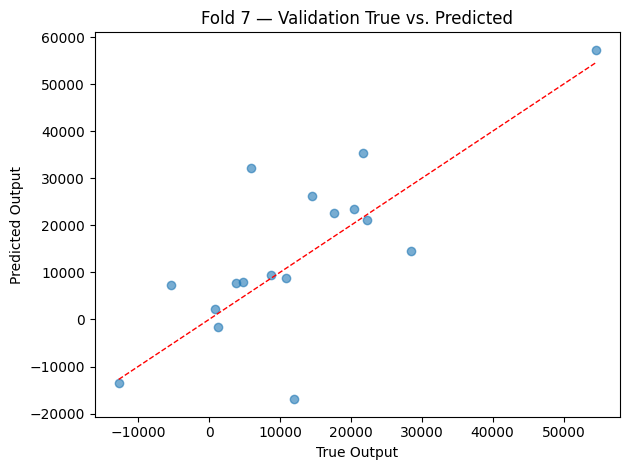


=== Validation MSE per fold ===
['0.2032', '0.2578', '0.3368', '2.1723', '0.2485', '0.7332', '0.2586']
Mean MSE (norm): 0.6015 ± 0.6627

=== Validation R² per fold ===
['-0.0160', '0.8139', '0.5353', '-0.0000', '0.6835', '0.3140', '0.3837']
Mean R²: 0.3878 ± 0.2951

=== Validation Pearson r per fold ===
['0.6823', '0.9272', '0.8580', 'nan', '0.8871', '0.6543', '0.7651']
Mean Pearson r: nan ± nan


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [11]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")
'''
'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [4,4] Relu



=== Fold 1/7 ===
Epoch   1/250  MSE=1.1200
Epoch  10/250  MSE=0.8778
Epoch  20/250  MSE=0.2141
Epoch  30/250  MSE=0.1301
Epoch  40/250  MSE=0.1058
Epoch  50/250  MSE=0.0780
Epoch  60/250  MSE=0.0656
Epoch  70/250  MSE=0.0527
Epoch  80/250  MSE=0.0441
Epoch  90/250  MSE=0.0392
Epoch 100/250  MSE=0.0404
Epoch 110/250  MSE=0.0320
Epoch 120/250  MSE=0.0294
Epoch 130/250  MSE=0.0327
Epoch 140/250  MSE=0.0265
Epoch 150/250  MSE=0.0251
Epoch 160/250  MSE=0.0228
Epoch 170/250  MSE=0.0218
Epoch 180/250  MSE=0.0209
Epoch 190/250  MSE=0.0199
Epoch 200/250  MSE=0.0194
Epoch 210/250  MSE=0.0203
Epoch 220/250  MSE=0.0191
Epoch 230/250  MSE=0.0211
Epoch 240/250  MSE=0.0183
Epoch 250/250  MSE=0.0191


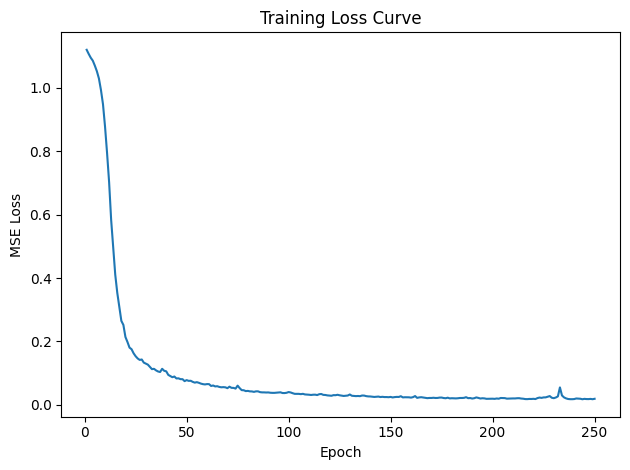

Fold 1 Training R²: 0.9855, Pearson r: 0.9927


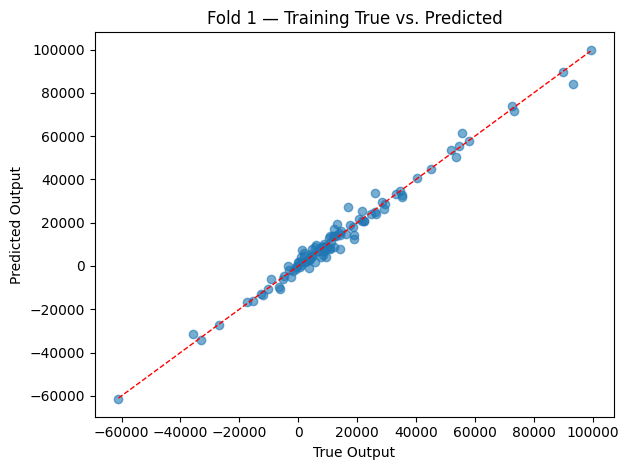

Fold 1 Validation MSE (norm): 0.1522
Fold 1 Validation R²: 0.2391, Pearson r: 0.6882


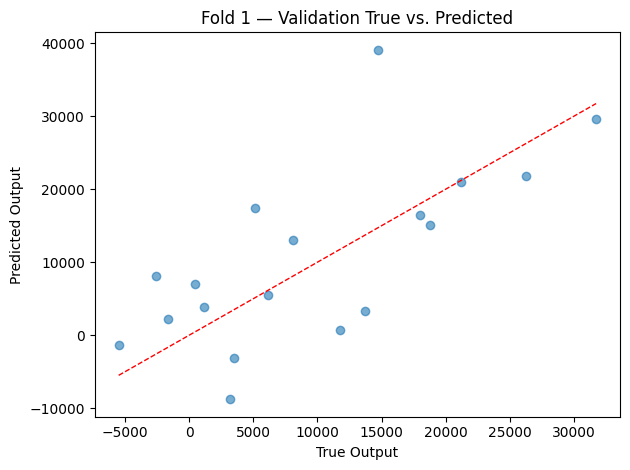


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9864
Epoch  10/250  MSE=0.7054
Epoch  20/250  MSE=0.2139
Epoch  30/250  MSE=0.1339
Epoch  40/250  MSE=0.0930
Epoch  50/250  MSE=0.0709
Epoch  60/250  MSE=0.0580
Epoch  70/250  MSE=0.0546
Epoch  80/250  MSE=0.0473
Epoch  90/250  MSE=0.0416
Epoch 100/250  MSE=0.0386
Epoch 110/250  MSE=0.0389
Epoch 120/250  MSE=0.0327
Epoch 130/250  MSE=0.0346
Epoch 140/250  MSE=0.0304
Epoch 150/250  MSE=0.0324
Epoch 160/250  MSE=0.0266
Epoch 170/250  MSE=0.0299
Epoch 180/250  MSE=0.0285
Epoch 190/250  MSE=0.0263
Epoch 200/250  MSE=0.0233
Epoch 210/250  MSE=0.0227
Epoch 220/250  MSE=0.0216
Epoch 230/250  MSE=0.0200
Epoch 240/250  MSE=0.0194
Epoch 250/250  MSE=0.0188


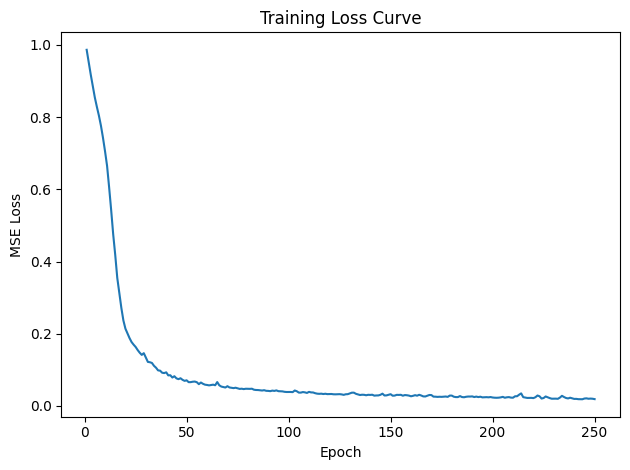

Fold 2 Training R²: 0.9810, Pearson r: 0.9906


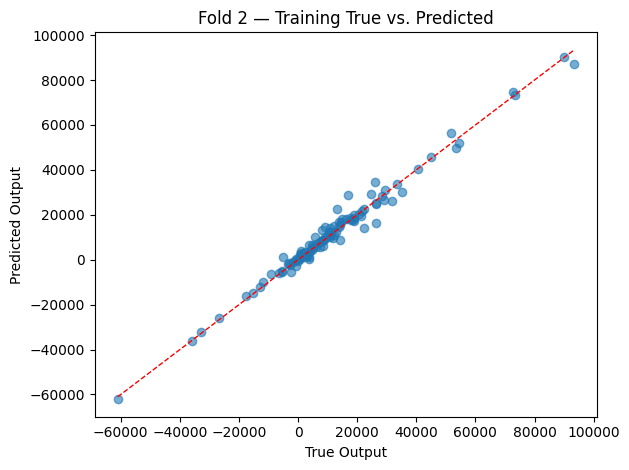

Fold 2 Validation MSE (norm): 0.2856
Fold 2 Validation R²: 0.7938, Pearson r: 0.9112


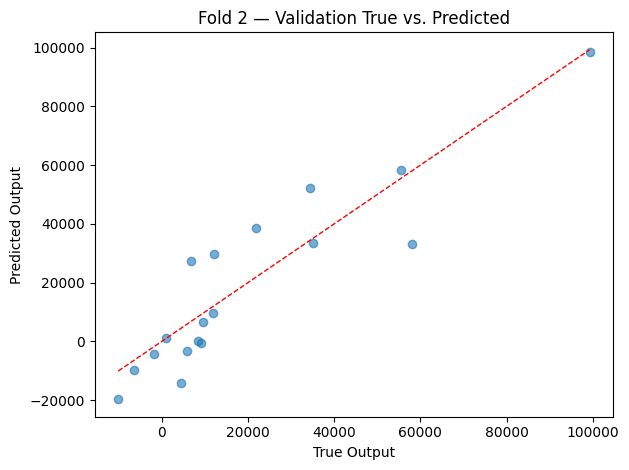


=== Fold 3/7 ===
Epoch   1/250  MSE=1.1785
Epoch  10/250  MSE=0.7691
Epoch  20/250  MSE=0.3413
Epoch  30/250  MSE=0.1961
Epoch  40/250  MSE=0.1543
Epoch  50/250  MSE=0.1346
Epoch  60/250  MSE=0.1246
Epoch  70/250  MSE=0.1163
Epoch  80/250  MSE=0.1131
Epoch  90/250  MSE=0.1092
Epoch 100/250  MSE=0.1072
Epoch 110/250  MSE=0.1041
Epoch 120/250  MSE=0.1043
Epoch 130/250  MSE=0.1027
Epoch 140/250  MSE=0.0992
Epoch 150/250  MSE=0.1052
Epoch 160/250  MSE=0.0984
Epoch 170/250  MSE=0.0982
Epoch 180/250  MSE=0.0945
Epoch 190/250  MSE=0.0905
Epoch 200/250  MSE=0.0891
Epoch 210/250  MSE=0.0850
Epoch 220/250  MSE=0.0837
Epoch 230/250  MSE=0.0854
Epoch 240/250  MSE=0.0825
Epoch 250/250  MSE=0.0753


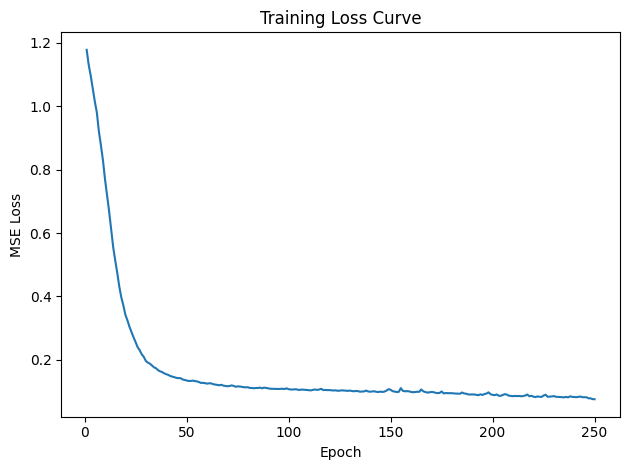

Fold 3 Training R²: 0.9313, Pearson r: 0.9652


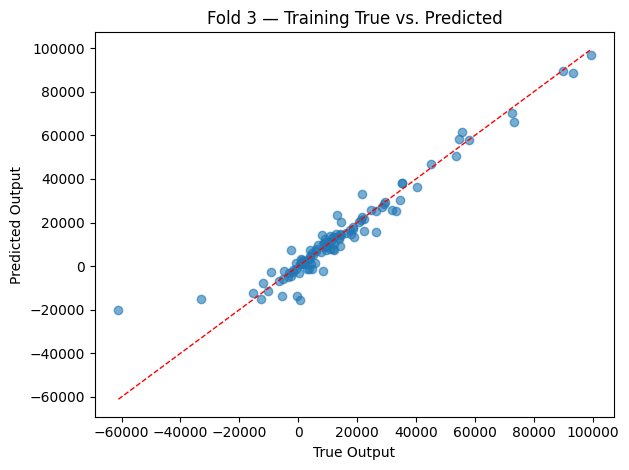

Fold 3 Validation MSE (norm): 0.3575
Fold 3 Validation R²: 0.5068, Pearson r: 0.8209


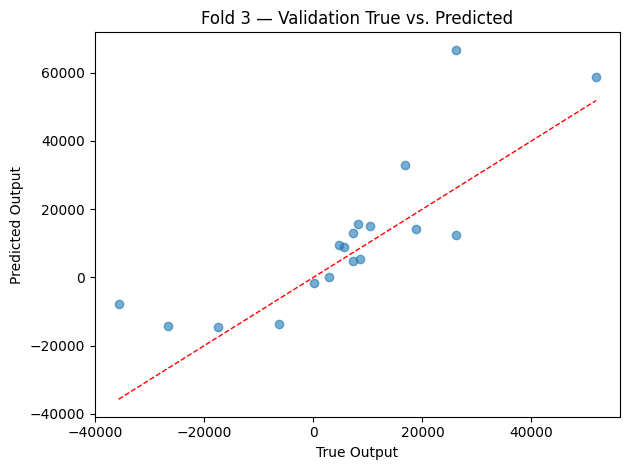


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8032
Epoch  10/250  MSE=0.7099
Epoch  20/250  MSE=0.1859
Epoch  30/250  MSE=0.0748
Epoch  40/250  MSE=0.0566
Epoch  50/250  MSE=0.0459
Epoch  60/250  MSE=0.0391
Epoch  70/250  MSE=0.0360
Epoch  80/250  MSE=0.0321
Epoch  90/250  MSE=0.0311
Epoch 100/250  MSE=0.0280
Epoch 110/250  MSE=0.0264
Epoch 120/250  MSE=0.0273
Epoch 130/250  MSE=0.0241
Epoch 140/250  MSE=0.0237
Epoch 150/250  MSE=0.0261
Epoch 160/250  MSE=0.0256
Epoch 170/250  MSE=0.0233
Epoch 180/250  MSE=0.0212
Epoch 190/250  MSE=0.0216
Epoch 200/250  MSE=0.0210
Epoch 210/250  MSE=0.0209
Epoch 220/250  MSE=0.0200
Epoch 230/250  MSE=0.0199
Epoch 240/250  MSE=0.0206
Epoch 250/250  MSE=0.0195


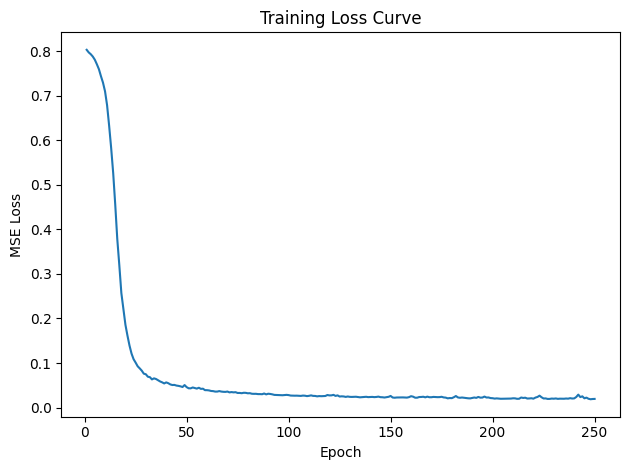

Fold 4 Training R²: 0.9754, Pearson r: 0.9877


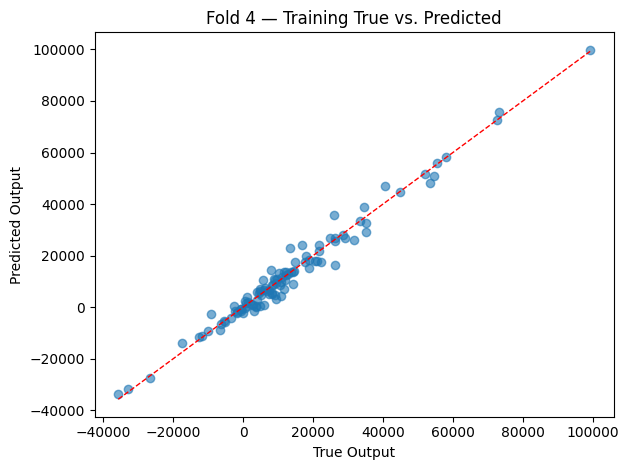

Fold 4 Validation MSE (norm): 1.3852
Fold 4 Validation R²: 0.3623, Pearson r: 0.6033


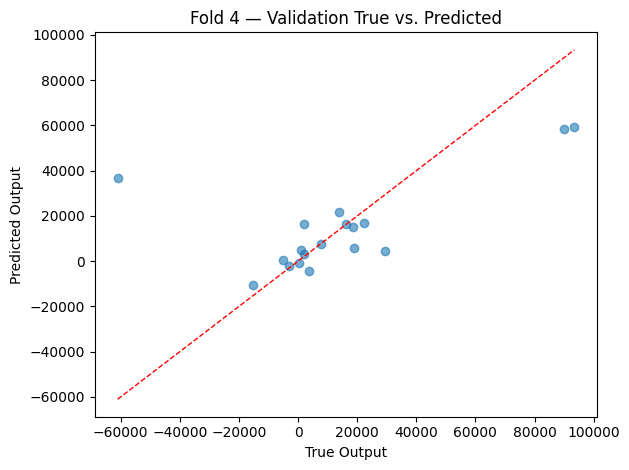


=== Fold 5/7 ===
Epoch   1/250  MSE=1.2187
Epoch  10/250  MSE=1.0267
Epoch  20/250  MSE=0.4868
Epoch  30/250  MSE=0.1554
Epoch  40/250  MSE=0.0994
Epoch  50/250  MSE=0.0746
Epoch  60/250  MSE=0.0664
Epoch  70/250  MSE=0.0583
Epoch  80/250  MSE=0.0544
Epoch  90/250  MSE=0.0497
Epoch 100/250  MSE=0.0453
Epoch 110/250  MSE=0.0428
Epoch 120/250  MSE=0.0414
Epoch 130/250  MSE=0.0396
Epoch 140/250  MSE=0.0387
Epoch 150/250  MSE=0.0378
Epoch 160/250  MSE=0.0344
Epoch 170/250  MSE=0.0321
Epoch 180/250  MSE=0.0314
Epoch 190/250  MSE=0.0284
Epoch 200/250  MSE=0.0262
Epoch 210/250  MSE=0.0254
Epoch 220/250  MSE=0.0242
Epoch 230/250  MSE=0.0225
Epoch 240/250  MSE=0.0225
Epoch 250/250  MSE=0.0209


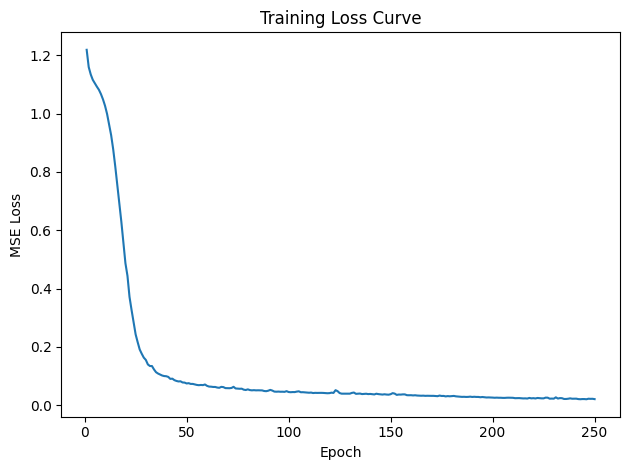

Fold 5 Training R²: 0.9808, Pearson r: 0.9904


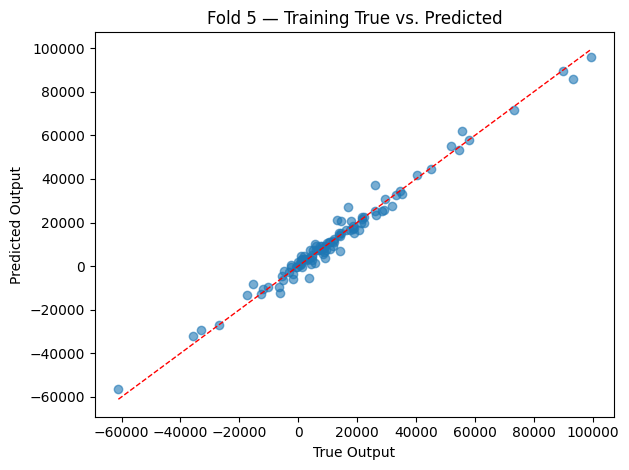

Fold 5 Validation MSE (norm): 0.3558
Fold 5 Validation R²: 0.5468, Pearson r: 0.8678


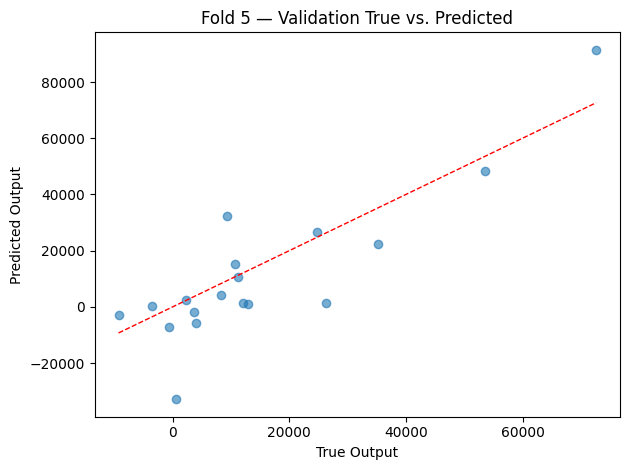


=== Fold 6/7 ===
Epoch   1/250  MSE=1.1873
Epoch  10/250  MSE=0.6944
Epoch  20/250  MSE=0.2335
Epoch  30/250  MSE=0.1235
Epoch  40/250  MSE=0.0813
Epoch  50/250  MSE=0.0633
Epoch  60/250  MSE=0.0465
Epoch  70/250  MSE=0.0336
Epoch  80/250  MSE=0.0290
Epoch  90/250  MSE=0.0248
Epoch 100/250  MSE=0.0233
Epoch 110/250  MSE=0.0223
Epoch 120/250  MSE=0.0207
Epoch 130/250  MSE=0.0206
Epoch 140/250  MSE=0.0195
Epoch 150/250  MSE=0.0198
Epoch 160/250  MSE=0.0191
Epoch 170/250  MSE=0.0189
Epoch 180/250  MSE=0.0197
Epoch 190/250  MSE=0.0185
Epoch 200/250  MSE=0.0173
Epoch 210/250  MSE=0.0168
Epoch 220/250  MSE=0.0156
Epoch 230/250  MSE=0.0159
Epoch 240/250  MSE=0.0181
Epoch 250/250  MSE=0.0159


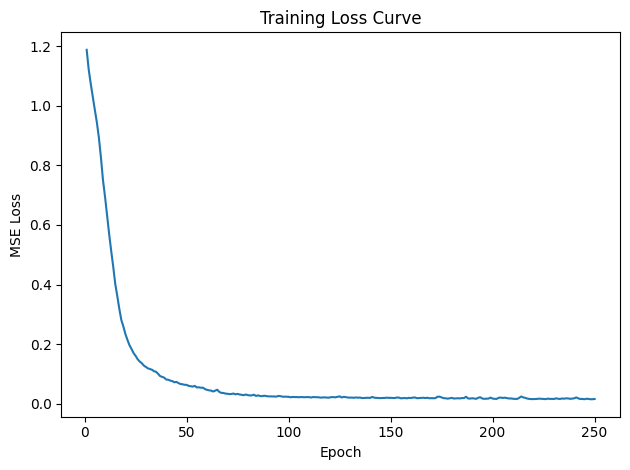

Fold 6 Training R²: 0.9864, Pearson r: 0.9932


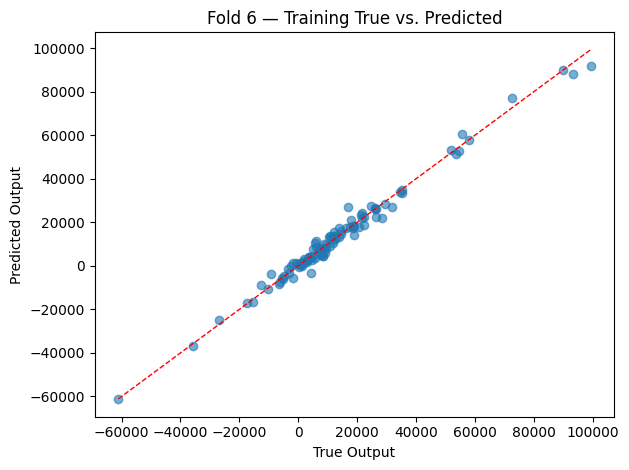

Fold 6 Validation MSE (norm): 0.8726
Fold 6 Validation R²: 0.1835, Pearson r: 0.5849


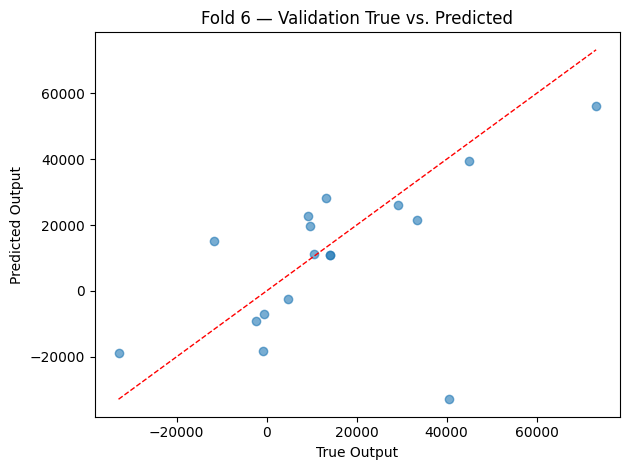


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1043
Epoch  10/250  MSE=0.8427
Epoch  20/250  MSE=0.6111
Epoch  30/250  MSE=0.4984
Epoch  40/250  MSE=0.4164
Epoch  50/250  MSE=0.3543
Epoch  60/250  MSE=0.3031
Epoch  70/250  MSE=0.2661
Epoch  80/250  MSE=0.2312
Epoch  90/250  MSE=0.2056
Epoch 100/250  MSE=0.1836
Epoch 110/250  MSE=0.1659
Epoch 120/250  MSE=0.1532
Epoch 130/250  MSE=0.1333
Epoch 140/250  MSE=0.1211
Epoch 150/250  MSE=0.1093
Epoch 160/250  MSE=0.0985
Epoch 170/250  MSE=0.0935
Epoch 180/250  MSE=0.0832
Epoch 190/250  MSE=0.0779
Epoch 200/250  MSE=0.0706
Epoch 210/250  MSE=0.0618
Epoch 220/250  MSE=0.0576
Epoch 230/250  MSE=0.0541
Epoch 240/250  MSE=0.0467
Epoch 250/250  MSE=0.0467


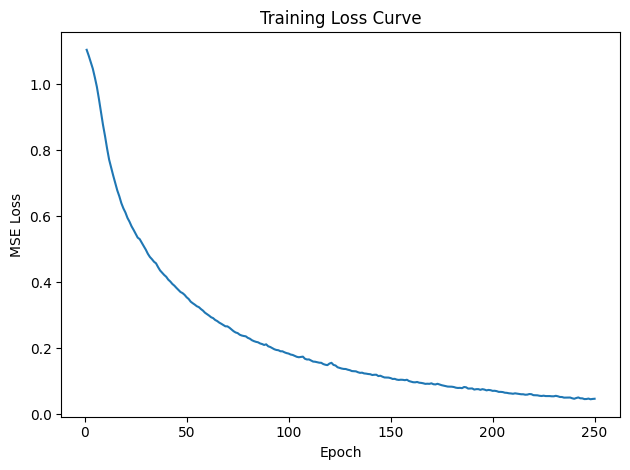

Fold 7 Training R²: 0.9581, Pearson r: 0.9827


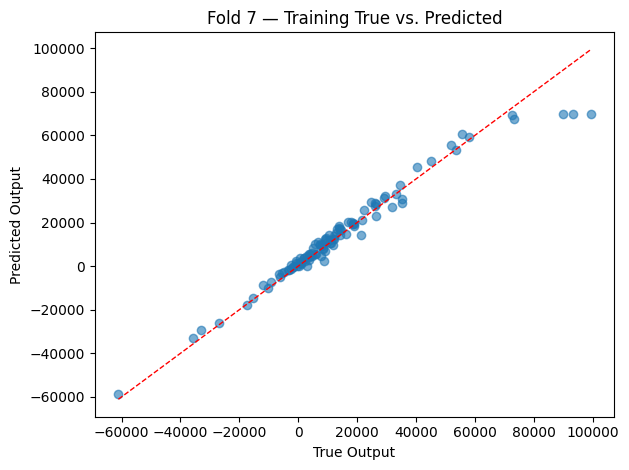

Fold 7 Validation MSE (norm): 0.2064
Fold 7 Validation R²: 0.5080, Pearson r: 0.7911


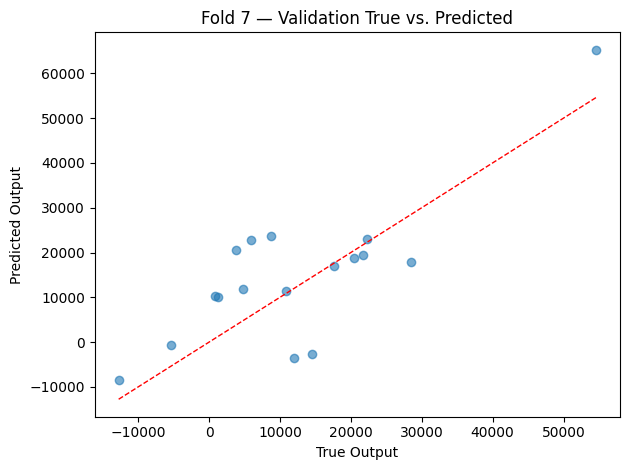


=== Validation MSE per fold ===
['0.1522', '0.2856', '0.3575', '1.3852', '0.3558', '0.8726', '0.2064']
Mean MSE (norm): 0.5165 ± 0.4166

=== Validation R² per fold ===
['0.2391', '0.7938', '0.5068', '0.3623', '0.5468', '0.1835', '0.5080']
Mean R²: 0.4486 ± 0.1917

=== Validation Pearson r per fold ===
['0.6882', '0.9112', '0.8209', '0.6033', '0.8678', '0.5849', '0.7911']
Mean Pearson r: 0.7525 ± 0.1190


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [12]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [4, 4],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")
'''
'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [8, 8] ReLU 


=== Fold 1/7 ===
Epoch   1/250  MSE=1.2037


Epoch  10/250  MSE=0.3068
Epoch  20/250  MSE=0.1096
Epoch  30/250  MSE=0.0666
Epoch  40/250  MSE=0.0404
Epoch  50/250  MSE=0.0329
Epoch  60/250  MSE=0.0253
Epoch  70/250  MSE=0.0197
Epoch  80/250  MSE=0.0157
Epoch  90/250  MSE=0.0151
Epoch 100/250  MSE=0.0124
Epoch 110/250  MSE=0.0111
Epoch 120/250  MSE=0.0123
Epoch 130/250  MSE=0.0094
Epoch 140/250  MSE=0.0121
Epoch 150/250  MSE=0.0082
Epoch 160/250  MSE=0.0106
Epoch 170/250  MSE=0.0090
Epoch 180/250  MSE=0.0076
Epoch 190/250  MSE=0.0071
Epoch 200/250  MSE=0.0073
Epoch 210/250  MSE=0.0152
Epoch 220/250  MSE=0.0079
Epoch 230/250  MSE=0.0039
Epoch 240/250  MSE=0.0049
Epoch 250/250  MSE=0.0036


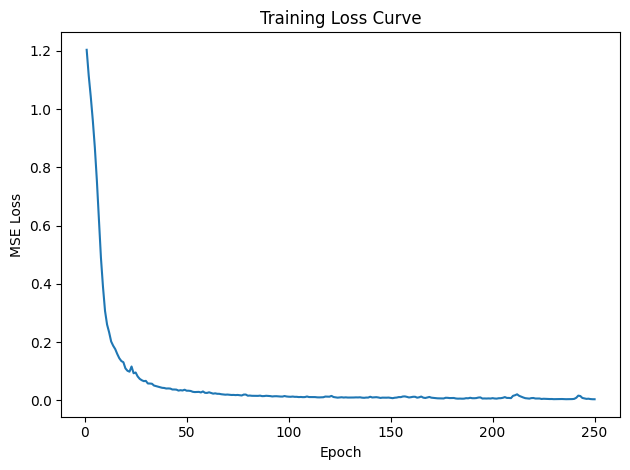

Fold 1 Training R²: 0.9974, Pearson r: 0.9987


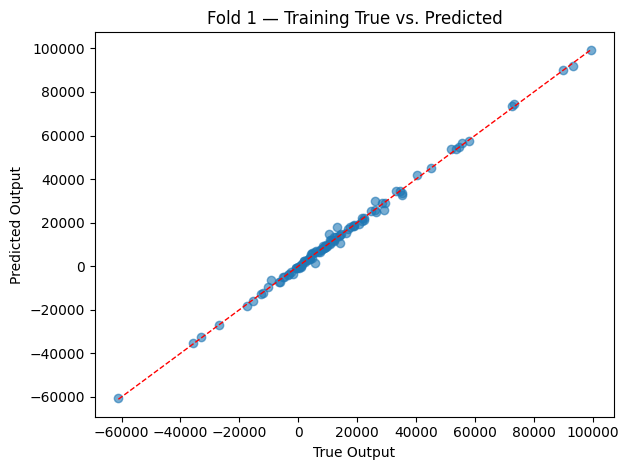

Fold 1 Validation MSE (norm): 0.1657
Fold 1 Validation R²: 0.1713, Pearson r: 0.7317


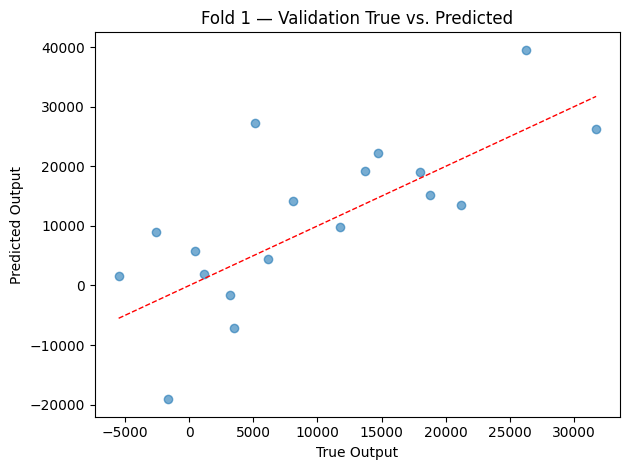


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9426
Epoch  10/250  MSE=0.6429
Epoch  20/250  MSE=0.1373
Epoch  30/250  MSE=0.0659
Epoch  40/250  MSE=0.0443
Epoch  50/250  MSE=0.0370
Epoch  60/250  MSE=0.0304
Epoch  70/250  MSE=0.0255
Epoch  80/250  MSE=0.0238
Epoch  90/250  MSE=0.0222
Epoch 100/250  MSE=0.0168
Epoch 110/250  MSE=0.0153
Epoch 120/250  MSE=0.0211
Epoch 130/250  MSE=0.0132
Epoch 140/250  MSE=0.0099
Epoch 150/250  MSE=0.0168
Epoch 160/250  MSE=0.0089
Epoch 170/250  MSE=0.0073
Epoch 180/250  MSE=0.0072
Epoch 190/250  MSE=0.0063
Epoch 200/250  MSE=0.0080
Epoch 210/250  MSE=0.0074
Epoch 220/250  MSE=0.0046
Epoch 230/250  MSE=0.0196
Epoch 240/250  MSE=0.0048
Epoch 250/250  MSE=0.0054


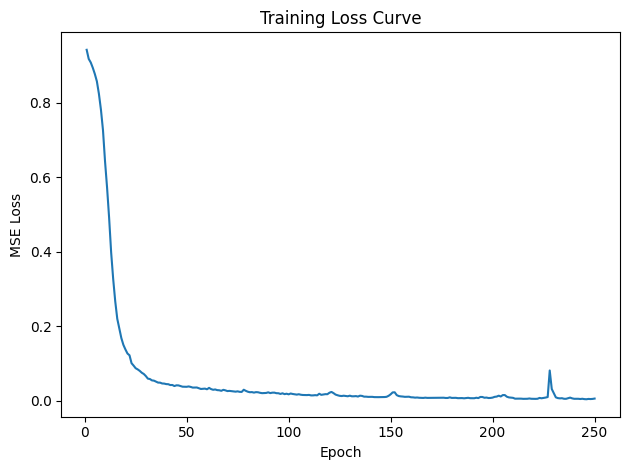

Fold 2 Training R²: 0.9961, Pearson r: 0.9981


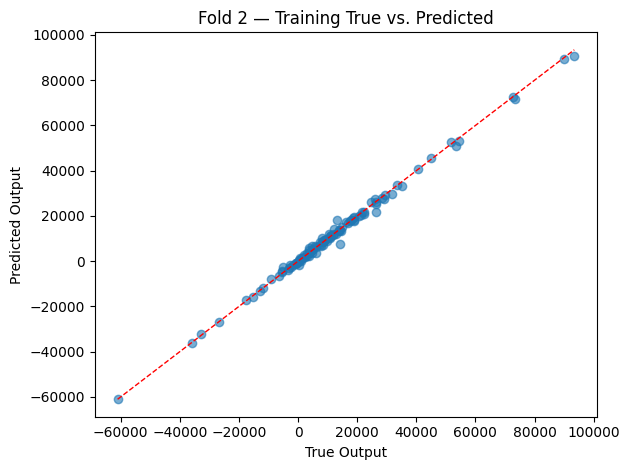

Fold 2 Validation MSE (norm): 0.1793
Fold 2 Validation R²: 0.8705, Pearson r: 0.9342


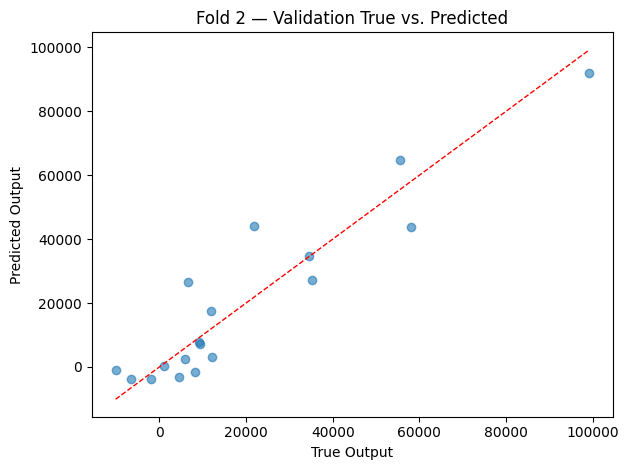


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0025
Epoch  10/250  MSE=0.2733
Epoch  20/250  MSE=0.0850
Epoch  30/250  MSE=0.0382
Epoch  40/250  MSE=0.0265
Epoch  50/250  MSE=0.0190
Epoch  60/250  MSE=0.0185
Epoch  70/250  MSE=0.0135
Epoch  80/250  MSE=0.0131
Epoch  90/250  MSE=0.0112
Epoch 100/250  MSE=0.0127
Epoch 110/250  MSE=0.0099
Epoch 120/250  MSE=0.0201
Epoch 130/250  MSE=0.0116
Epoch 140/250  MSE=0.0105
Epoch 150/250  MSE=0.0103
Epoch 160/250  MSE=0.0089
Epoch 170/250  MSE=0.0094
Epoch 180/250  MSE=0.0099
Epoch 190/250  MSE=0.0085
Epoch 200/250  MSE=0.0078
Epoch 210/250  MSE=0.0108
Epoch 220/250  MSE=0.0100
Epoch 230/250  MSE=0.0132
Epoch 240/250  MSE=0.0074
Epoch 250/250  MSE=0.0075


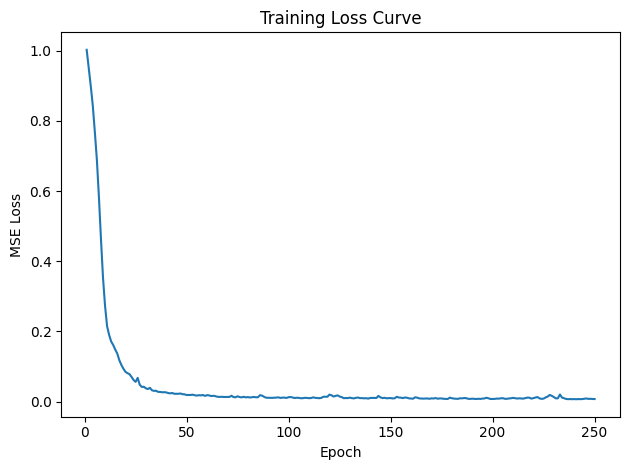

Fold 3 Training R²: 0.9935, Pearson r: 0.9968


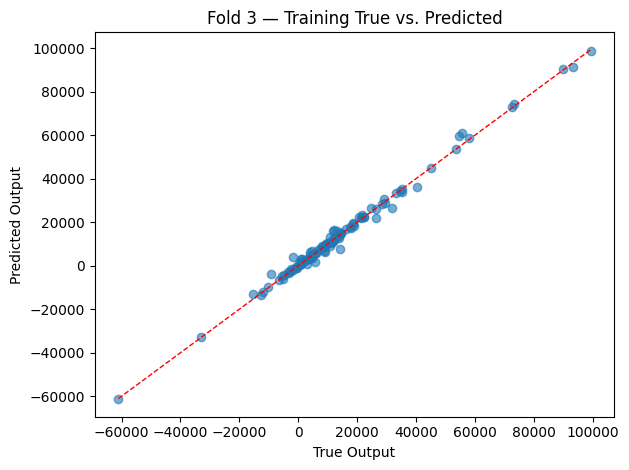

Fold 3 Validation MSE (norm): 0.3790
Fold 3 Validation R²: 0.4771, Pearson r: 0.8255


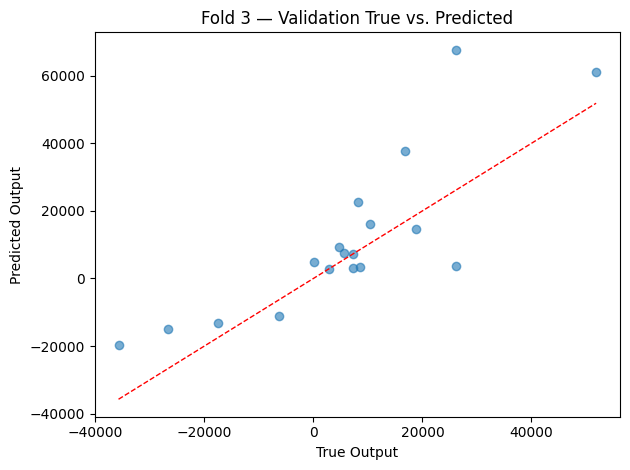


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8489
Epoch  10/250  MSE=0.3655
Epoch  20/250  MSE=0.0721
Epoch  30/250  MSE=0.0387
Epoch  40/250  MSE=0.0277
Epoch  50/250  MSE=0.0207
Epoch  60/250  MSE=0.0177
Epoch  70/250  MSE=0.0157
Epoch  80/250  MSE=0.0132
Epoch  90/250  MSE=0.0130
Epoch 100/250  MSE=0.0115
Epoch 110/250  MSE=0.0100
Epoch 120/250  MSE=0.0086
Epoch 130/250  MSE=0.0097
Epoch 140/250  MSE=0.0262
Epoch 150/250  MSE=0.0066
Epoch 160/250  MSE=0.0081
Epoch 170/250  MSE=0.0073
Epoch 180/250  MSE=0.0054
Epoch 190/250  MSE=0.0097
Epoch 200/250  MSE=0.0080
Epoch 210/250  MSE=0.0079
Epoch 220/250  MSE=0.0063
Epoch 230/250  MSE=0.0063
Epoch 240/250  MSE=0.0105
Epoch 250/250  MSE=0.0071


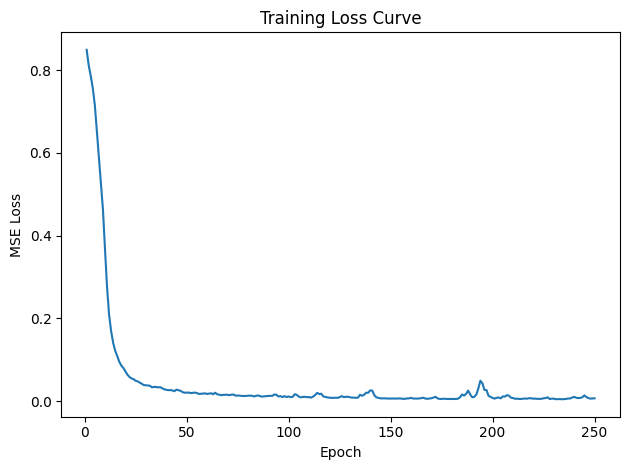

Fold 4 Training R²: 0.9922, Pearson r: 0.9963


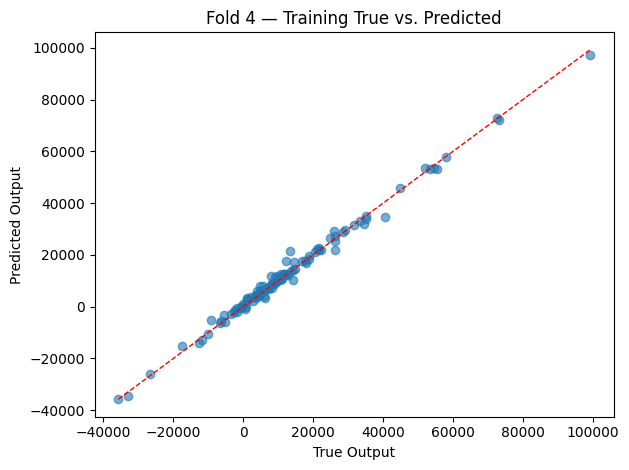

Fold 4 Validation MSE (norm): 1.5054
Fold 4 Validation R²: 0.3070, Pearson r: 0.5578


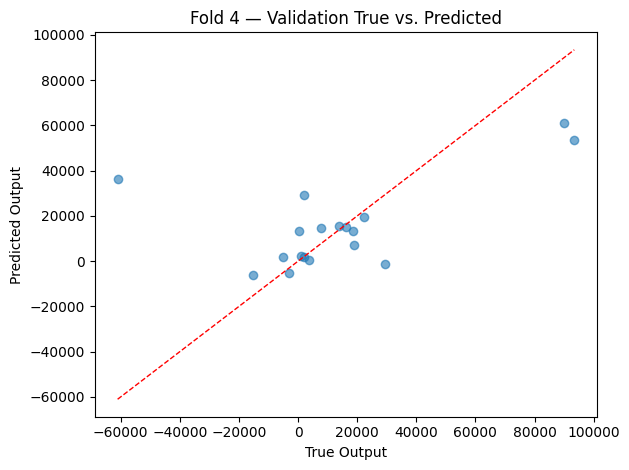


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0638
Epoch  10/250  MSE=0.6874
Epoch  20/250  MSE=0.1453
Epoch  30/250  MSE=0.0728
Epoch  40/250  MSE=0.0522
Epoch  50/250  MSE=0.0359
Epoch  60/250  MSE=0.0294
Epoch  70/250  MSE=0.0240
Epoch  80/250  MSE=0.0197
Epoch  90/250  MSE=0.0192
Epoch 100/250  MSE=0.0164
Epoch 110/250  MSE=0.0122
Epoch 120/250  MSE=0.0100
Epoch 130/250  MSE=0.0120
Epoch 140/250  MSE=0.0102
Epoch 150/250  MSE=0.0076
Epoch 160/250  MSE=0.0087
Epoch 170/250  MSE=0.0081
Epoch 180/250  MSE=0.0059
Epoch 190/250  MSE=0.0075
Epoch 200/250  MSE=0.0054
Epoch 210/250  MSE=0.0075
Epoch 220/250  MSE=0.0058
Epoch 230/250  MSE=0.0092
Epoch 240/250  MSE=0.0079
Epoch 250/250  MSE=0.0055


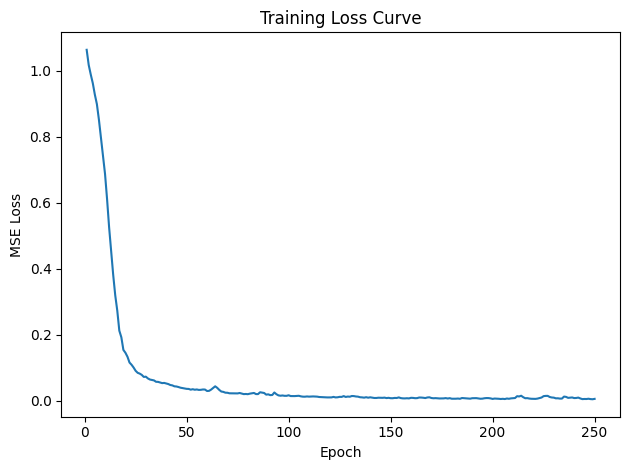

Fold 5 Training R²: 0.9922, Pearson r: 0.9981


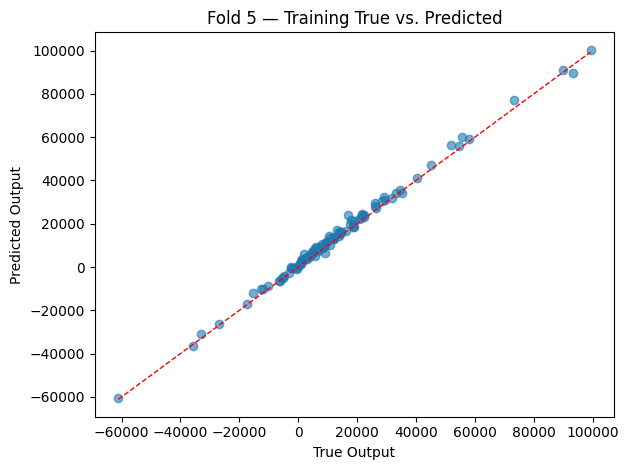

Fold 5 Validation MSE (norm): 0.6495
Fold 5 Validation R²: 0.1727, Pearson r: 0.8318


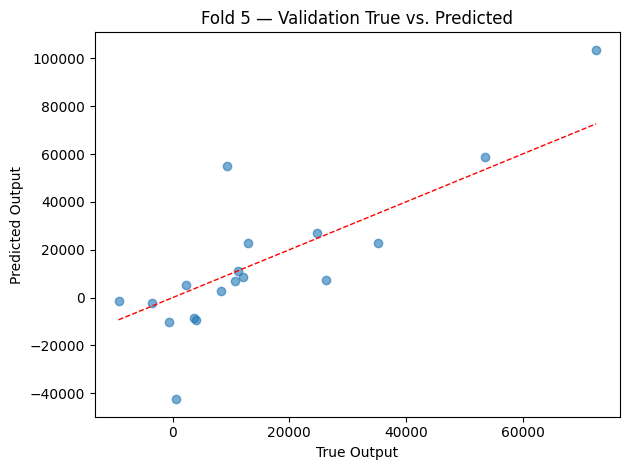


=== Fold 6/7 ===
Epoch   1/250  MSE=1.1282
Epoch  10/250  MSE=0.3246
Epoch  20/250  MSE=0.0871
Epoch  30/250  MSE=0.0507
Epoch  40/250  MSE=0.0405
Epoch  50/250  MSE=0.0328
Epoch  60/250  MSE=0.0347
Epoch  70/250  MSE=0.0289
Epoch  80/250  MSE=0.0272
Epoch  90/250  MSE=0.0245
Epoch 100/250  MSE=0.0229
Epoch 110/250  MSE=0.0235
Epoch 120/250  MSE=0.0228
Epoch 130/250  MSE=0.0165
Epoch 140/250  MSE=0.0149
Epoch 150/250  MSE=0.0170
Epoch 160/250  MSE=0.0158
Epoch 170/250  MSE=0.0112
Epoch 180/250  MSE=0.0143
Epoch 190/250  MSE=0.0092
Epoch 200/250  MSE=0.0100
Epoch 210/250  MSE=0.0088
Epoch 220/250  MSE=0.0064
Epoch 230/250  MSE=0.0081
Epoch 240/250  MSE=0.0058
Epoch 250/250  MSE=0.0085


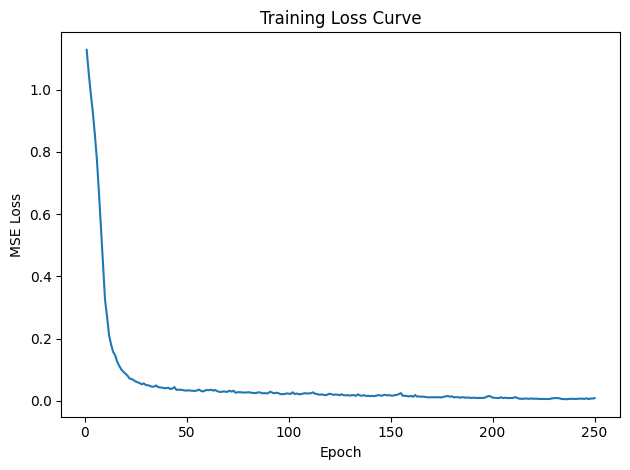

Fold 6 Training R²: 0.9916, Pearson r: 0.9958


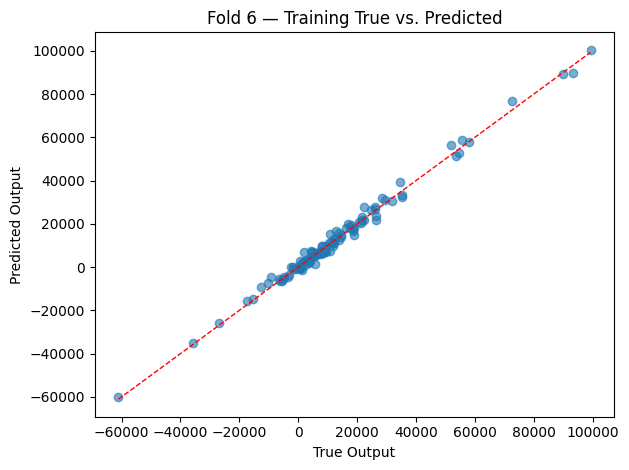

Fold 6 Validation MSE (norm): 0.8796
Fold 6 Validation R²: 0.1769, Pearson r: 0.6262


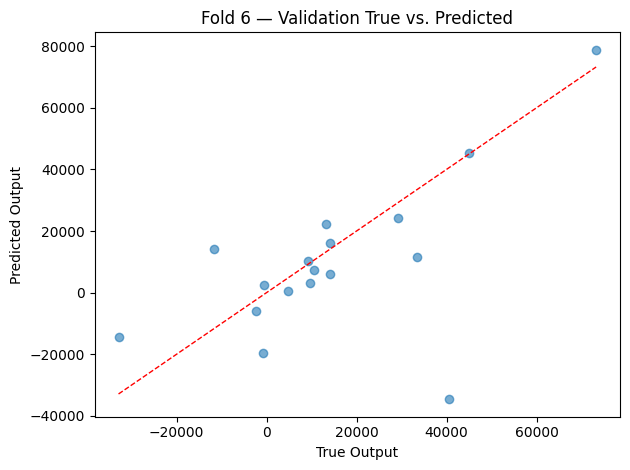


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1701
Epoch  10/250  MSE=0.6012
Epoch  20/250  MSE=0.1490
Epoch  30/250  MSE=0.0763
Epoch  40/250  MSE=0.0522
Epoch  50/250  MSE=0.0411
Epoch  60/250  MSE=0.0375
Epoch  70/250  MSE=0.0289
Epoch  80/250  MSE=0.0248
Epoch  90/250  MSE=0.0258
Epoch 100/250  MSE=0.0229
Epoch 110/250  MSE=0.0187
Epoch 120/250  MSE=0.0250
Epoch 130/250  MSE=0.0167
Epoch 140/250  MSE=0.0224
Epoch 150/250  MSE=0.0177
Epoch 160/250  MSE=0.0139
Epoch 170/250  MSE=0.0203
Epoch 180/250  MSE=0.0117
Epoch 190/250  MSE=0.0119
Epoch 200/250  MSE=0.0135
Epoch 210/250  MSE=0.0109
Epoch 220/250  MSE=0.0103
Epoch 230/250  MSE=0.0094
Epoch 240/250  MSE=0.0079
Epoch 250/250  MSE=0.0076


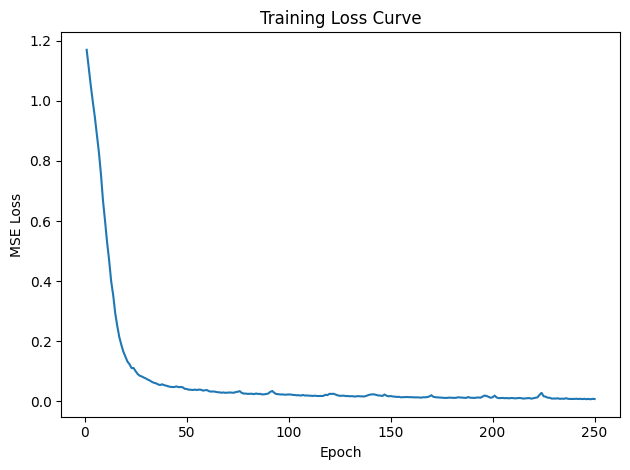

Fold 7 Training R²: 0.9939, Pearson r: 0.9970


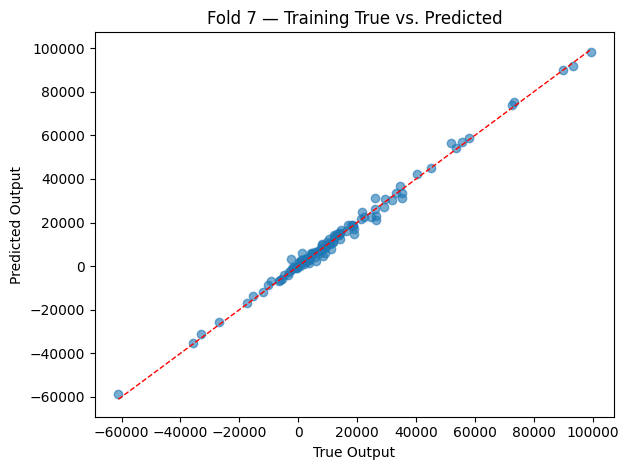

Fold 7 Validation MSE (norm): 0.1971
Fold 7 Validation R²: 0.5303, Pearson r: 0.7645


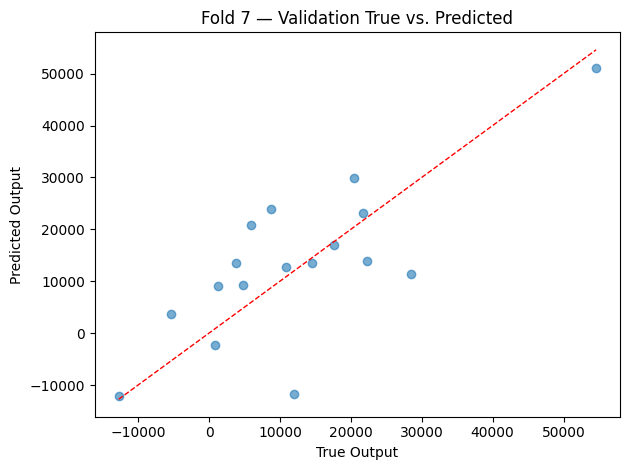


=== Validation MSE per fold ===
['0.1657', '0.1793', '0.3790', '1.5054', '0.6495', '0.8796', '0.1971']
Mean MSE (norm): 0.5651 ± 0.4580

=== Validation R² per fold ===
['0.1713', '0.8705', '0.4771', '0.3070', '0.1727', '0.1769', '0.5303']
Mean R²: 0.3866 ± 0.2407

=== Validation Pearson r per fold ===
['0.7317', '0.9342', '0.8255', '0.5578', '0.8318', '0.6262', '0.7645']
Mean Pearson r: 0.7531 ± 0.1190


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [13]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [8, 8],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")
'''
'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [12] Relu


=== Fold 1/7 ===
Epoch   1/250  MSE=1.1861
Epoch  10/250  MSE=0.3673
Epoch  20/250  MSE=0.1262
Epoch  30/250  MSE=0.0758
Epoch  40/250  MSE=0.0497
Epoch  50/250  MSE=0.0359
Epoch  60/250  MSE=0.0286
Epoch  70/250  MSE=0.0240
Epoch  80/250  MSE=0.0205
Epoch  90/250  MSE=0.0165
Epoch 100/250  MSE=0.0153
Epoch 110/250  MSE=0.0161
Epoch 120/250  MSE=0.0102
Epoch 130/250  MSE=0.0123
Epoch 140/250  MSE=0.0079
Epoch 150/250  MSE=0.0086
Epoch 160/250  MSE=0.0070
Epoch 170/250  MSE=0.0059
Epoch 180/250  MSE=0.0064
Epoch 190/250  MSE=0.0053
Epoch 200/250  MSE=0.0103
Epoch 210/250  MSE=0.0075
Epoch 220/250  MSE=0.0141
Epoch 230/250  MSE=0.0049
Epoch 240/250  MSE=0.0036
Epoch 250/250  MSE=0.0042


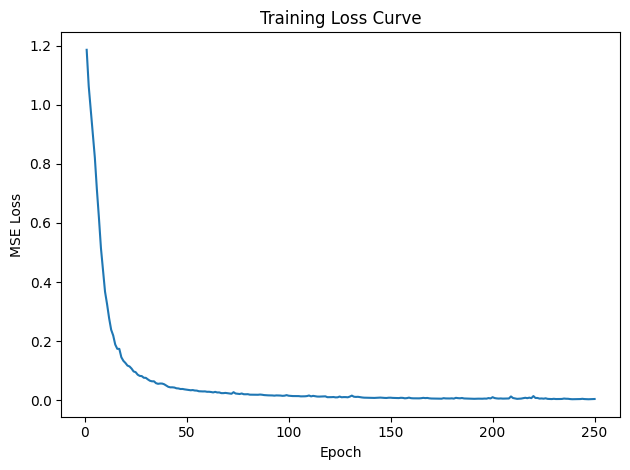

Fold 1 Training R²: 0.9969, Pearson r: 0.9985


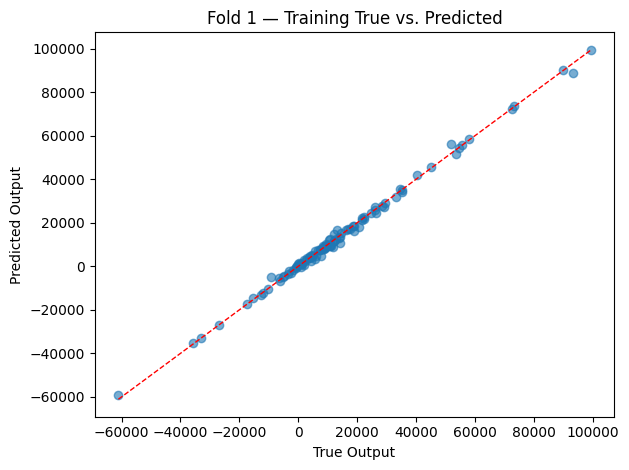

Fold 1 Validation MSE (norm): 0.2547
Fold 1 Validation R²: -0.2737, Pearson r: 0.4525


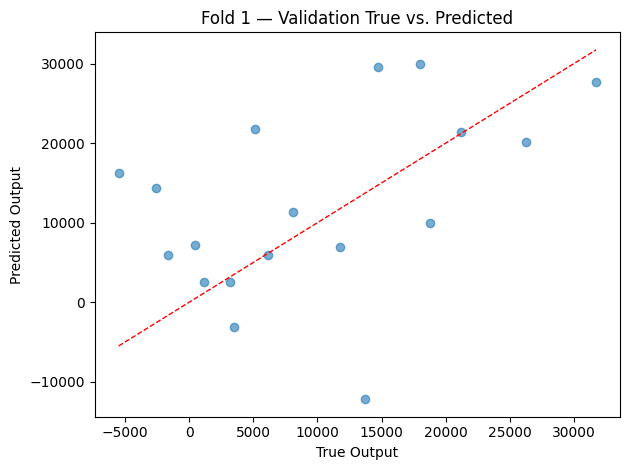


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9625
Epoch  10/250  MSE=0.4012
Epoch  20/250  MSE=0.1192
Epoch  30/250  MSE=0.0685
Epoch  40/250  MSE=0.0468
Epoch  50/250  MSE=0.0347
Epoch  60/250  MSE=0.0283
Epoch  70/250  MSE=0.0253
Epoch  80/250  MSE=0.0225
Epoch  90/250  MSE=0.0196
Epoch 100/250  MSE=0.0178
Epoch 110/250  MSE=0.0158
Epoch 120/250  MSE=0.0150
Epoch 130/250  MSE=0.0143
Epoch 140/250  MSE=0.0118
Epoch 150/250  MSE=0.0105
Epoch 160/250  MSE=0.0113
Epoch 170/250  MSE=0.0091
Epoch 180/250  MSE=0.0080
Epoch 190/250  MSE=0.0085
Epoch 200/250  MSE=0.0086
Epoch 210/250  MSE=0.0069
Epoch 220/250  MSE=0.0065
Epoch 230/250  MSE=0.0083
Epoch 240/250  MSE=0.0068
Epoch 250/250  MSE=0.0069


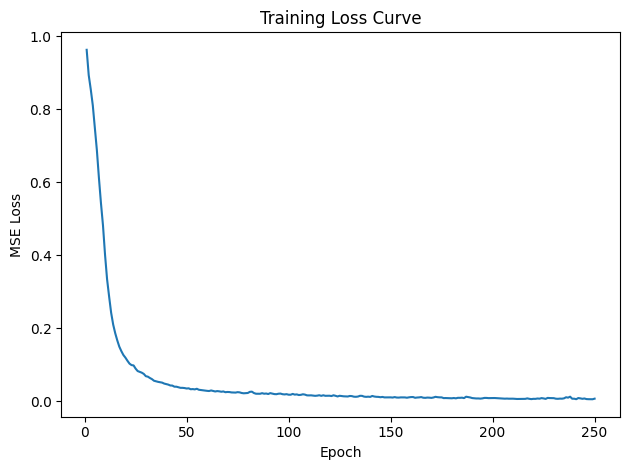

Fold 2 Training R²: 0.9931, Pearson r: 0.9970


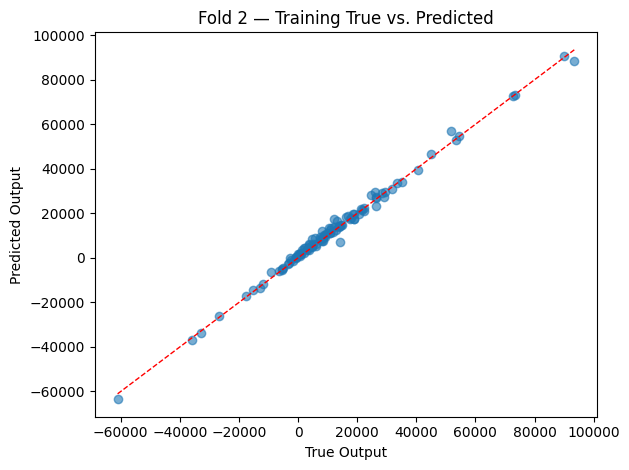

Fold 2 Validation MSE (norm): 0.5130
Fold 2 Validation R²: 0.6296, Pearson r: 0.8358


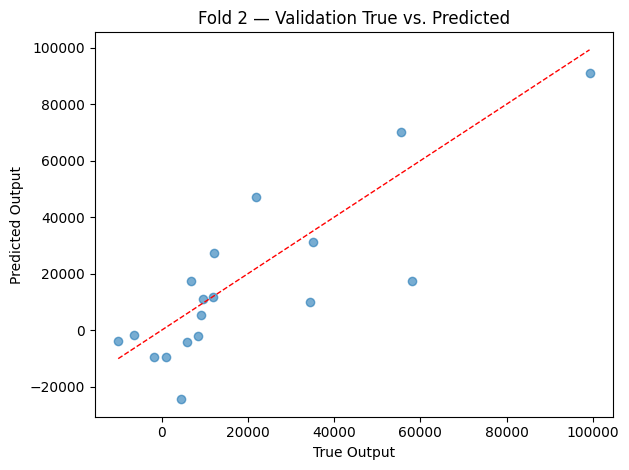


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0134
Epoch  10/250  MSE=0.2476
Epoch  20/250  MSE=0.0764
Epoch  30/250  MSE=0.0371
Epoch  40/250  MSE=0.0224
Epoch  50/250  MSE=0.0162
Epoch  60/250  MSE=0.0137
Epoch  70/250  MSE=0.0108
Epoch  80/250  MSE=0.0096
Epoch  90/250  MSE=0.0084
Epoch 100/250  MSE=0.0076
Epoch 110/250  MSE=0.0067
Epoch 120/250  MSE=0.0067
Epoch 130/250  MSE=0.0061
Epoch 140/250  MSE=0.0054
Epoch 150/250  MSE=0.0050
Epoch 160/250  MSE=0.0045
Epoch 170/250  MSE=0.0044
Epoch 180/250  MSE=0.0045
Epoch 190/250  MSE=0.0037
Epoch 200/250  MSE=0.0060
Epoch 210/250  MSE=0.0057
Epoch 220/250  MSE=0.0047
Epoch 230/250  MSE=0.0033
Epoch 240/250  MSE=0.0052
Epoch 250/250  MSE=0.0037


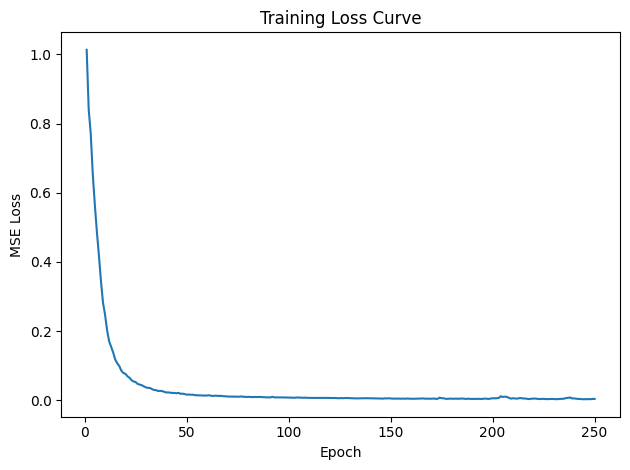

Fold 3 Training R²: 0.9973, Pearson r: 0.9987


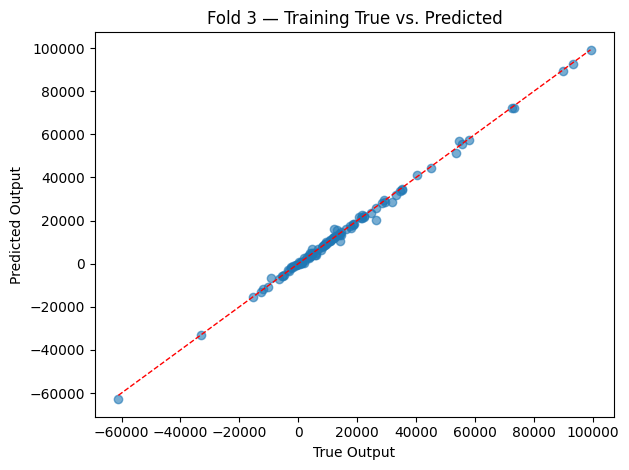

Fold 3 Validation MSE (norm): 0.3794
Fold 3 Validation R²: 0.4767, Pearson r: 0.8304


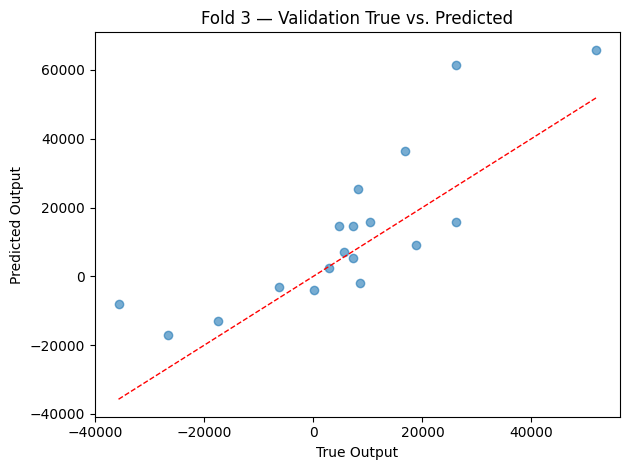


=== Fold 4/7 ===
Epoch   1/250  MSE=0.7827
Epoch  10/250  MSE=0.1610
Epoch  20/250  MSE=0.0567
Epoch  30/250  MSE=0.0352
Epoch  40/250  MSE=0.0237
Epoch  50/250  MSE=0.0204
Epoch  60/250  MSE=0.0165
Epoch  70/250  MSE=0.0146
Epoch  80/250  MSE=0.0138
Epoch  90/250  MSE=0.0125
Epoch 100/250  MSE=0.0192
Epoch 110/250  MSE=0.0104
Epoch 120/250  MSE=0.0098
Epoch 130/250  MSE=0.0085
Epoch 140/250  MSE=0.0118
Epoch 150/250  MSE=0.0090
Epoch 160/250  MSE=0.0095
Epoch 170/250  MSE=0.0068
Epoch 180/250  MSE=0.0062
Epoch 190/250  MSE=0.0078
Epoch 200/250  MSE=0.0069
Epoch 210/250  MSE=0.0054
Epoch 220/250  MSE=0.0048
Epoch 230/250  MSE=0.0059
Epoch 240/250  MSE=0.0053
Epoch 250/250  MSE=0.0039


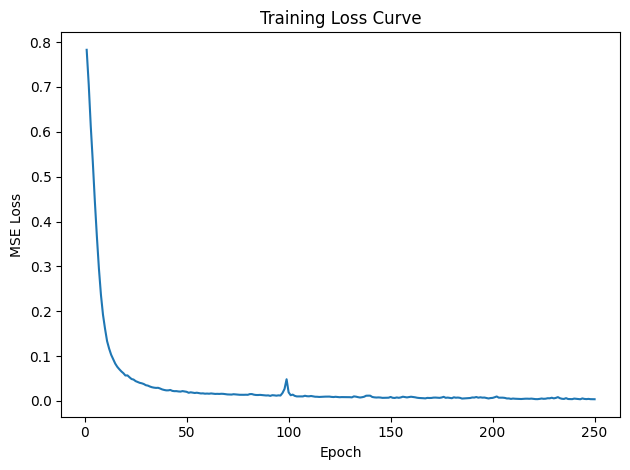

Fold 4 Training R²: 0.9953, Pearson r: 0.9977


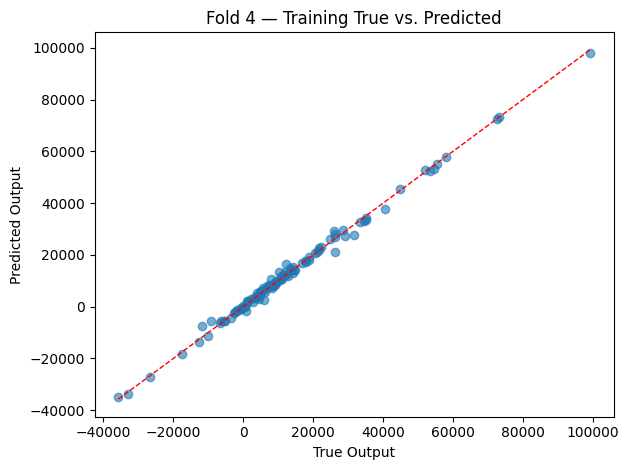

Fold 4 Validation MSE (norm): 0.9664
Fold 4 Validation R²: 0.5551, Pearson r: 0.7796


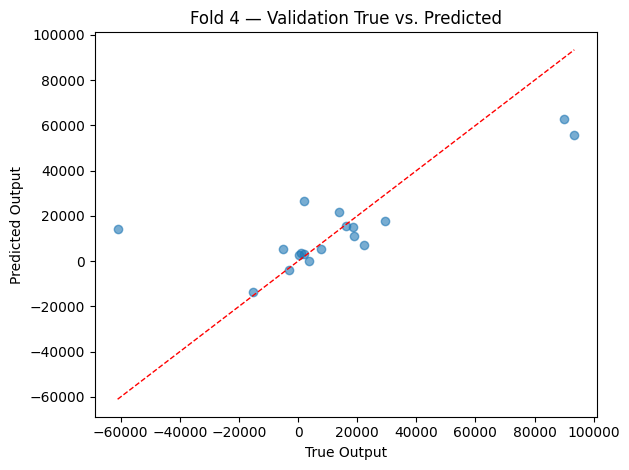


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0866
Epoch  10/250  MSE=0.3571
Epoch  20/250  MSE=0.1151
Epoch  30/250  MSE=0.0711
Epoch  40/250  MSE=0.0524
Epoch  50/250  MSE=0.0398
Epoch  60/250  MSE=0.0350
Epoch  70/250  MSE=0.0254
Epoch  80/250  MSE=0.0202
Epoch  90/250  MSE=0.0171
Epoch 100/250  MSE=0.0163
Epoch 110/250  MSE=0.0153
Epoch 120/250  MSE=0.0110
Epoch 130/250  MSE=0.0096
Epoch 140/250  MSE=0.0077
Epoch 150/250  MSE=0.0074
Epoch 160/250  MSE=0.0059
Epoch 170/250  MSE=0.0086
Epoch 180/250  MSE=0.0049
Epoch 190/250  MSE=0.0055
Epoch 200/250  MSE=0.0039
Epoch 210/250  MSE=0.0042
Epoch 220/250  MSE=0.0113
Epoch 230/250  MSE=0.0028
Epoch 240/250  MSE=0.0031
Epoch 250/250  MSE=0.0034


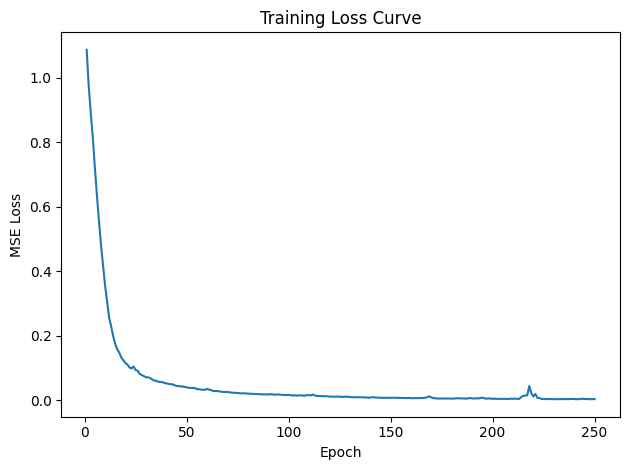

Fold 5 Training R²: 0.9977, Pearson r: 0.9989


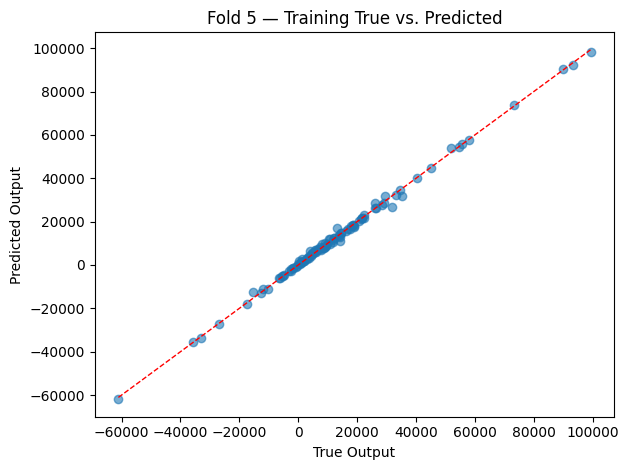

Fold 5 Validation MSE (norm): 0.7744
Fold 5 Validation R²: 0.0137, Pearson r: 0.8366


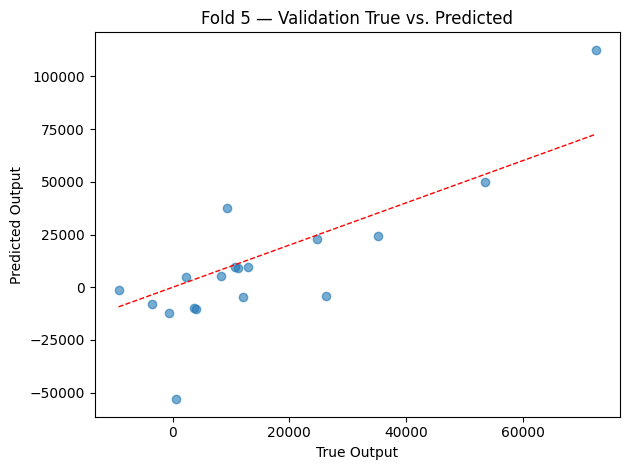


=== Fold 6/7 ===
Epoch   1/250  MSE=0.9818
Epoch  10/250  MSE=0.3679
Epoch  20/250  MSE=0.0895
Epoch  30/250  MSE=0.0538
Epoch  40/250  MSE=0.0380
Epoch  50/250  MSE=0.0289
Epoch  60/250  MSE=0.0234
Epoch  70/250  MSE=0.0190
Epoch  80/250  MSE=0.0182
Epoch  90/250  MSE=0.0148
Epoch 100/250  MSE=0.0117
Epoch 110/250  MSE=0.0106
Epoch 120/250  MSE=0.0084
Epoch 130/250  MSE=0.0071
Epoch 140/250  MSE=0.0072
Epoch 150/250  MSE=0.0050
Epoch 160/250  MSE=0.0098
Epoch 170/250  MSE=0.0036
Epoch 180/250  MSE=0.0029
Epoch 190/250  MSE=0.0027
Epoch 200/250  MSE=0.0024
Epoch 210/250  MSE=0.0024
Epoch 220/250  MSE=0.0030
Epoch 230/250  MSE=0.0158
Epoch 240/250  MSE=0.0013
Epoch 250/250  MSE=0.0012


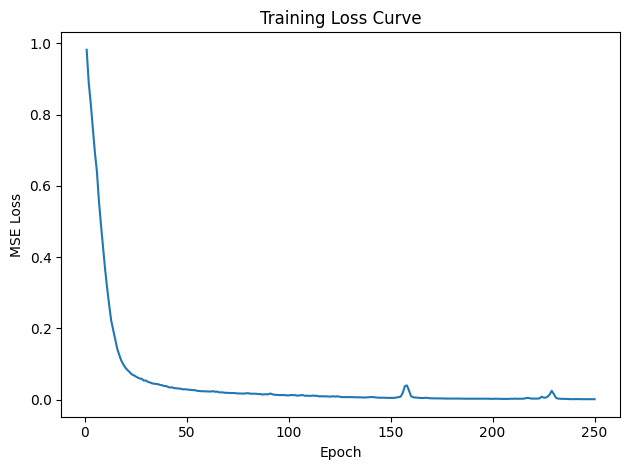

Fold 6 Training R²: 0.9988, Pearson r: 0.9995


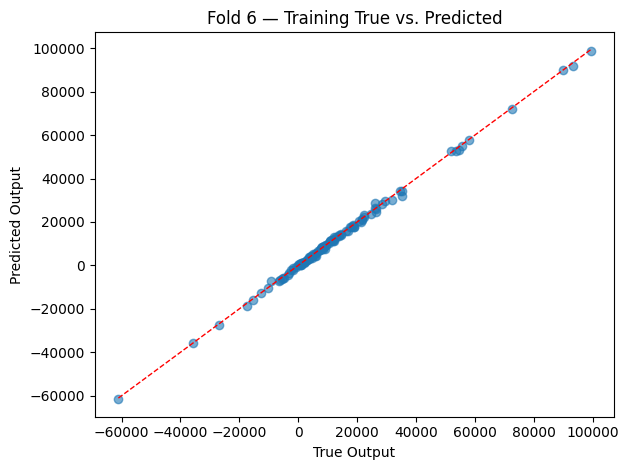

Fold 6 Validation MSE (norm): 1.2752
Fold 6 Validation R²: -0.1932, Pearson r: 0.5147


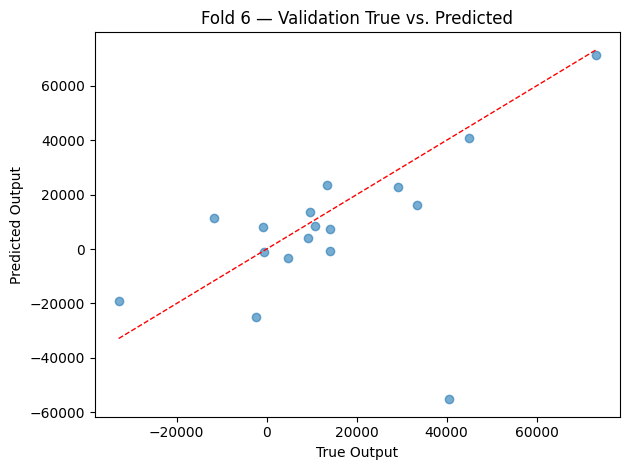


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1571
Epoch  10/250  MSE=0.3974
Epoch  20/250  MSE=0.1253
Epoch  30/250  MSE=0.0723
Epoch  40/250  MSE=0.0506
Epoch  50/250  MSE=0.0389
Epoch  60/250  MSE=0.0321
Epoch  70/250  MSE=0.0286
Epoch  80/250  MSE=0.0238
Epoch  90/250  MSE=0.0216
Epoch 100/250  MSE=0.0195
Epoch 110/250  MSE=0.0190
Epoch 120/250  MSE=0.0162
Epoch 130/250  MSE=0.0149
Epoch 140/250  MSE=0.0155
Epoch 150/250  MSE=0.0132
Epoch 160/250  MSE=0.0130
Epoch 170/250  MSE=0.0113
Epoch 180/250  MSE=0.0100
Epoch 190/250  MSE=0.0092
Epoch 200/250  MSE=0.0102
Epoch 210/250  MSE=0.0079
Epoch 220/250  MSE=0.0102
Epoch 230/250  MSE=0.0069
Epoch 240/250  MSE=0.0086
Epoch 250/250  MSE=0.0163


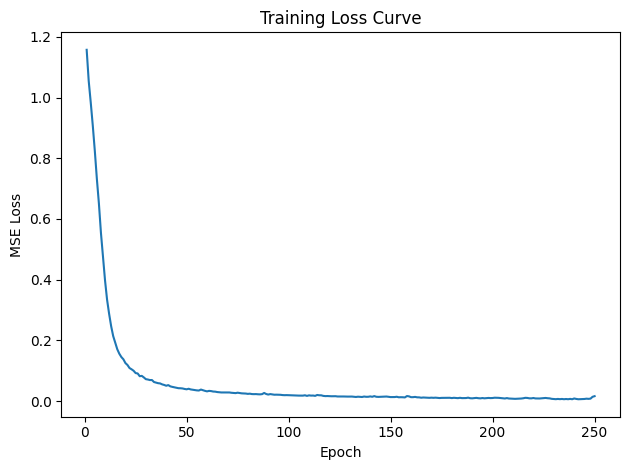

Fold 7 Training R²: 0.9928, Pearson r: 0.9968


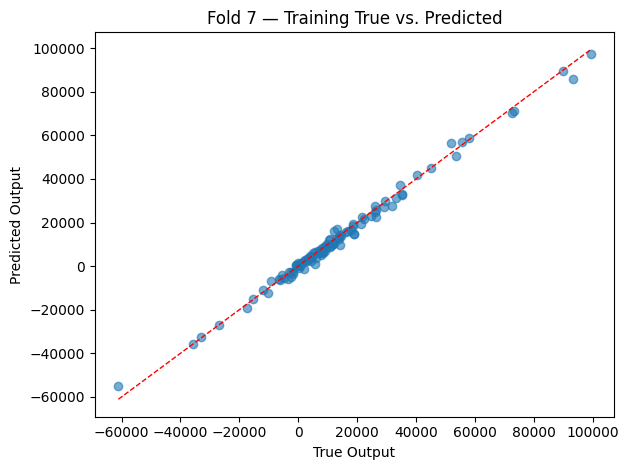

Fold 7 Validation MSE (norm): 0.1056
Fold 7 Validation R²: 0.7482, Pearson r: 0.8683


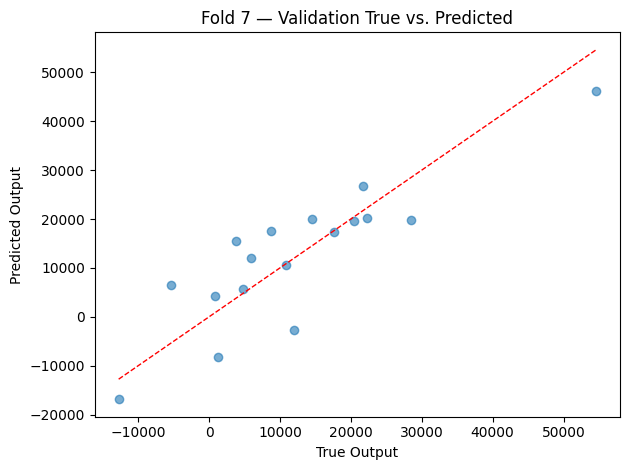


=== Validation MSE per fold ===
['0.2547', '0.5130', '0.3794', '0.9664', '0.7744', '1.2752', '0.1056']
Mean MSE (norm): 0.6098 ± 0.3854

=== Validation R² per fold ===
['-0.2737', '0.6296', '0.4767', '0.5551', '0.0137', '-0.1932', '0.7482']
Mean R²: 0.2795 ± 0.3886

=== Validation Pearson r per fold ===
['0.4525', '0.8358', '0.8304', '0.7796', '0.8366', '0.5147', '0.8683']
Mean Pearson r: 0.7311 ± 0.1593


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [14]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [12],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [16] linear


=== Fold 1/7 ===
Epoch   1/250  MSE=1.0570


Epoch  10/250  MSE=0.2752
Epoch  20/250  MSE=0.1566
Epoch  30/250  MSE=0.1343
Epoch  40/250  MSE=0.1129
Epoch  50/250  MSE=0.1072
Epoch  60/250  MSE=0.1032
Epoch  70/250  MSE=0.0972
Epoch  80/250  MSE=0.0937
Epoch  90/250  MSE=0.0950
Epoch 100/250  MSE=0.0896
Epoch 110/250  MSE=0.0892
Epoch 120/250  MSE=0.0886
Epoch 130/250  MSE=0.0867
Epoch 140/250  MSE=0.0889
Epoch 150/250  MSE=0.0842
Epoch 160/250  MSE=0.0847
Epoch 170/250  MSE=0.0822
Epoch 180/250  MSE=0.0837
Epoch 190/250  MSE=0.0816
Epoch 200/250  MSE=0.0859
Epoch 210/250  MSE=0.0821
Epoch 220/250  MSE=0.0799
Epoch 230/250  MSE=0.0788
Epoch 240/250  MSE=0.0773
Epoch 250/250  MSE=0.0784


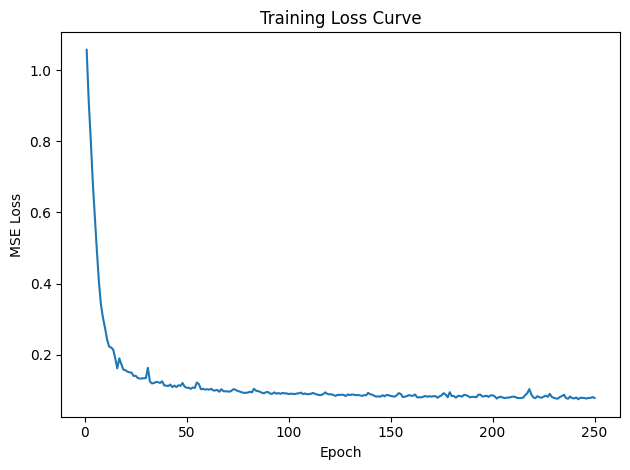

Fold 1 Training R²: 0.9362, Pearson r: 0.9677


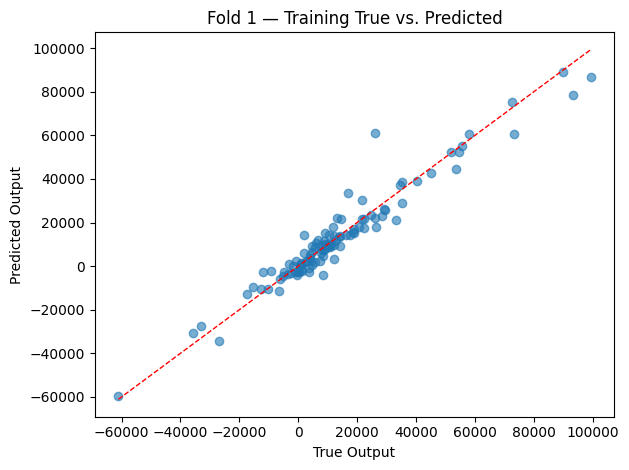

Fold 1 Validation MSE (norm): 0.1577
Fold 1 Validation R²: 0.2115, Pearson r: 0.6846


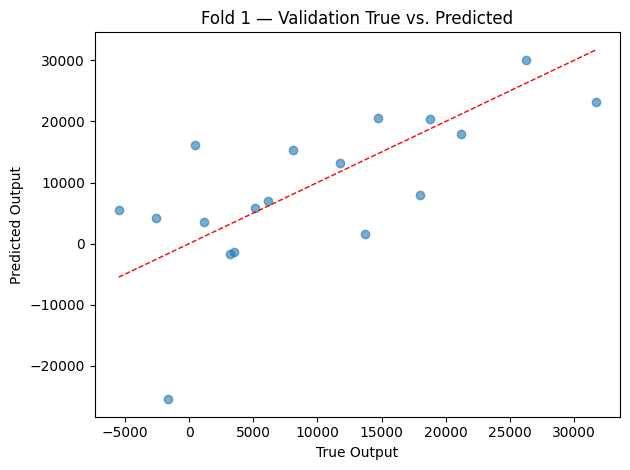


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9850
Epoch  10/250  MSE=0.2531
Epoch  20/250  MSE=0.1409
Epoch  30/250  MSE=0.1202
Epoch  40/250  MSE=0.1095
Epoch  50/250  MSE=0.1038
Epoch  60/250  MSE=0.0974
Epoch  70/250  MSE=0.1082
Epoch  80/250  MSE=0.0953
Epoch  90/250  MSE=0.0948
Epoch 100/250  MSE=0.0916
Epoch 110/250  MSE=0.0842
Epoch 120/250  MSE=0.0943
Epoch 130/250  MSE=0.0888
Epoch 140/250  MSE=0.0820
Epoch 150/250  MSE=0.0796
Epoch 160/250  MSE=0.0798
Epoch 170/250  MSE=0.0777
Epoch 180/250  MSE=0.0841
Epoch 190/250  MSE=0.0770
Epoch 200/250  MSE=0.0772
Epoch 210/250  MSE=0.0848
Epoch 220/250  MSE=0.0754
Epoch 230/250  MSE=0.0887
Epoch 240/250  MSE=0.0771
Epoch 250/250  MSE=0.0773


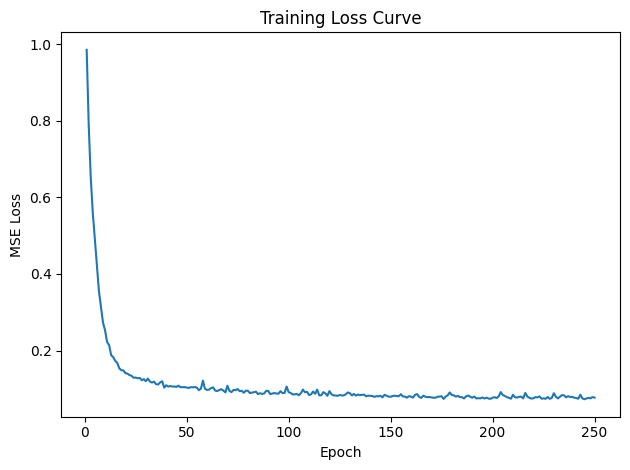

Fold 2 Training R²: 0.9234, Pearson r: 0.9610


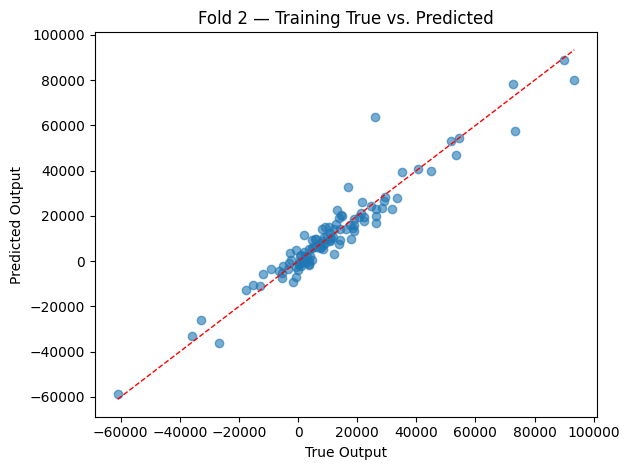

Fold 2 Validation MSE (norm): 0.1598
Fold 2 Validation R²: 0.8846, Pearson r: 0.9447


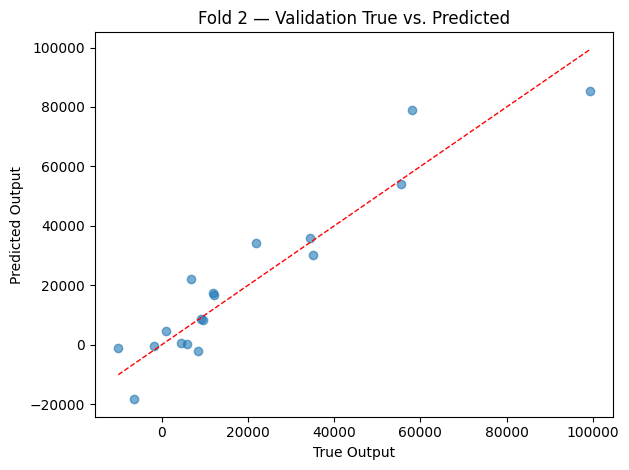


=== Fold 3/7 ===
Epoch   1/250  MSE=0.9616
Epoch  10/250  MSE=0.2330
Epoch  20/250  MSE=0.1127
Epoch  30/250  MSE=0.0851
Epoch  40/250  MSE=0.0819
Epoch  50/250  MSE=0.0762
Epoch  60/250  MSE=0.0662
Epoch  70/250  MSE=0.0670
Epoch  80/250  MSE=0.0573
Epoch  90/250  MSE=0.0554
Epoch 100/250  MSE=0.0578
Epoch 110/250  MSE=0.0553
Epoch 120/250  MSE=0.0569
Epoch 130/250  MSE=0.0582
Epoch 140/250  MSE=0.0556
Epoch 150/250  MSE=0.0588
Epoch 160/250  MSE=0.0562
Epoch 170/250  MSE=0.0524
Epoch 180/250  MSE=0.0518
Epoch 190/250  MSE=0.0522
Epoch 200/250  MSE=0.0509
Epoch 210/250  MSE=0.0538
Epoch 220/250  MSE=0.0527
Epoch 230/250  MSE=0.0555
Epoch 240/250  MSE=0.0492
Epoch 250/250  MSE=0.0505


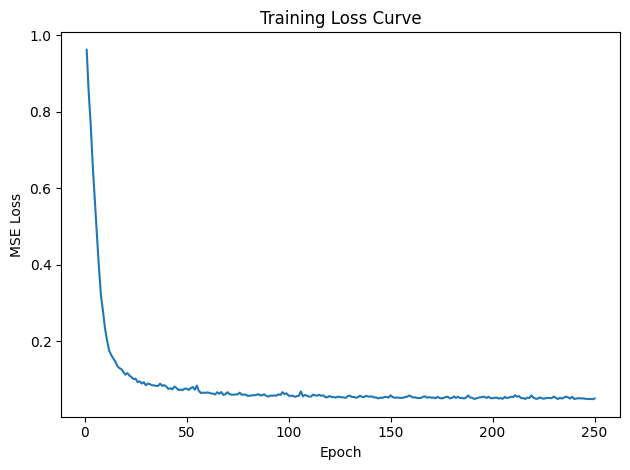

Fold 3 Training R²: 0.9548, Pearson r: 0.9773


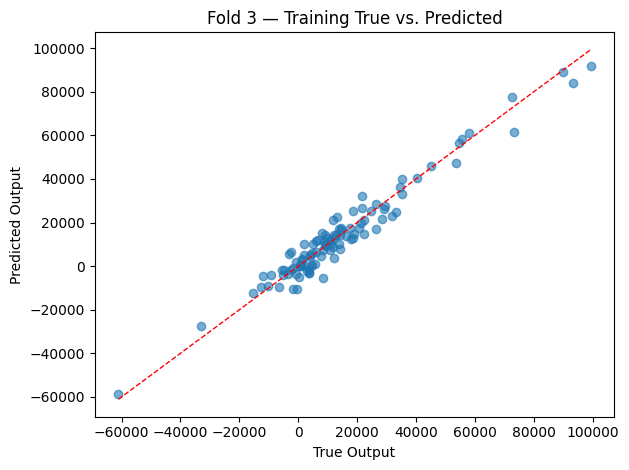

Fold 3 Validation MSE (norm): 0.3031
Fold 3 Validation R²: 0.5818, Pearson r: 0.9116


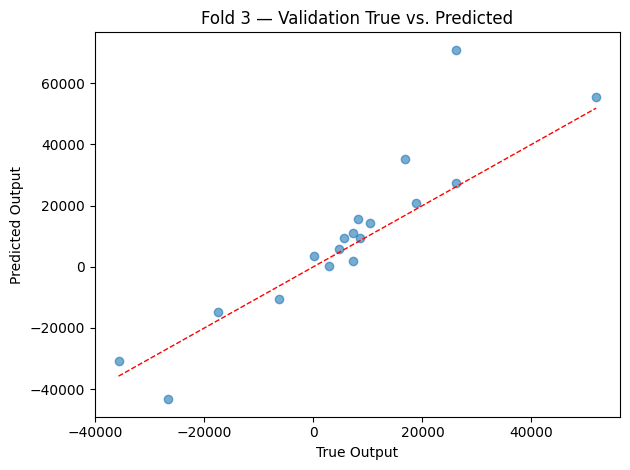


=== Fold 4/7 ===
Epoch   1/250  MSE=0.9023
Epoch  10/250  MSE=0.1863
Epoch  20/250  MSE=0.0901
Epoch  30/250  MSE=0.0813
Epoch  40/250  MSE=0.0766
Epoch  50/250  MSE=0.0748
Epoch  60/250  MSE=0.0796
Epoch  70/250  MSE=0.0804
Epoch  80/250  MSE=0.0730
Epoch  90/250  MSE=0.0745
Epoch 100/250  MSE=0.0757
Epoch 110/250  MSE=0.0811
Epoch 120/250  MSE=0.0758
Epoch 130/250  MSE=0.0725
Epoch 140/250  MSE=0.0716
Epoch 150/250  MSE=0.0719
Epoch 160/250  MSE=0.0708
Epoch 170/250  MSE=0.0703
Epoch 180/250  MSE=0.0713
Epoch 190/250  MSE=0.0706
Epoch 200/250  MSE=0.0692
Epoch 210/250  MSE=0.0706
Epoch 220/250  MSE=0.0746
Epoch 230/250  MSE=0.0706
Epoch 240/250  MSE=0.0708
Epoch 250/250  MSE=0.0749


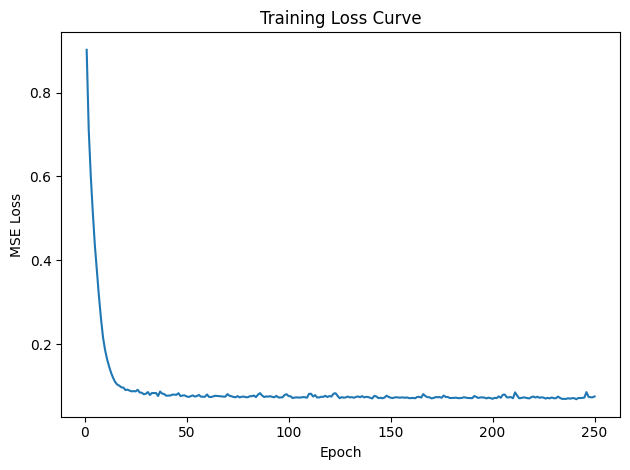

Fold 4 Training R²: 0.9146, Pearson r: 0.9564


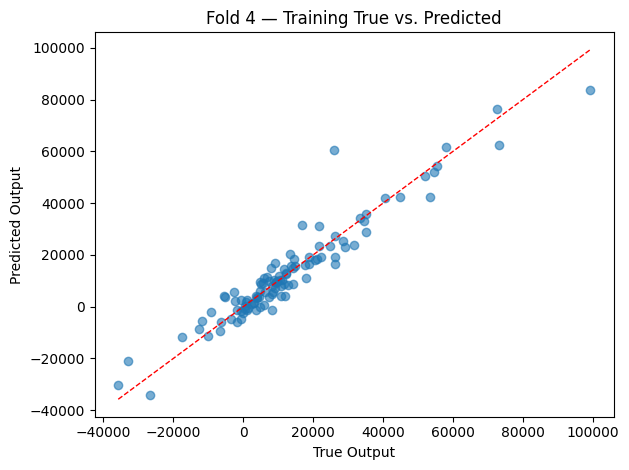

Fold 4 Validation MSE (norm): 1.0213
Fold 4 Validation R²: 0.5298, Pearson r: 0.7380


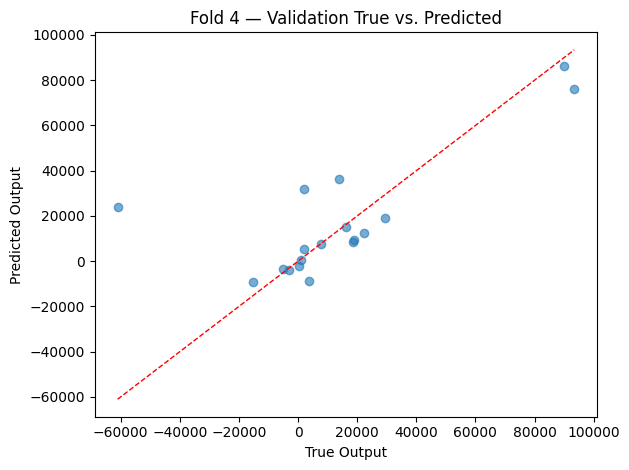


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0693
Epoch  10/250  MSE=0.2624
Epoch  20/250  MSE=0.1431
Epoch  30/250  MSE=0.1231
Epoch  40/250  MSE=0.1162
Epoch  50/250  MSE=0.1162
Epoch  60/250  MSE=0.1058
Epoch  70/250  MSE=0.0980
Epoch  80/250  MSE=0.0966
Epoch  90/250  MSE=0.0912
Epoch 100/250  MSE=0.0898
Epoch 110/250  MSE=0.0901
Epoch 120/250  MSE=0.0904
Epoch 130/250  MSE=0.0858
Epoch 140/250  MSE=0.0879
Epoch 150/250  MSE=0.0849
Epoch 160/250  MSE=0.0881
Epoch 170/250  MSE=0.0864
Epoch 180/250  MSE=0.0900
Epoch 190/250  MSE=0.0843
Epoch 200/250  MSE=0.0973
Epoch 210/250  MSE=0.0854
Epoch 220/250  MSE=0.0822
Epoch 230/250  MSE=0.0791
Epoch 240/250  MSE=0.0793
Epoch 250/250  MSE=0.0801


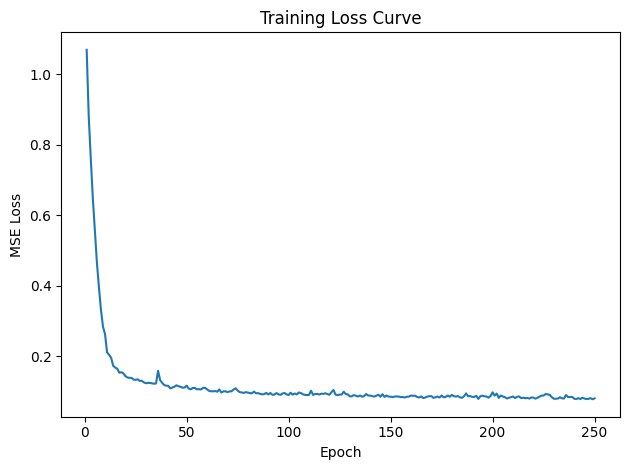

Fold 5 Training R²: 0.9281, Pearson r: 0.9635


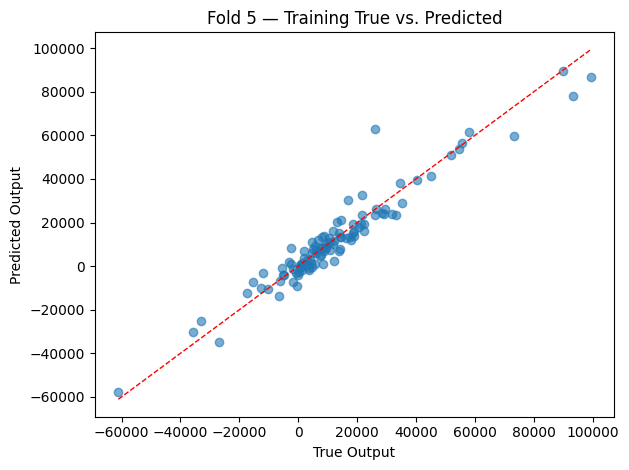

Fold 5 Validation MSE (norm): 0.1904
Fold 5 Validation R²: 0.7575, Pearson r: 0.9233


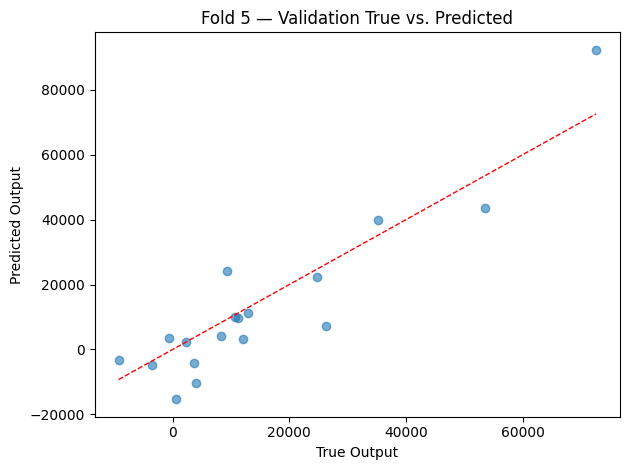


=== Fold 6/7 ===
Epoch   1/250  MSE=0.8464
Epoch  10/250  MSE=0.1633
Epoch  20/250  MSE=0.1022
Epoch  30/250  MSE=0.0882
Epoch  40/250  MSE=0.0825
Epoch  50/250  MSE=0.0865
Epoch  60/250  MSE=0.0772
Epoch  70/250  MSE=0.0826
Epoch  80/250  MSE=0.0783
Epoch  90/250  MSE=0.0753
Epoch 100/250  MSE=0.0714
Epoch 110/250  MSE=0.0784
Epoch 120/250  MSE=0.0746
Epoch 130/250  MSE=0.0731
Epoch 140/250  MSE=0.0725
Epoch 150/250  MSE=0.0688
Epoch 160/250  MSE=0.0748
Epoch 170/250  MSE=0.0711
Epoch 180/250  MSE=0.0709
Epoch 190/250  MSE=0.0743
Epoch 200/250  MSE=0.0681
Epoch 210/250  MSE=0.0694
Epoch 220/250  MSE=0.0676
Epoch 230/250  MSE=0.0702
Epoch 240/250  MSE=0.0693
Epoch 250/250  MSE=0.0697


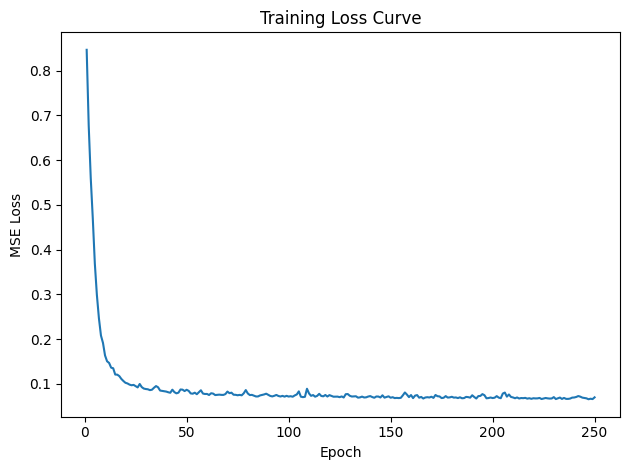

Fold 6 Training R²: 0.9367, Pearson r: 0.9680


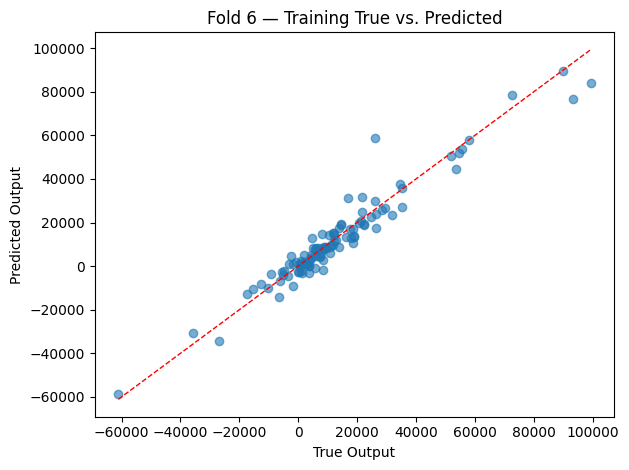

Fold 6 Validation MSE (norm): 1.0530
Fold 6 Validation R²: 0.0147, Pearson r: 0.5195


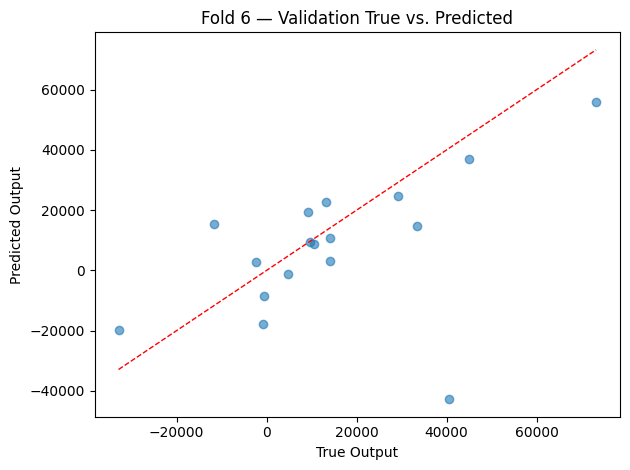


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1679
Epoch  10/250  MSE=0.2678
Epoch  20/250  MSE=0.1484
Epoch  30/250  MSE=0.1302
Epoch  40/250  MSE=0.1123
Epoch  50/250  MSE=0.1030
Epoch  60/250  MSE=0.1008
Epoch  70/250  MSE=0.0963
Epoch  80/250  MSE=0.0943
Epoch  90/250  MSE=0.0956
Epoch 100/250  MSE=0.0879
Epoch 110/250  MSE=0.0867
Epoch 120/250  MSE=0.0887
Epoch 130/250  MSE=0.0898
Epoch 140/250  MSE=0.0861
Epoch 150/250  MSE=0.0796
Epoch 160/250  MSE=0.0781
Epoch 170/250  MSE=0.0857
Epoch 180/250  MSE=0.0802
Epoch 190/250  MSE=0.0768
Epoch 200/250  MSE=0.0762
Epoch 210/250  MSE=0.0766
Epoch 220/250  MSE=0.0782
Epoch 230/250  MSE=0.0891
Epoch 240/250  MSE=0.0762
Epoch 250/250  MSE=0.0786


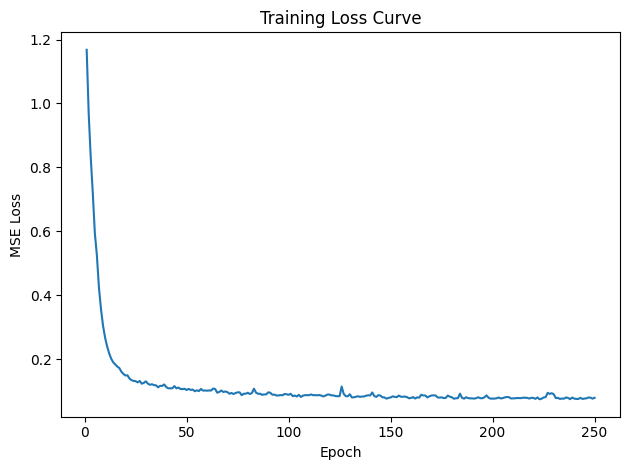

Fold 7 Training R²: 0.9351, Pearson r: 0.9672


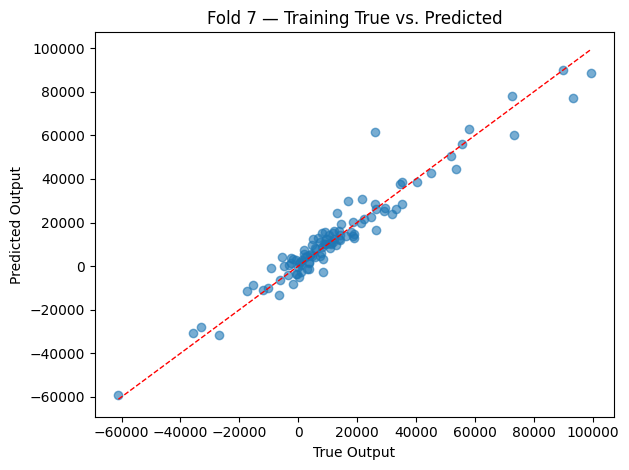

Fold 7 Validation MSE (norm): 0.2488
Fold 7 Validation R²: 0.4071, Pearson r: 0.7431


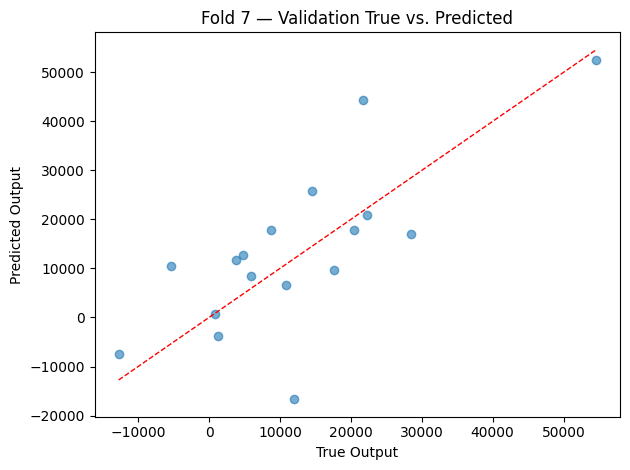


=== Validation MSE per fold ===
['0.1577', '0.1598', '0.3031', '1.0213', '0.1904', '1.0530', '0.2488']
Mean MSE (norm): 0.4477 ± 0.3759

=== Validation R² per fold ===
['0.2115', '0.8846', '0.5818', '0.5298', '0.7575', '0.0147', '0.4071']
Mean R²: 0.4839 ± 0.2796

=== Validation Pearson r per fold ===
['0.6846', '0.9447', '0.9116', '0.7380', '0.9233', '0.5195', '0.7431']
Mean Pearson r: 0.7807 ± 0.1440


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [15]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [16],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [8,8] linear


=== Fold 1/7 ===
Epoch   1/250  MSE=0.9753


Epoch  10/250  MSE=0.2218
Epoch  20/250  MSE=0.1349
Epoch  30/250  MSE=0.1149
Epoch  40/250  MSE=0.1044
Epoch  50/250  MSE=0.0974
Epoch  60/250  MSE=0.0941
Epoch  70/250  MSE=0.0973
Epoch  80/250  MSE=0.0904
Epoch  90/250  MSE=0.0860
Epoch 100/250  MSE=0.0895
Epoch 110/250  MSE=0.0845
Epoch 120/250  MSE=0.0886
Epoch 130/250  MSE=0.0854
Epoch 140/250  MSE=0.0835
Epoch 150/250  MSE=0.0790
Epoch 160/250  MSE=0.0824
Epoch 170/250  MSE=0.0908
Epoch 180/250  MSE=0.0817
Epoch 190/250  MSE=0.0787
Epoch 200/250  MSE=0.0806
Epoch 210/250  MSE=0.0834
Epoch 220/250  MSE=0.0814
Epoch 230/250  MSE=0.0837
Epoch 240/250  MSE=0.0861
Epoch 250/250  MSE=0.0867


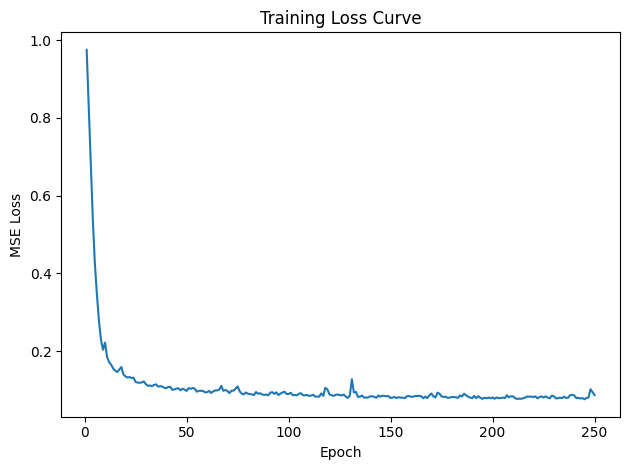

Fold 1 Training R²: 0.9337, Pearson r: 0.9671


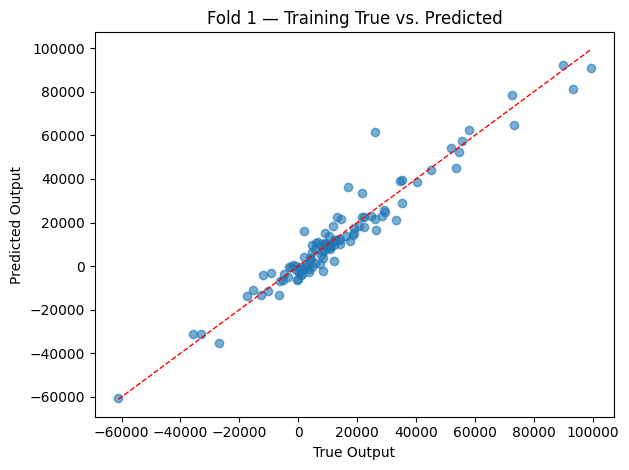

Fold 1 Validation MSE (norm): 0.1683
Fold 1 Validation R²: 0.1582, Pearson r: 0.6932


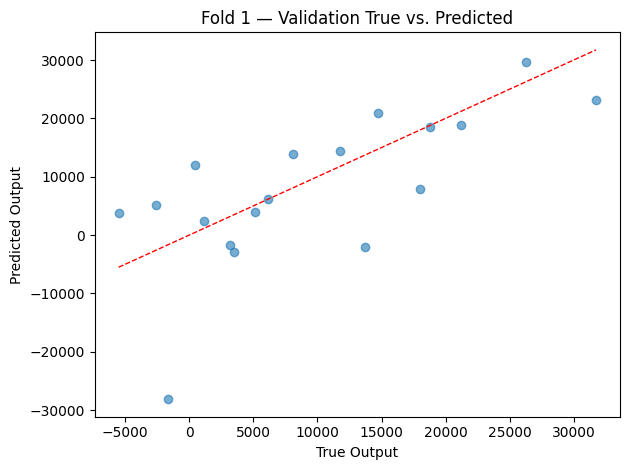


=== Fold 2/7 ===
Epoch   1/250  MSE=0.8473
Epoch  10/250  MSE=0.2086
Epoch  20/250  MSE=0.1336
Epoch  30/250  MSE=0.1176
Epoch  40/250  MSE=0.1060
Epoch  50/250  MSE=0.1039
Epoch  60/250  MSE=0.1019
Epoch  70/250  MSE=0.0918
Epoch  80/250  MSE=0.0914
Epoch  90/250  MSE=0.0902
Epoch 100/250  MSE=0.0877
Epoch 110/250  MSE=0.0842
Epoch 120/250  MSE=0.0840
Epoch 130/250  MSE=0.0826
Epoch 140/250  MSE=0.0823
Epoch 150/250  MSE=0.0819
Epoch 160/250  MSE=0.0781
Epoch 170/250  MSE=0.0809
Epoch 180/250  MSE=0.0874
Epoch 190/250  MSE=0.0773
Epoch 200/250  MSE=0.0773
Epoch 210/250  MSE=0.0816
Epoch 220/250  MSE=0.0823
Epoch 230/250  MSE=0.0757
Epoch 240/250  MSE=0.0815
Epoch 250/250  MSE=0.0756


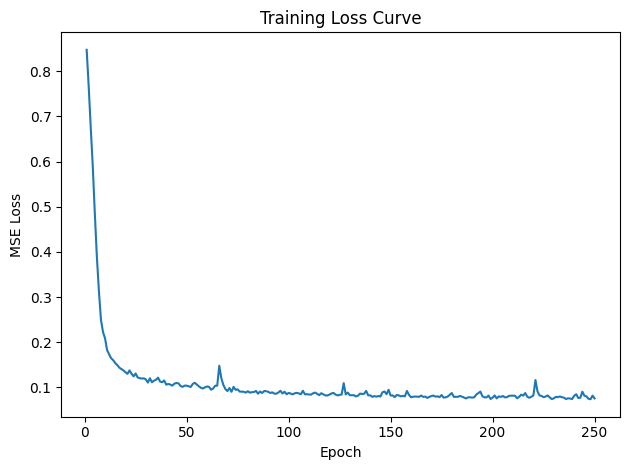

Fold 2 Training R²: 0.9232, Pearson r: 0.9613


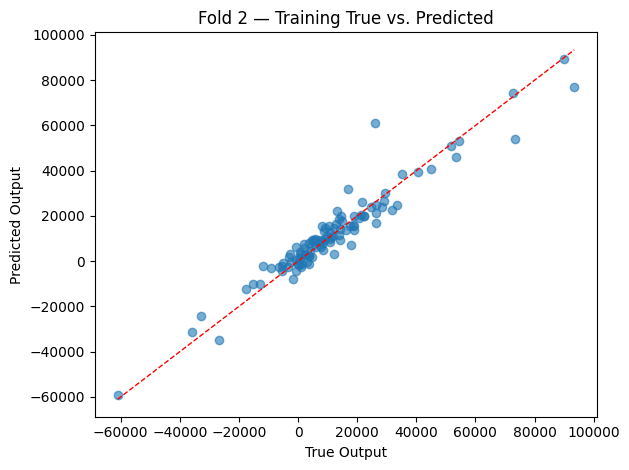

Fold 2 Validation MSE (norm): 0.1827
Fold 2 Validation R²: 0.8681, Pearson r: 0.9340


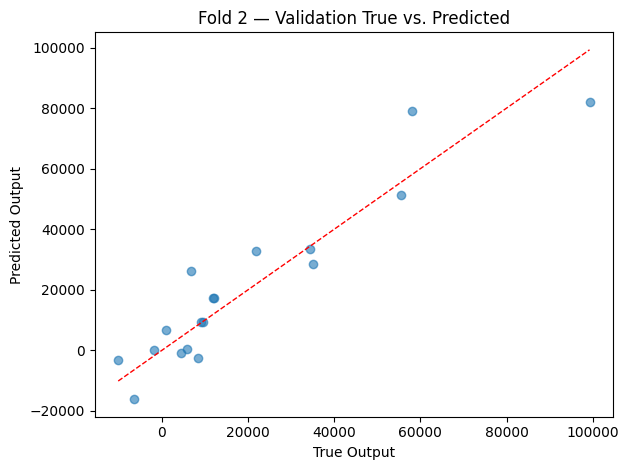


=== Fold 3/7 ===
Epoch   1/250  MSE=0.9898
Epoch  10/250  MSE=0.2536
Epoch  20/250  MSE=0.1160
Epoch  30/250  MSE=0.0884
Epoch  40/250  MSE=0.0780
Epoch  50/250  MSE=0.0679
Epoch  60/250  MSE=0.0630
Epoch  70/250  MSE=0.0629
Epoch  80/250  MSE=0.0596
Epoch  90/250  MSE=0.0596
Epoch 100/250  MSE=0.0574
Epoch 110/250  MSE=0.0567
Epoch 120/250  MSE=0.0623
Epoch 130/250  MSE=0.0523
Epoch 140/250  MSE=0.0565
Epoch 150/250  MSE=0.0604
Epoch 160/250  MSE=0.0563
Epoch 170/250  MSE=0.0563
Epoch 180/250  MSE=0.0518
Epoch 190/250  MSE=0.0544
Epoch 200/250  MSE=0.0502
Epoch 210/250  MSE=0.0535
Epoch 220/250  MSE=0.0544
Epoch 230/250  MSE=0.0511
Epoch 240/250  MSE=0.0586
Epoch 250/250  MSE=0.0648


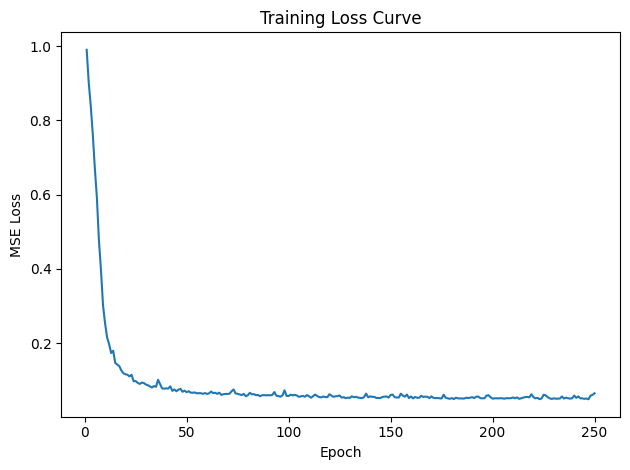

Fold 3 Training R²: 0.9495, Pearson r: 0.9765


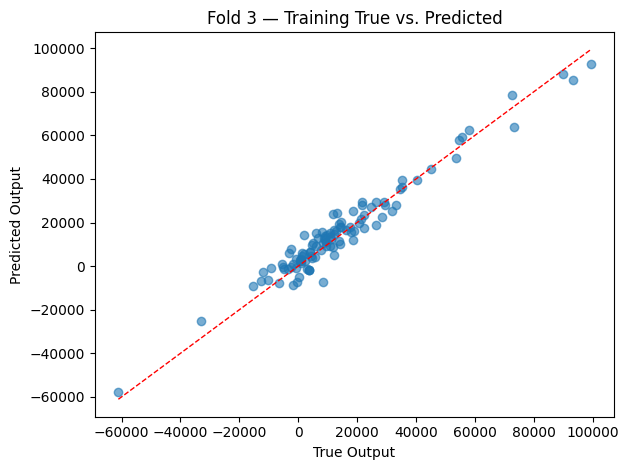

Fold 3 Validation MSE (norm): 0.3351
Fold 3 Validation R²: 0.5378, Pearson r: 0.9108


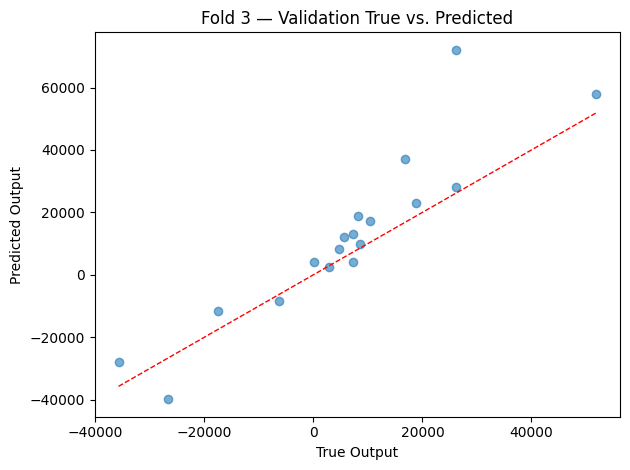


=== Fold 4/7 ===
Epoch   1/250  MSE=0.7879
Epoch  10/250  MSE=0.1521
Epoch  20/250  MSE=0.0863
Epoch  30/250  MSE=0.0791
Epoch  40/250  MSE=0.0789
Epoch  50/250  MSE=0.0758
Epoch  60/250  MSE=0.0739
Epoch  70/250  MSE=0.0741
Epoch  80/250  MSE=0.0776
Epoch  90/250  MSE=0.0734
Epoch 100/250  MSE=0.0710
Epoch 110/250  MSE=0.0809
Epoch 120/250  MSE=0.0718
Epoch 130/250  MSE=0.0730
Epoch 140/250  MSE=0.0745
Epoch 150/250  MSE=0.0725
Epoch 160/250  MSE=0.0798
Epoch 170/250  MSE=0.0872
Epoch 180/250  MSE=0.0712
Epoch 190/250  MSE=0.0734
Epoch 200/250  MSE=0.0708
Epoch 210/250  MSE=0.0695
Epoch 220/250  MSE=0.0884
Epoch 230/250  MSE=0.0736
Epoch 240/250  MSE=0.0700
Epoch 250/250  MSE=0.0705


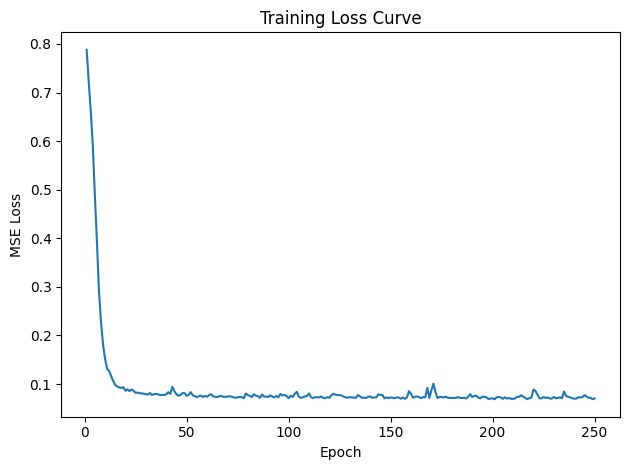

Fold 4 Training R²: 0.9165, Pearson r: 0.9574


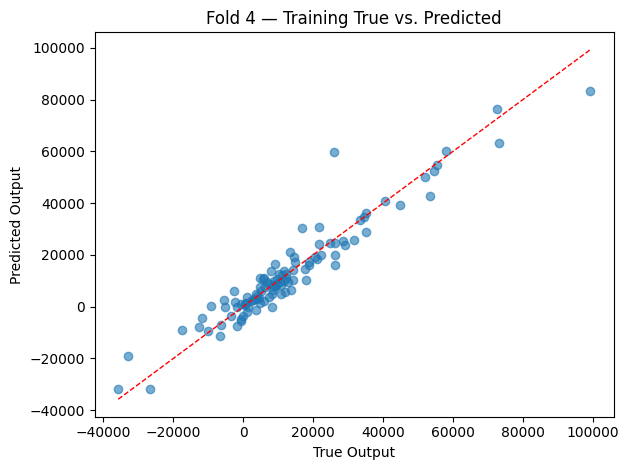

Fold 4 Validation MSE (norm): 1.1125
Fold 4 Validation R²: 0.4879, Pearson r: 0.7125


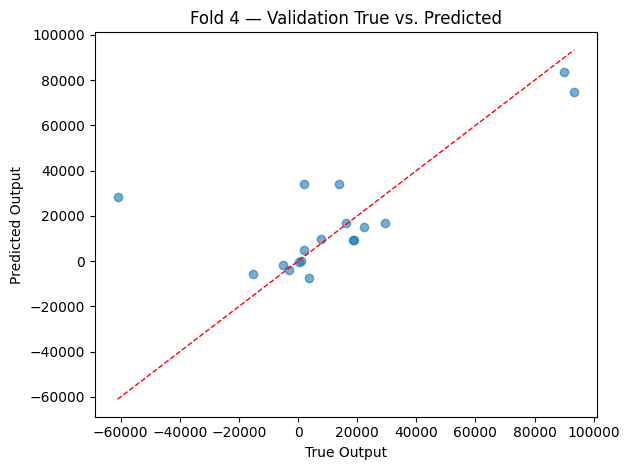


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0526
Epoch  10/250  MSE=0.2275
Epoch  20/250  MSE=0.1445
Epoch  30/250  MSE=0.1309
Epoch  40/250  MSE=0.1110
Epoch  50/250  MSE=0.1112
Epoch  60/250  MSE=0.1024
Epoch  70/250  MSE=0.1009
Epoch  80/250  MSE=0.1028
Epoch  90/250  MSE=0.0974
Epoch 100/250  MSE=0.0993
Epoch 110/250  MSE=0.0978
Epoch 120/250  MSE=0.0884
Epoch 130/250  MSE=0.0918
Epoch 140/250  MSE=0.0864
Epoch 150/250  MSE=0.0850
Epoch 160/250  MSE=0.0851
Epoch 170/250  MSE=0.0863
Epoch 180/250  MSE=0.0868
Epoch 190/250  MSE=0.0824
Epoch 200/250  MSE=0.0857
Epoch 210/250  MSE=0.0827
Epoch 220/250  MSE=0.0849
Epoch 230/250  MSE=0.0790
Epoch 240/250  MSE=0.0801
Epoch 250/250  MSE=0.0798


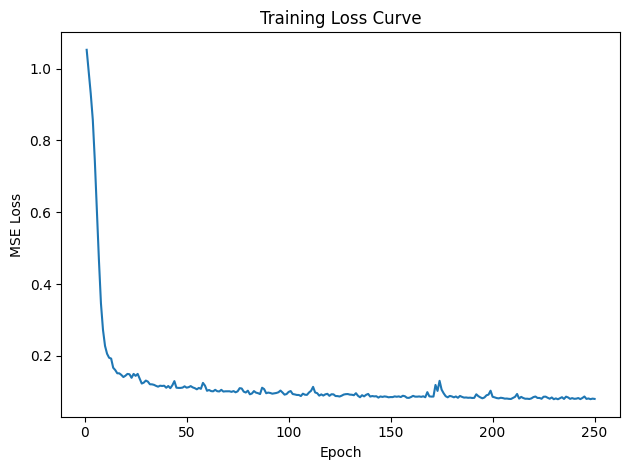

Fold 5 Training R²: 0.9278, Pearson r: 0.9633


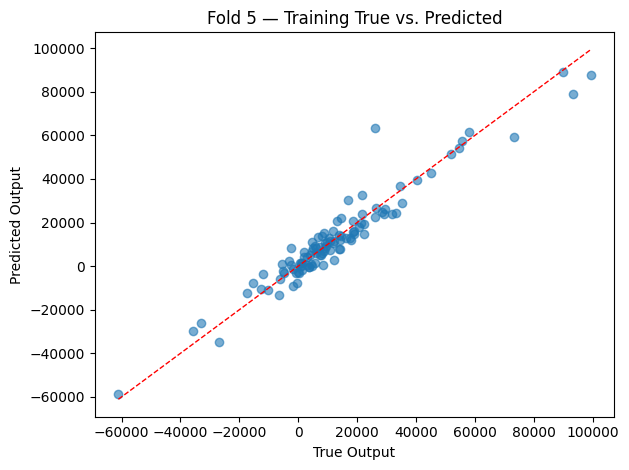

Fold 5 Validation MSE (norm): 0.1876
Fold 5 Validation R²: 0.7610, Pearson r: 0.9226


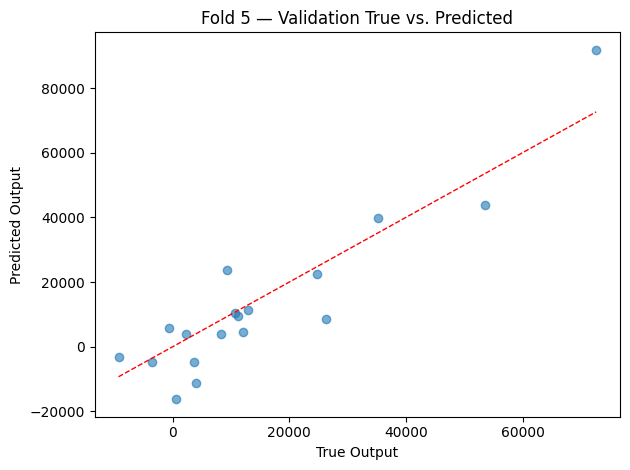


=== Fold 6/7 ===
Epoch   1/250  MSE=0.9533
Epoch  10/250  MSE=0.1715
Epoch  20/250  MSE=0.1051
Epoch  30/250  MSE=0.0874
Epoch  40/250  MSE=0.0801
Epoch  50/250  MSE=0.0797
Epoch  60/250  MSE=0.0766
Epoch  70/250  MSE=0.0811
Epoch  80/250  MSE=0.0719
Epoch  90/250  MSE=0.0729
Epoch 100/250  MSE=0.0722
Epoch 110/250  MSE=0.0713
Epoch 120/250  MSE=0.0691
Epoch 130/250  MSE=0.0696
Epoch 140/250  MSE=0.0702
Epoch 150/250  MSE=0.0830
Epoch 160/250  MSE=0.0741
Epoch 170/250  MSE=0.0715
Epoch 180/250  MSE=0.0692
Epoch 190/250  MSE=0.0692
Epoch 200/250  MSE=0.0686
Epoch 210/250  MSE=0.0709
Epoch 220/250  MSE=0.0696
Epoch 230/250  MSE=0.0680
Epoch 240/250  MSE=0.0678
Epoch 250/250  MSE=0.0704


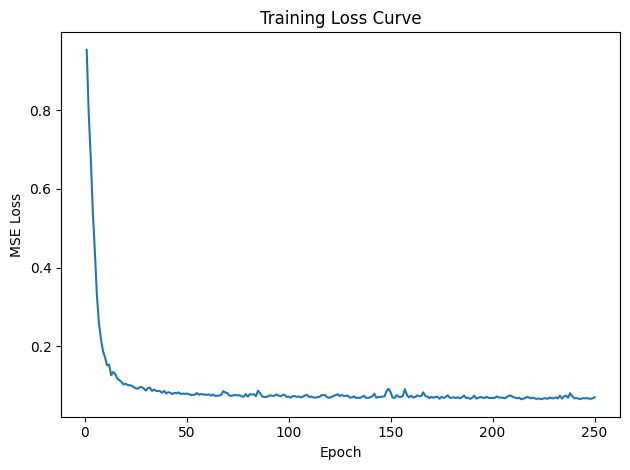

Fold 6 Training R²: 0.9365, Pearson r: 0.9678


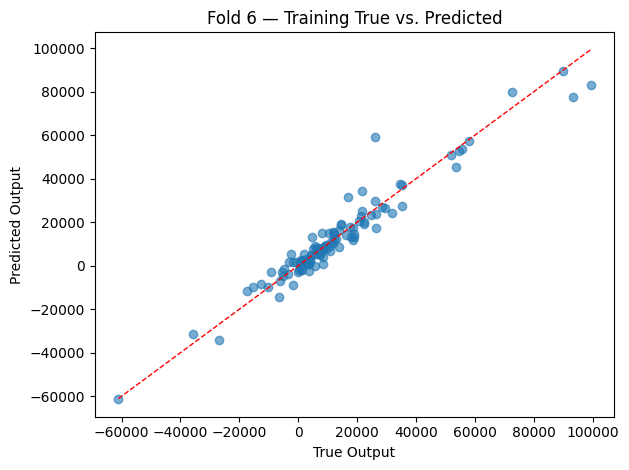

Fold 6 Validation MSE (norm): 1.0829
Fold 6 Validation R²: -0.0133, Pearson r: 0.5113


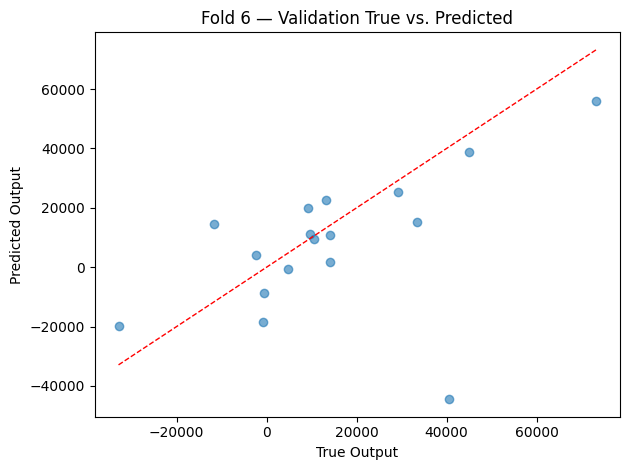


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1548
Epoch  10/250  MSE=0.4152
Epoch  20/250  MSE=0.1659
Epoch  30/250  MSE=0.1296
Epoch  40/250  MSE=0.1174
Epoch  50/250  MSE=0.1113
Epoch  60/250  MSE=0.1071
Epoch  70/250  MSE=0.1010
Epoch  80/250  MSE=0.0928
Epoch  90/250  MSE=0.0940
Epoch 100/250  MSE=0.0864
Epoch 110/250  MSE=0.0894
Epoch 120/250  MSE=0.0901
Epoch 130/250  MSE=0.0850
Epoch 140/250  MSE=0.0808
Epoch 150/250  MSE=0.0843
Epoch 160/250  MSE=0.0799
Epoch 170/250  MSE=0.0847
Epoch 180/250  MSE=0.0842
Epoch 190/250  MSE=0.0809
Epoch 200/250  MSE=0.0787
Epoch 210/250  MSE=0.0803
Epoch 220/250  MSE=0.0763
Epoch 230/250  MSE=0.0807
Epoch 240/250  MSE=0.0780
Epoch 250/250  MSE=0.0814


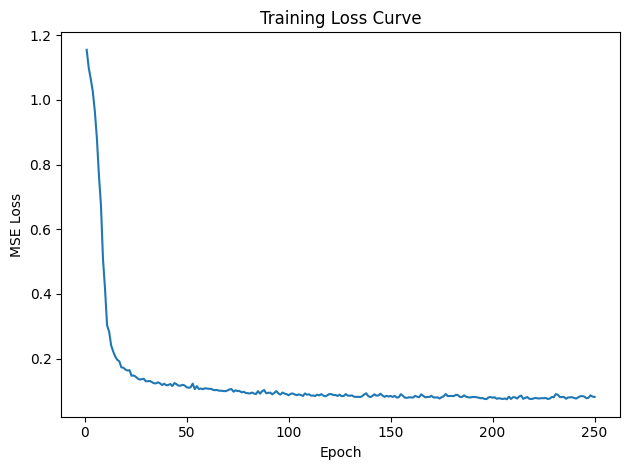

Fold 7 Training R²: 0.9349, Pearson r: 0.9672


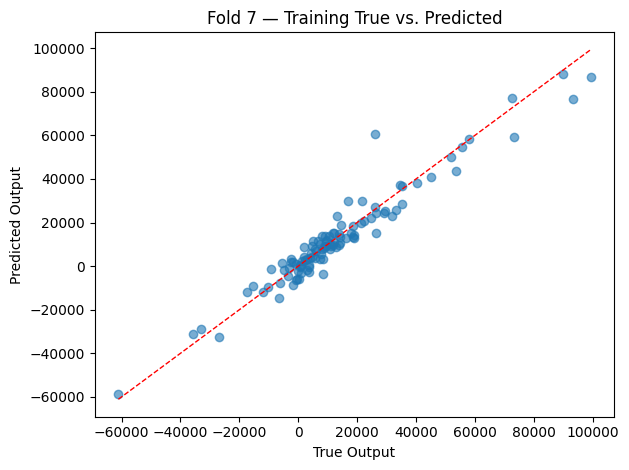

Fold 7 Validation MSE (norm): 0.2214
Fold 7 Validation R²: 0.4723, Pearson r: 0.7630


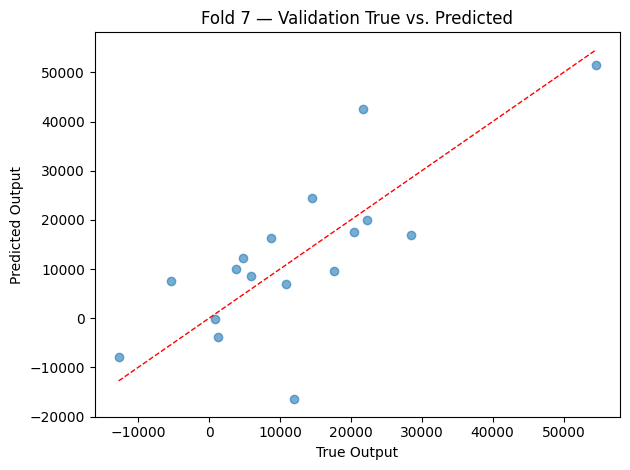


=== Validation MSE per fold ===
['0.1683', '0.1827', '0.3351', '1.1125', '0.1876', '1.0829', '0.2214']
Mean MSE (norm): 0.4701 ± 0.4003

=== Validation R² per fold ===
['0.1582', '0.8681', '0.5378', '0.4879', '0.7610', '-0.0133', '0.4723']
Mean R²: 0.4674 ± 0.2876

=== Validation Pearson r per fold ===
['0.6932', '0.9340', '0.9108', '0.7125', '0.9226', '0.5113', '0.7630']
Mean Pearson r: 0.7782 ± 0.1443


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [16]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [8,8],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [16,8,4] linear 


=== Fold 1/7 ===


Epoch   1/250  MSE=1.1220
Epoch  10/250  MSE=0.2165
Epoch  20/250  MSE=0.1333
Epoch  30/250  MSE=0.1147
Epoch  40/250  MSE=0.1043
Epoch  50/250  MSE=0.1020
Epoch  60/250  MSE=0.1008
Epoch  70/250  MSE=0.0923
Epoch  80/250  MSE=0.0940
Epoch  90/250  MSE=0.0853
Epoch 100/250  MSE=0.0883
Epoch 110/250  MSE=0.0871
Epoch 120/250  MSE=0.0853
Epoch 130/250  MSE=0.0887
Epoch 140/250  MSE=0.0822
Epoch 150/250  MSE=0.0928
Epoch 160/250  MSE=0.0820
Epoch 170/250  MSE=0.0895
Epoch 180/250  MSE=0.0884
Epoch 190/250  MSE=0.0854
Epoch 200/250  MSE=0.0830
Epoch 210/250  MSE=0.0837
Epoch 220/250  MSE=0.0791
Epoch 230/250  MSE=0.0809
Epoch 240/250  MSE=0.0791
Epoch 250/250  MSE=0.0820


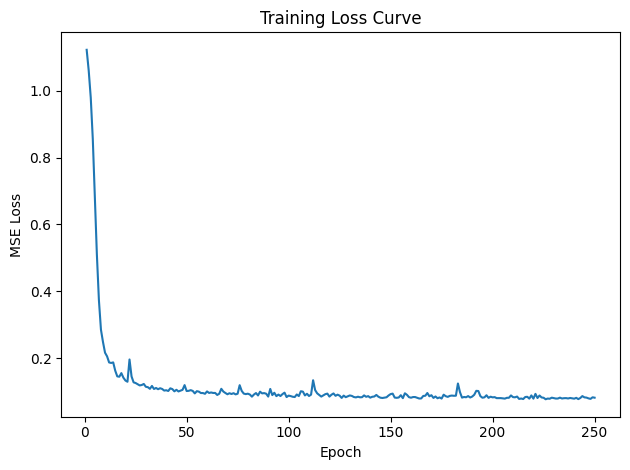

Fold 1 Training R²: 0.9357, Pearson r: 0.9674


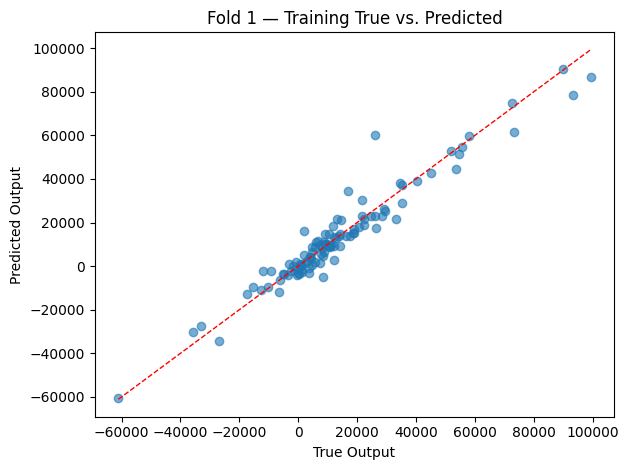

Fold 1 Validation MSE (norm): 0.1459
Fold 1 Validation R²: 0.2706, Pearson r: 0.7004


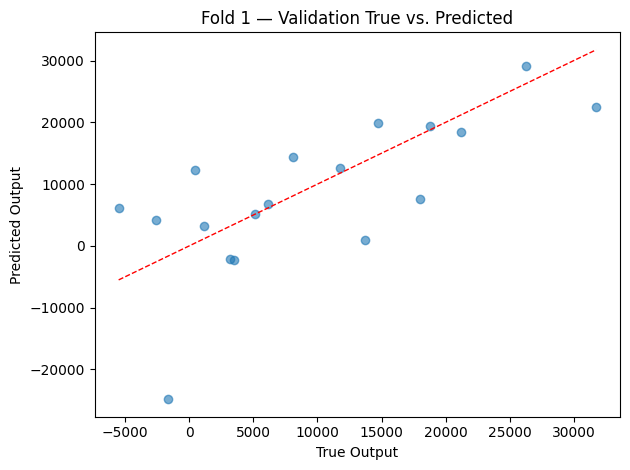


=== Fold 2/7 ===
Epoch   1/250  MSE=1.0882
Epoch  10/250  MSE=0.2154
Epoch  20/250  MSE=0.1368
Epoch  30/250  MSE=0.1180
Epoch  40/250  MSE=0.1074
Epoch  50/250  MSE=0.1031
Epoch  60/250  MSE=0.0982
Epoch  70/250  MSE=0.1025
Epoch  80/250  MSE=0.0952
Epoch  90/250  MSE=0.0904
Epoch 100/250  MSE=0.0908
Epoch 110/250  MSE=0.0924
Epoch 120/250  MSE=0.0833
Epoch 130/250  MSE=0.0839
Epoch 140/250  MSE=0.0828
Epoch 150/250  MSE=0.0851
Epoch 160/250  MSE=0.0775
Epoch 170/250  MSE=0.0804
Epoch 180/250  MSE=0.0785
Epoch 190/250  MSE=0.0771
Epoch 200/250  MSE=0.0791
Epoch 210/250  MSE=0.0795
Epoch 220/250  MSE=0.0780
Epoch 230/250  MSE=0.0836
Epoch 240/250  MSE=0.0818
Epoch 250/250  MSE=0.0892


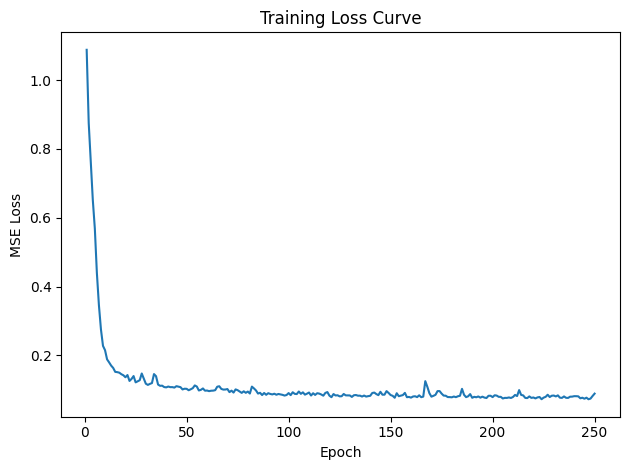

Fold 2 Training R²: 0.9216, Pearson r: 0.9613


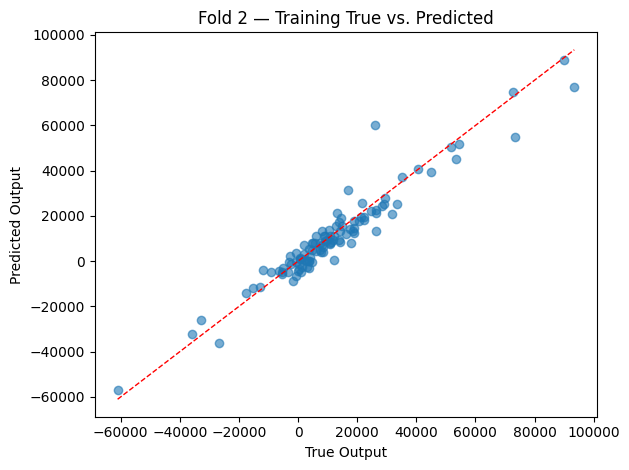

Fold 2 Validation MSE (norm): 0.1786
Fold 2 Validation R²: 0.8711, Pearson r: 0.9366


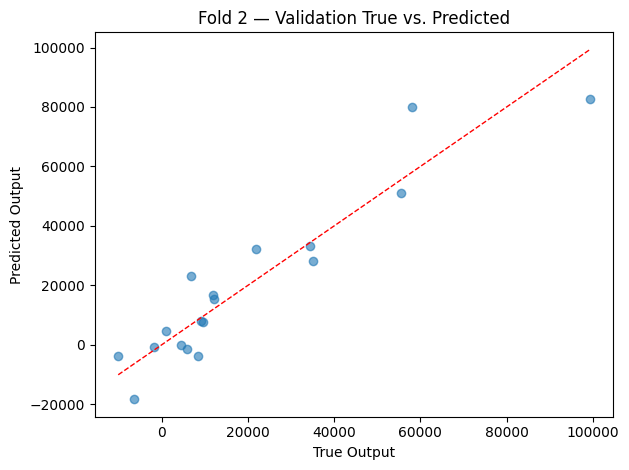


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0756
Epoch  10/250  MSE=0.2274
Epoch  20/250  MSE=0.1042
Epoch  30/250  MSE=0.0820
Epoch  40/250  MSE=0.0695
Epoch  50/250  MSE=0.0624
Epoch  60/250  MSE=0.0620
Epoch  70/250  MSE=0.0654
Epoch  80/250  MSE=0.0608
Epoch  90/250  MSE=0.0585
Epoch 100/250  MSE=0.0604
Epoch 110/250  MSE=0.0518
Epoch 120/250  MSE=0.0575
Epoch 130/250  MSE=0.0609
Epoch 140/250  MSE=0.0546
Epoch 150/250  MSE=0.0610
Epoch 160/250  MSE=0.0524
Epoch 170/250  MSE=0.0587
Epoch 180/250  MSE=0.0509
Epoch 190/250  MSE=0.0561
Epoch 200/250  MSE=0.0533
Epoch 210/250  MSE=0.0510
Epoch 220/250  MSE=0.0549
Epoch 230/250  MSE=0.0550
Epoch 240/250  MSE=0.0517
Epoch 250/250  MSE=0.0531


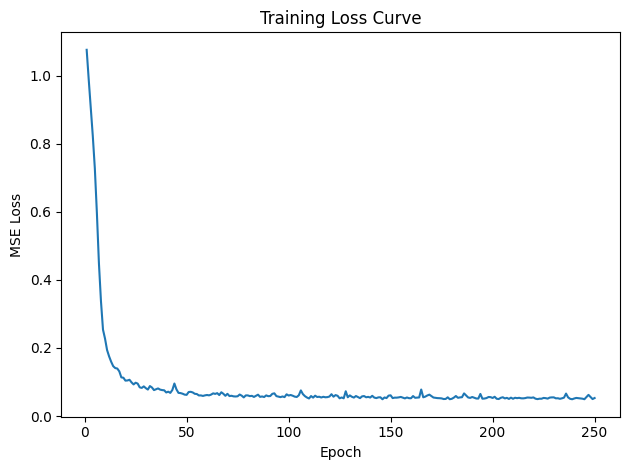

Fold 3 Training R²: 0.9539, Pearson r: 0.9768


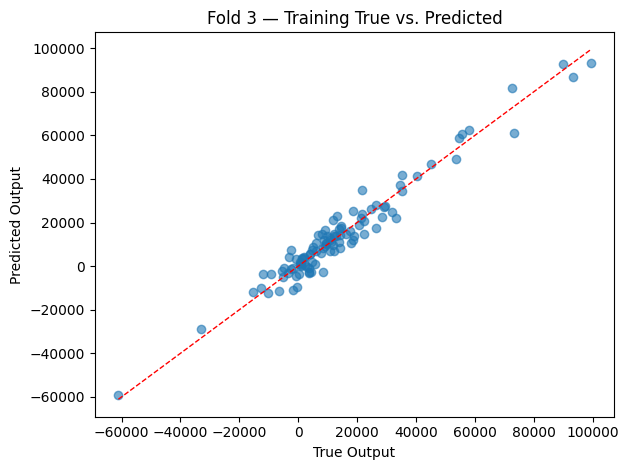

Fold 3 Validation MSE (norm): 0.3287
Fold 3 Validation R²: 0.5465, Pearson r: 0.9126


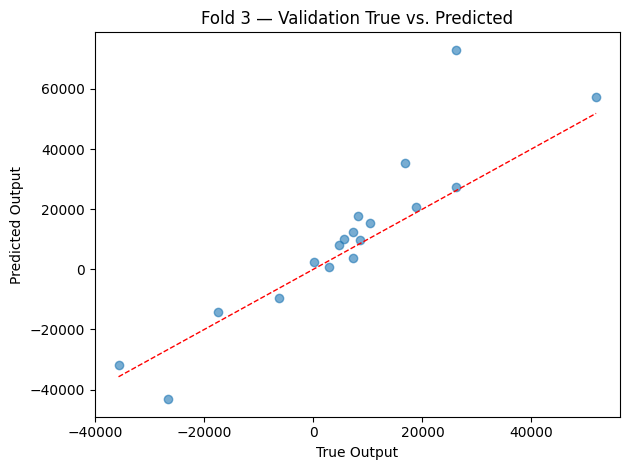


=== Fold 4/7 ===
Epoch   1/250  MSE=0.9277
Epoch  10/250  MSE=0.1090
Epoch  20/250  MSE=0.0942
Epoch  30/250  MSE=0.0805
Epoch  40/250  MSE=0.0798
Epoch  50/250  MSE=0.0758
Epoch  60/250  MSE=0.0820
Epoch  70/250  MSE=0.0784
Epoch  80/250  MSE=0.0886
Epoch  90/250  MSE=0.0773
Epoch 100/250  MSE=0.0721
Epoch 110/250  MSE=0.0712
Epoch 120/250  MSE=0.0720
Epoch 130/250  MSE=0.0748
Epoch 140/250  MSE=0.0810
Epoch 150/250  MSE=0.0714
Epoch 160/250  MSE=0.0757
Epoch 170/250  MSE=0.0725
Epoch 180/250  MSE=0.0692
Epoch 190/250  MSE=0.0718
Epoch 200/250  MSE=0.0704
Epoch 210/250  MSE=0.0765
Epoch 220/250  MSE=0.0720
Epoch 230/250  MSE=0.0715
Epoch 240/250  MSE=0.0729
Epoch 250/250  MSE=0.0740


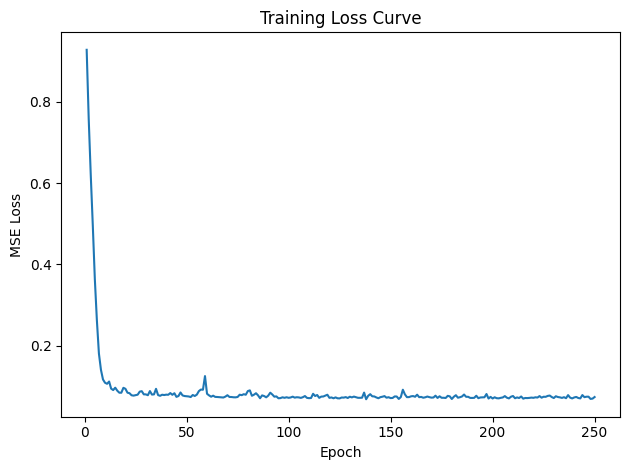

Fold 4 Training R²: 0.9177, Pearson r: 0.9580


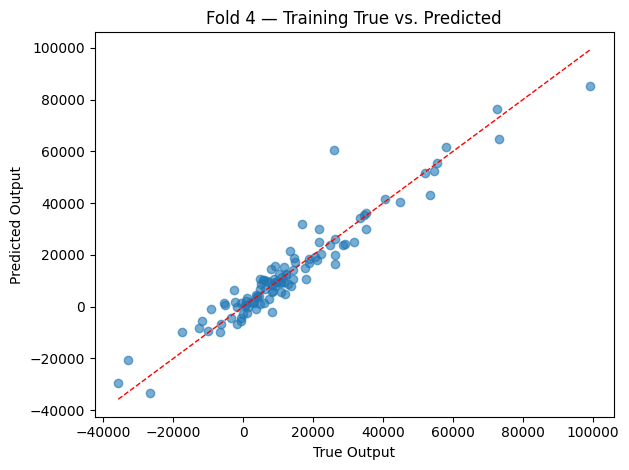

Fold 4 Validation MSE (norm): 1.1200
Fold 4 Validation R²: 0.4844, Pearson r: 0.7138


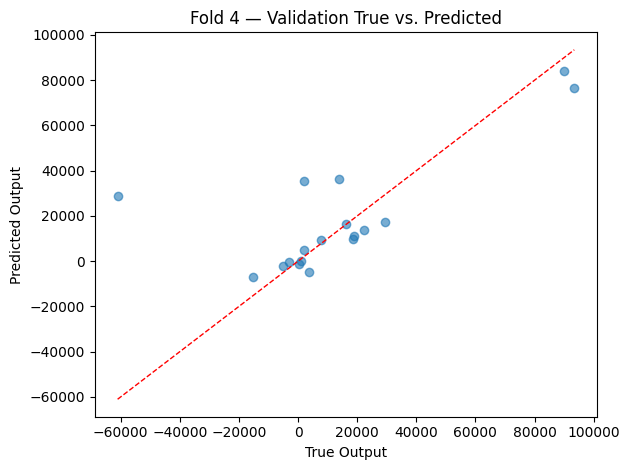


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0566
Epoch  10/250  MSE=0.2059
Epoch  20/250  MSE=0.1452
Epoch  30/250  MSE=0.1314
Epoch  40/250  MSE=0.1194
Epoch  50/250  MSE=0.1080
Epoch  60/250  MSE=0.1107
Epoch  70/250  MSE=0.0978
Epoch  80/250  MSE=0.0995
Epoch  90/250  MSE=0.0930
Epoch 100/250  MSE=0.0925
Epoch 110/250  MSE=0.1018
Epoch 120/250  MSE=0.1085
Epoch 130/250  MSE=0.0910
Epoch 140/250  MSE=0.1190
Epoch 150/250  MSE=0.0877
Epoch 160/250  MSE=0.0871
Epoch 170/250  MSE=0.0946
Epoch 180/250  MSE=0.0877
Epoch 190/250  MSE=0.0838
Epoch 200/250  MSE=0.0860
Epoch 210/250  MSE=0.0856
Epoch 220/250  MSE=0.0828
Epoch 230/250  MSE=0.0867
Epoch 240/250  MSE=0.0776
Epoch 250/250  MSE=0.0812


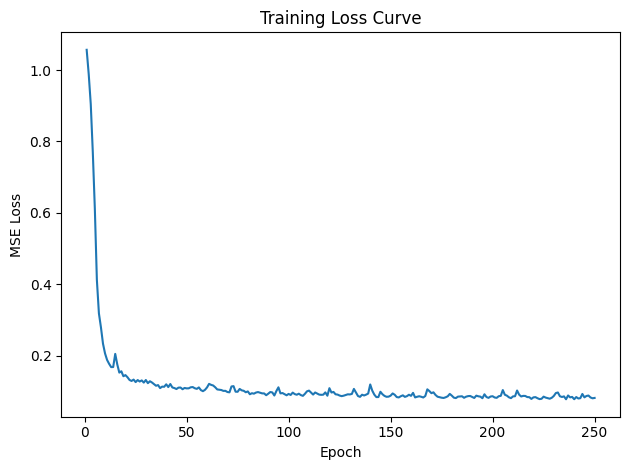

Fold 5 Training R²: 0.9284, Pearson r: 0.9636


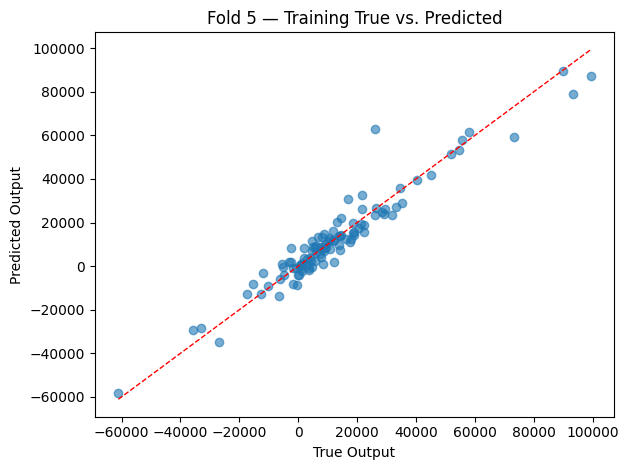

Fold 5 Validation MSE (norm): 0.2078
Fold 5 Validation R²: 0.7353, Pearson r: 0.9199


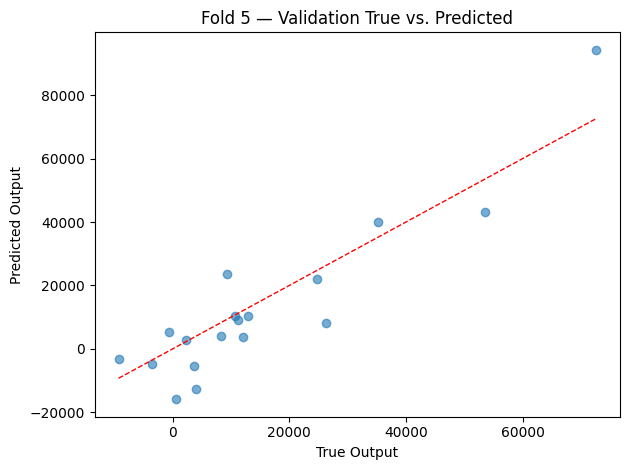


=== Fold 6/7 ===
Epoch   1/250  MSE=0.9752
Epoch  10/250  MSE=0.1480
Epoch  20/250  MSE=0.1037
Epoch  30/250  MSE=0.0877
Epoch  40/250  MSE=0.0814
Epoch  50/250  MSE=0.0779
Epoch  60/250  MSE=0.0751
Epoch  70/250  MSE=0.0755
Epoch  80/250  MSE=0.0726
Epoch  90/250  MSE=0.0741
Epoch 100/250  MSE=0.0736
Epoch 110/250  MSE=0.0766
Epoch 120/250  MSE=0.0764
Epoch 130/250  MSE=0.0697
Epoch 140/250  MSE=0.0747
Epoch 150/250  MSE=0.0702
Epoch 160/250  MSE=0.0815
Epoch 170/250  MSE=0.0712
Epoch 180/250  MSE=0.0808
Epoch 190/250  MSE=0.0697
Epoch 200/250  MSE=0.0703
Epoch 210/250  MSE=0.0723
Epoch 220/250  MSE=0.0702
Epoch 230/250  MSE=0.0677
Epoch 240/250  MSE=0.0734
Epoch 250/250  MSE=0.0666


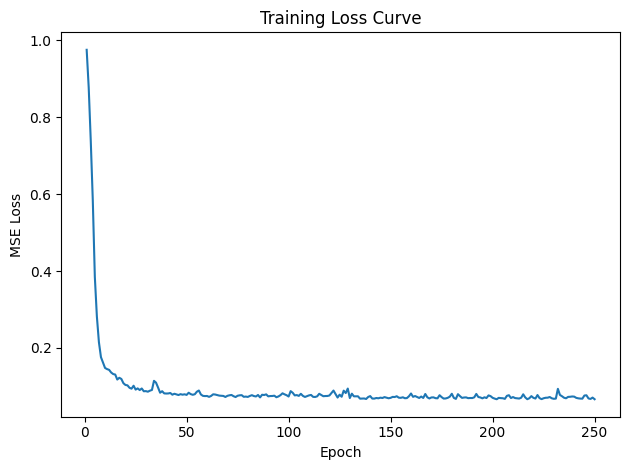

Fold 6 Training R²: 0.9359, Pearson r: 0.9678


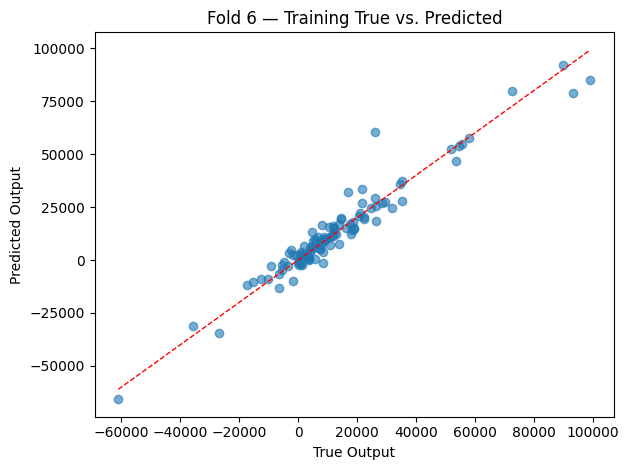

Fold 6 Validation MSE (norm): 1.1464
Fold 6 Validation R²: -0.0727, Pearson r: 0.4967


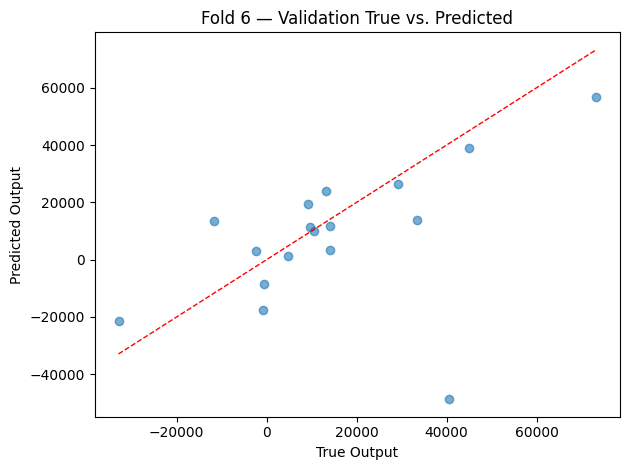


=== Fold 7/7 ===
Epoch   1/250  MSE=1.0763
Epoch  10/250  MSE=0.2110
Epoch  20/250  MSE=0.1415
Epoch  30/250  MSE=0.1233
Epoch  40/250  MSE=0.1195
Epoch  50/250  MSE=0.1128
Epoch  60/250  MSE=0.1056
Epoch  70/250  MSE=0.1003
Epoch  80/250  MSE=0.0905
Epoch  90/250  MSE=0.0876
Epoch 100/250  MSE=0.0863
Epoch 110/250  MSE=0.0906
Epoch 120/250  MSE=0.0803
Epoch 130/250  MSE=0.0805
Epoch 140/250  MSE=0.0872
Epoch 150/250  MSE=0.0808
Epoch 160/250  MSE=0.0959
Epoch 170/250  MSE=0.0885
Epoch 180/250  MSE=0.0884
Epoch 190/250  MSE=0.0776
Epoch 200/250  MSE=0.0830
Epoch 210/250  MSE=0.0930
Epoch 220/250  MSE=0.0766
Epoch 230/250  MSE=0.0999
Epoch 240/250  MSE=0.0826
Epoch 250/250  MSE=0.0780


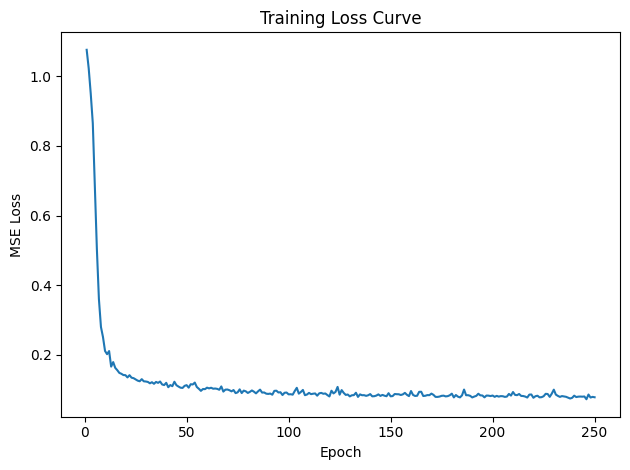

Fold 7 Training R²: 0.9345, Pearson r: 0.9670


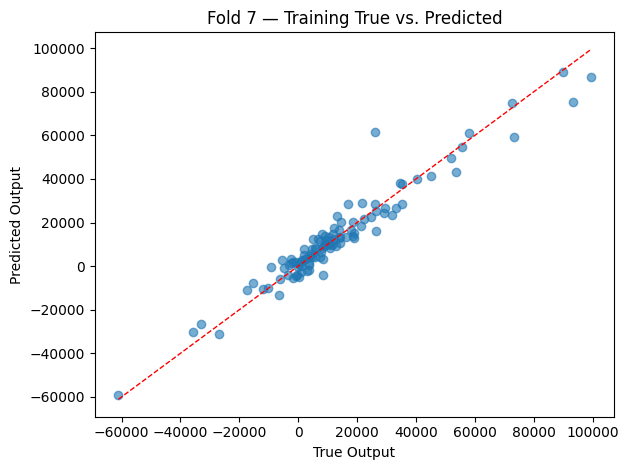

Fold 7 Validation MSE (norm): 0.2477
Fold 7 Validation R²: 0.4096, Pearson r: 0.7353


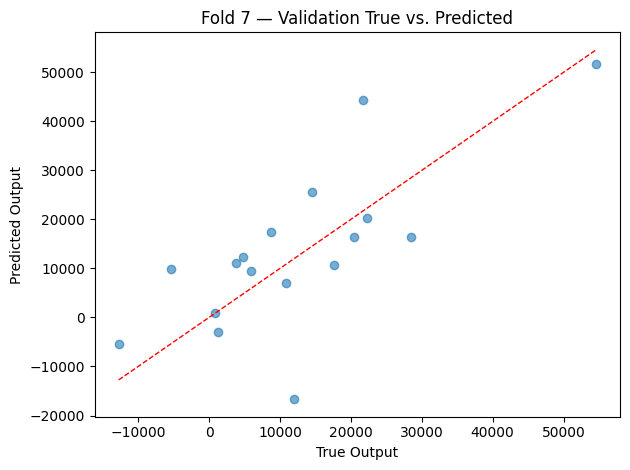


=== Validation MSE per fold ===
['0.1459', '0.1786', '0.3287', '1.1200', '0.2078', '1.1464', '0.2477']
Mean MSE (norm): 0.4822 ± 0.4153

=== Validation R² per fold ===
['0.2706', '0.8711', '0.5465', '0.4844', '0.7353', '-0.0727', '0.4096']
Mean R²: 0.4635 ± 0.2866

=== Validation Pearson r per fold ===
['0.7004', '0.9366', '0.9126', '0.7138', '0.9199', '0.4967', '0.7353']
Mean Pearson r: 0.7736 ± 0.1485


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [17]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [16,8,4],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [8,4] tanh


=== Fold 1/7 ===


Epoch   1/250  MSE=1.2865
Epoch  10/250  MSE=0.4000
Epoch  20/250  MSE=0.1732
Epoch  30/250  MSE=0.1366
Epoch  40/250  MSE=0.1037
Epoch  50/250  MSE=0.0840
Epoch  60/250  MSE=0.0608
Epoch  70/250  MSE=0.0461
Epoch  80/250  MSE=0.0402
Epoch  90/250  MSE=0.0321
Epoch 100/250  MSE=0.0314
Epoch 110/250  MSE=0.0314
Epoch 120/250  MSE=0.0225
Epoch 130/250  MSE=0.0219
Epoch 140/250  MSE=0.0184
Epoch 150/250  MSE=0.0181
Epoch 160/250  MSE=0.0135
Epoch 170/250  MSE=0.0116
Epoch 180/250  MSE=0.0131
Epoch 190/250  MSE=0.0125
Epoch 200/250  MSE=0.0143
Epoch 210/250  MSE=0.0080
Epoch 220/250  MSE=0.0074
Epoch 230/250  MSE=0.0098
Epoch 240/250  MSE=0.0090
Epoch 250/250  MSE=0.0073


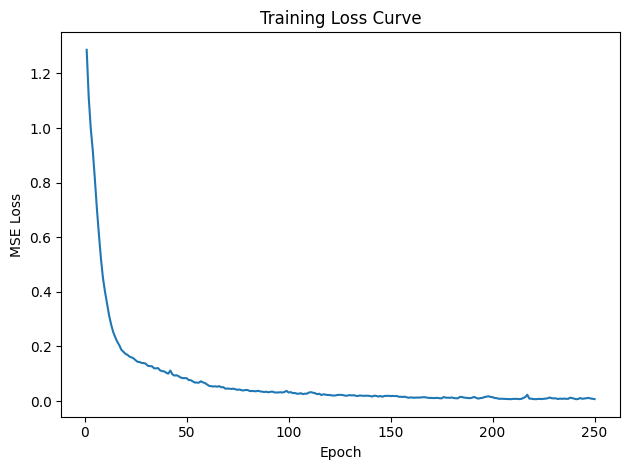

Fold 1 Training R²: 0.9923, Pearson r: 0.9978


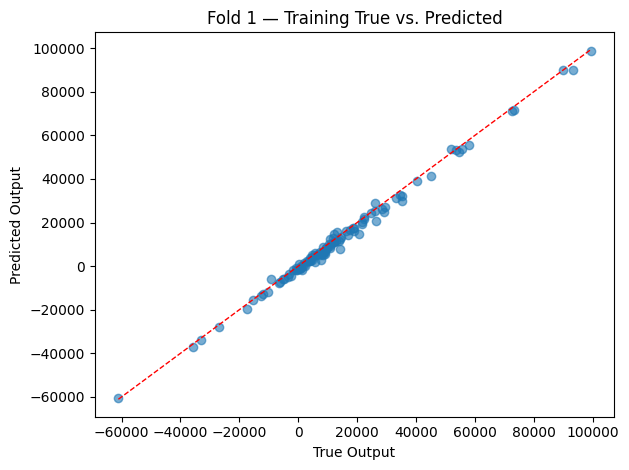

Fold 1 Validation MSE (norm): 0.2610
Fold 1 Validation R²: -0.3053, Pearson r: 0.6461


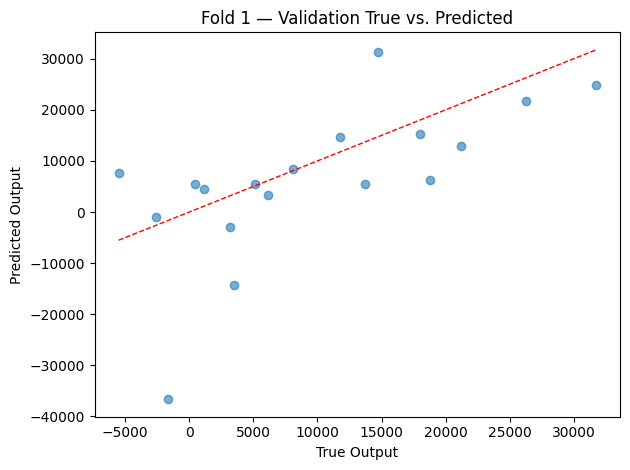


=== Fold 2/7 ===
Epoch   1/250  MSE=1.0099
Epoch  10/250  MSE=0.4701
Epoch  20/250  MSE=0.2111
Epoch  30/250  MSE=0.1623
Epoch  40/250  MSE=0.1340
Epoch  50/250  MSE=0.1099
Epoch  60/250  MSE=0.0813
Epoch  70/250  MSE=0.0688
Epoch  80/250  MSE=0.0487
Epoch  90/250  MSE=0.0410
Epoch 100/250  MSE=0.0335
Epoch 110/250  MSE=0.0271
Epoch 120/250  MSE=0.0233
Epoch 130/250  MSE=0.0216
Epoch 140/250  MSE=0.0236
Epoch 150/250  MSE=0.0197
Epoch 160/250  MSE=0.0158
Epoch 170/250  MSE=0.0173
Epoch 180/250  MSE=0.0133
Epoch 190/250  MSE=0.0120
Epoch 200/250  MSE=0.0104
Epoch 210/250  MSE=0.0092
Epoch 220/250  MSE=0.0088
Epoch 230/250  MSE=0.0134
Epoch 240/250  MSE=0.0087
Epoch 250/250  MSE=0.0098


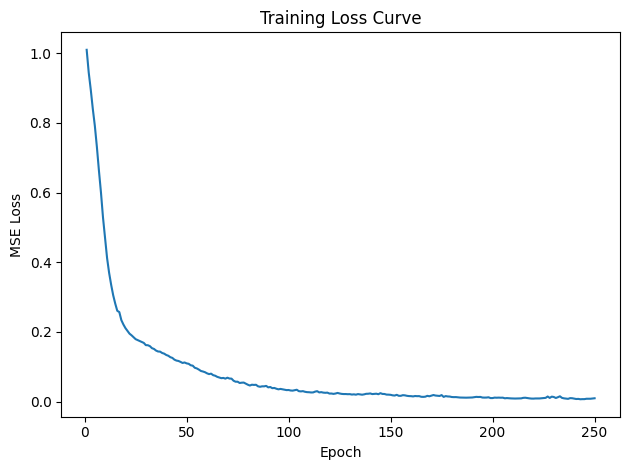

Fold 2 Training R²: 0.9911, Pearson r: 0.9959


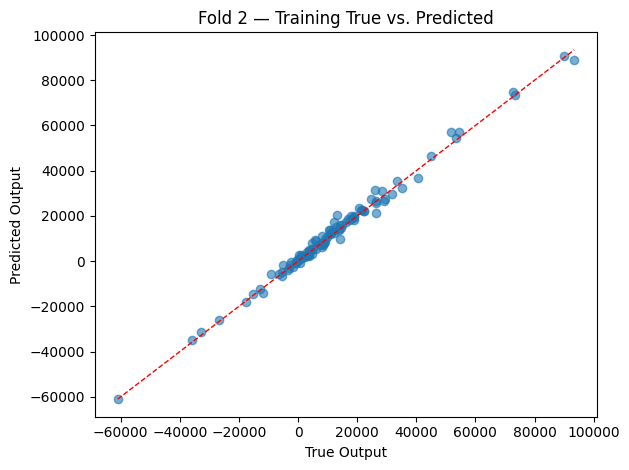

Fold 2 Validation MSE (norm): 0.4008
Fold 2 Validation R²: 0.7106, Pearson r: 0.8587


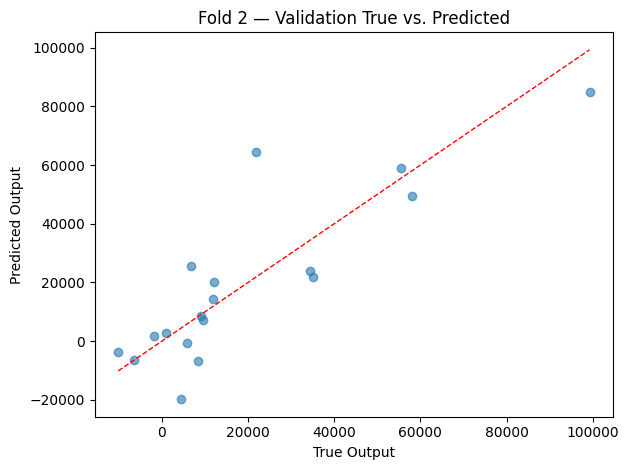


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0916
Epoch  10/250  MSE=0.5154
Epoch  20/250  MSE=0.2324
Epoch  30/250  MSE=0.1642
Epoch  40/250  MSE=0.1136
Epoch  50/250  MSE=0.0721
Epoch  60/250  MSE=0.0508
Epoch  70/250  MSE=0.0430
Epoch  80/250  MSE=0.0357
Epoch  90/250  MSE=0.0313
Epoch 100/250  MSE=0.0256
Epoch 110/250  MSE=0.0215
Epoch 120/250  MSE=0.0211
Epoch 130/250  MSE=0.0159
Epoch 140/250  MSE=0.0139
Epoch 150/250  MSE=0.0154
Epoch 160/250  MSE=0.0128
Epoch 170/250  MSE=0.0095
Epoch 180/250  MSE=0.0098
Epoch 190/250  MSE=0.0095
Epoch 200/250  MSE=0.0086
Epoch 210/250  MSE=0.0094
Epoch 220/250  MSE=0.0068
Epoch 230/250  MSE=0.0056
Epoch 240/250  MSE=0.0063
Epoch 250/250  MSE=0.0072


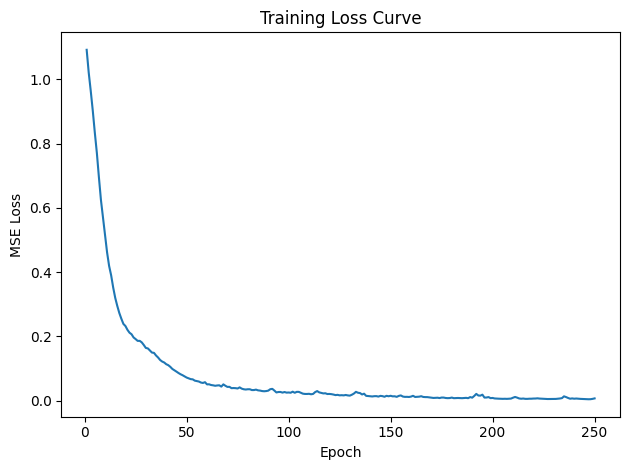

Fold 3 Training R²: 0.9941, Pearson r: 0.9971


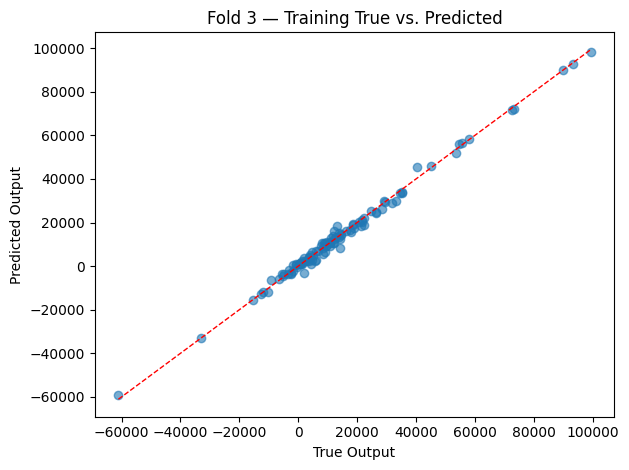

Fold 3 Validation MSE (norm): 0.3091
Fold 3 Validation R²: 0.5736, Pearson r: 0.9520


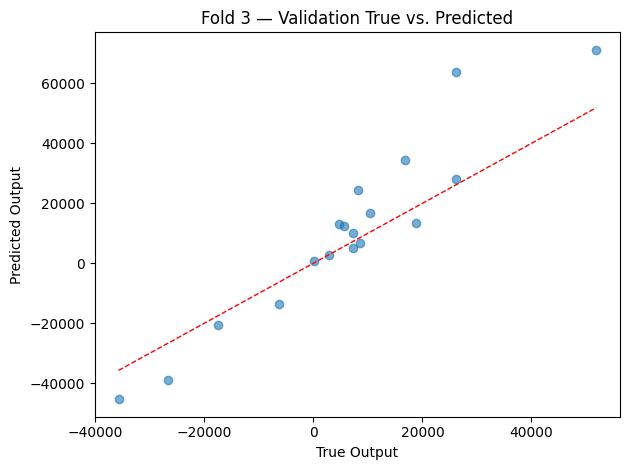


=== Fold 4/7 ===
Epoch   1/250  MSE=0.7857
Epoch  10/250  MSE=0.1741
Epoch  20/250  MSE=0.1091
Epoch  30/250  MSE=0.0856
Epoch  40/250  MSE=0.0665
Epoch  50/250  MSE=0.0508
Epoch  60/250  MSE=0.0397
Epoch  70/250  MSE=0.0337
Epoch  80/250  MSE=0.0308
Epoch  90/250  MSE=0.0264
Epoch 100/250  MSE=0.0241
Epoch 110/250  MSE=0.0213
Epoch 120/250  MSE=0.0199
Epoch 130/250  MSE=0.0172
Epoch 140/250  MSE=0.0164
Epoch 150/250  MSE=0.0145
Epoch 160/250  MSE=0.0147
Epoch 170/250  MSE=0.0115
Epoch 180/250  MSE=0.0108
Epoch 190/250  MSE=0.0107
Epoch 200/250  MSE=0.0105
Epoch 210/250  MSE=0.0082
Epoch 220/250  MSE=0.0077
Epoch 230/250  MSE=0.0068
Epoch 240/250  MSE=0.0081
Epoch 250/250  MSE=0.0080


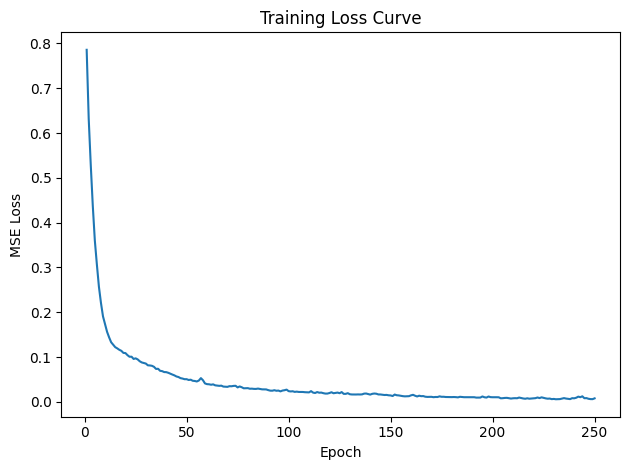

Fold 4 Training R²: 0.9922, Pearson r: 0.9968


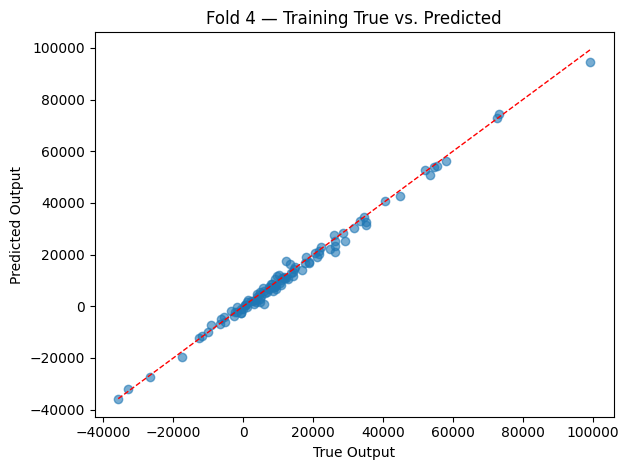

Fold 4 Validation MSE (norm): 1.7809
Fold 4 Validation R²: 0.1802, Pearson r: 0.4892


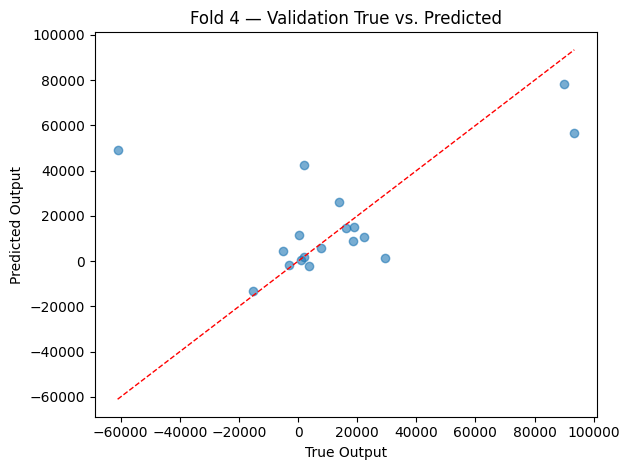


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0923
Epoch  10/250  MSE=0.3793
Epoch  20/250  MSE=0.1803
Epoch  30/250  MSE=0.1295
Epoch  40/250  MSE=0.1014
Epoch  50/250  MSE=0.0793
Epoch  60/250  MSE=0.0573
Epoch  70/250  MSE=0.0497
Epoch  80/250  MSE=0.0383
Epoch  90/250  MSE=0.0335
Epoch 100/250  MSE=0.0303
Epoch 110/250  MSE=0.0227
Epoch 120/250  MSE=0.0197
Epoch 130/250  MSE=0.0182
Epoch 140/250  MSE=0.0165
Epoch 150/250  MSE=0.0148
Epoch 160/250  MSE=0.0121
Epoch 170/250  MSE=0.0110
Epoch 180/250  MSE=0.0117
Epoch 190/250  MSE=0.0128
Epoch 200/250  MSE=0.0082
Epoch 210/250  MSE=0.0104
Epoch 220/250  MSE=0.0082
Epoch 230/250  MSE=0.0079
Epoch 240/250  MSE=0.0074
Epoch 250/250  MSE=0.0061


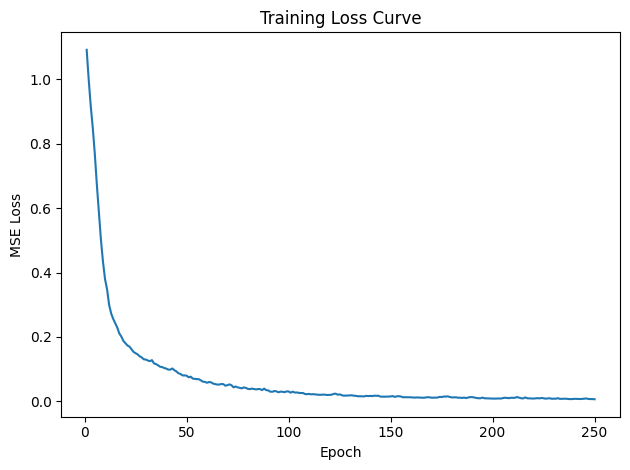

Fold 5 Training R²: 0.9934, Pearson r: 0.9972


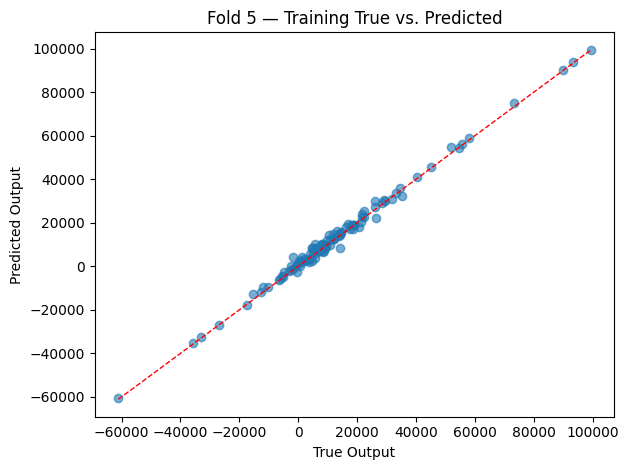

Fold 5 Validation MSE (norm): 0.6039
Fold 5 Validation R²: 0.2308, Pearson r: 0.8552


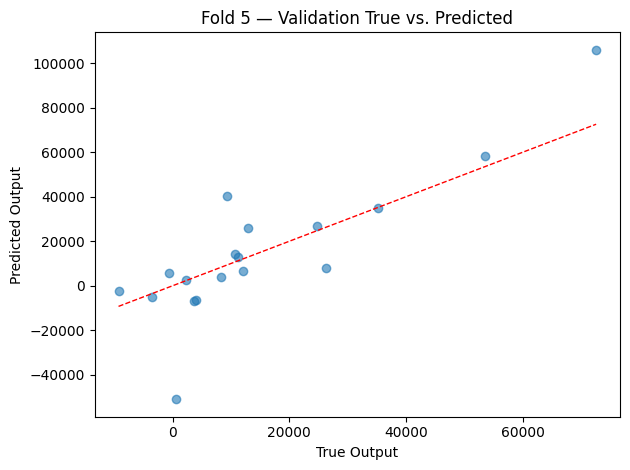


=== Fold 6/7 ===
Epoch   1/250  MSE=0.9566
Epoch  10/250  MSE=0.3891
Epoch  20/250  MSE=0.1838
Epoch  30/250  MSE=0.1238
Epoch  40/250  MSE=0.0932
Epoch  50/250  MSE=0.0699
Epoch  60/250  MSE=0.0550
Epoch  70/250  MSE=0.0530
Epoch  80/250  MSE=0.0376
Epoch  90/250  MSE=0.0340
Epoch 100/250  MSE=0.0283
Epoch 110/250  MSE=0.0219
Epoch 120/250  MSE=0.0189
Epoch 130/250  MSE=0.0165
Epoch 140/250  MSE=0.0159
Epoch 150/250  MSE=0.0123
Epoch 160/250  MSE=0.0101
Epoch 170/250  MSE=0.0130
Epoch 180/250  MSE=0.0103
Epoch 190/250  MSE=0.0071
Epoch 200/250  MSE=0.0058
Epoch 210/250  MSE=0.0087
Epoch 220/250  MSE=0.0060
Epoch 230/250  MSE=0.0048
Epoch 240/250  MSE=0.0043
Epoch 250/250  MSE=0.0051


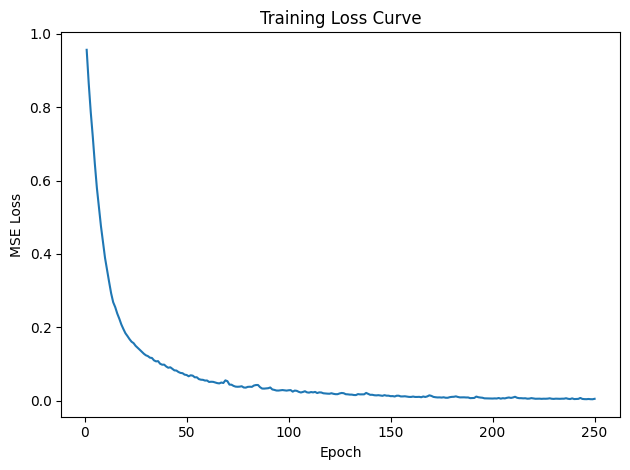

Fold 6 Training R²: 0.9948, Pearson r: 0.9984


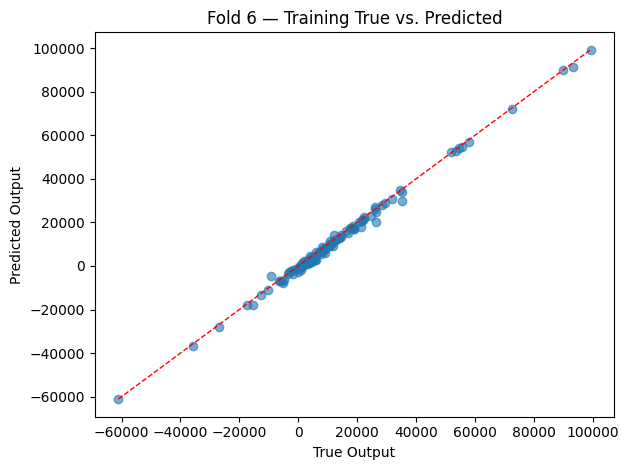

Fold 6 Validation MSE (norm): 1.3355
Fold 6 Validation R²: -0.2496, Pearson r: 0.5238


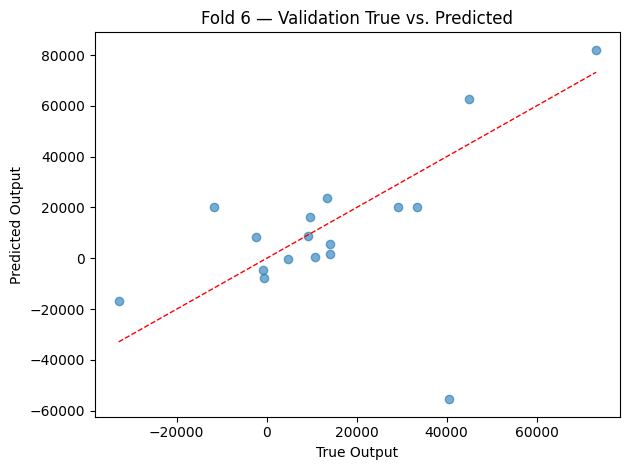


=== Fold 7/7 ===
Epoch   1/250  MSE=1.0854
Epoch  10/250  MSE=0.4310
Epoch  20/250  MSE=0.2197
Epoch  30/250  MSE=0.1357
Epoch  40/250  MSE=0.0947
Epoch  50/250  MSE=0.0708
Epoch  60/250  MSE=0.0586
Epoch  70/250  MSE=0.0466
Epoch  80/250  MSE=0.0402
Epoch  90/250  MSE=0.0336
Epoch 100/250  MSE=0.0321
Epoch 110/250  MSE=0.0296
Epoch 120/250  MSE=0.0272
Epoch 130/250  MSE=0.0280
Epoch 140/250  MSE=0.0220
Epoch 150/250  MSE=0.0191
Epoch 160/250  MSE=0.0181
Epoch 170/250  MSE=0.0171
Epoch 180/250  MSE=0.0157
Epoch 190/250  MSE=0.0139
Epoch 200/250  MSE=0.0138
Epoch 210/250  MSE=0.0547
Epoch 220/250  MSE=0.0121
Epoch 230/250  MSE=0.0113
Epoch 240/250  MSE=0.0109
Epoch 250/250  MSE=0.0102


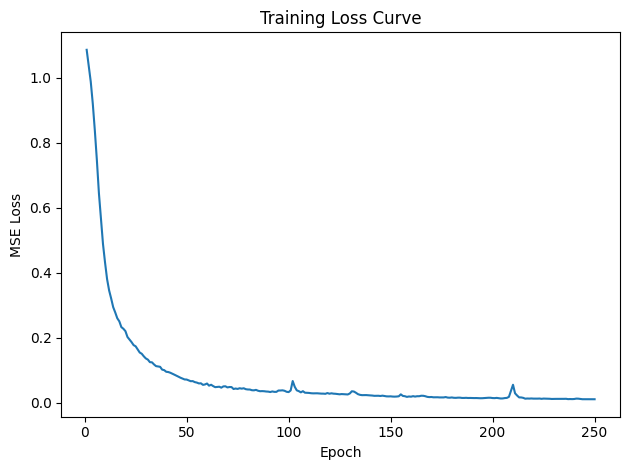

Fold 7 Training R²: 0.9913, Pearson r: 0.9957


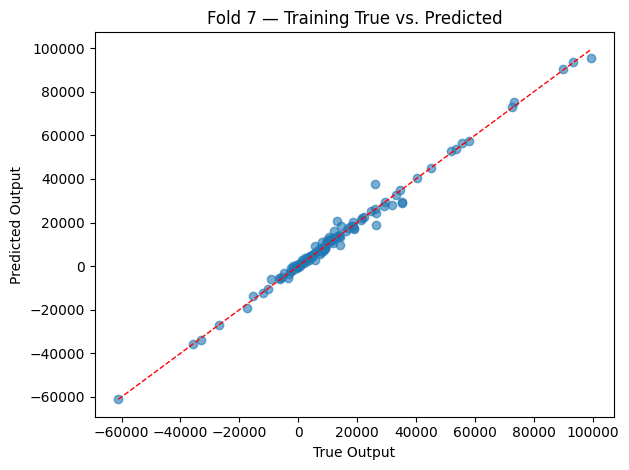

Fold 7 Validation MSE (norm): 0.0861
Fold 7 Validation R²: 0.7949, Pearson r: 0.9002


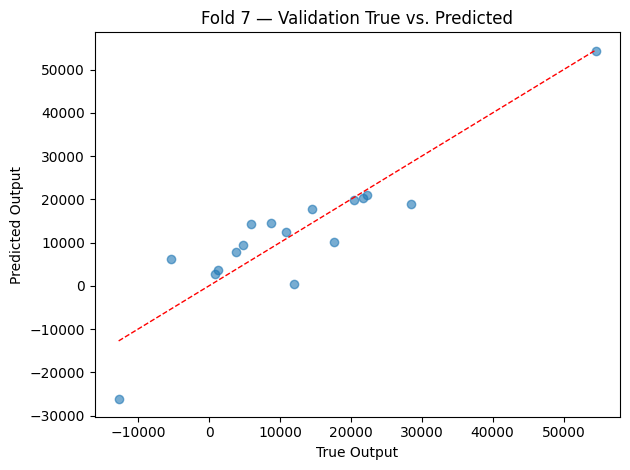


=== Validation MSE per fold ===
['0.2610', '0.4008', '0.3091', '1.7809', '0.6039', '1.3355', '0.0861']
Mean MSE (norm): 0.6825 ± 0.5845

=== Validation R² per fold ===
['-0.3053', '0.7106', '0.5736', '0.1802', '0.2308', '-0.2496', '0.7949']
Mean R²: 0.2765 ± 0.4092

=== Validation Pearson r per fold ===
['0.6461', '0.8587', '0.9520', '0.4892', '0.8552', '0.5238', '0.9002']
Mean Pearson r: 0.7465 ± 0.1757


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [18]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [8,4],
    'activation':  'Tanh',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# singel run to save  [3, 3] ReLU

Epoch   1/250  MSE=1.0568


Epoch  10/250  MSE=0.8745
Epoch  20/250  MSE=0.6613
Epoch  30/250  MSE=0.5181
Epoch  40/250  MSE=0.4215
Epoch  50/250  MSE=0.3565
Epoch  60/250  MSE=0.3094
Epoch  70/250  MSE=0.2702
Epoch  80/250  MSE=0.2363
Epoch  90/250  MSE=0.2119
Epoch 100/250  MSE=0.1886
Epoch 110/250  MSE=0.1711
Epoch 120/250  MSE=0.1569
Epoch 130/250  MSE=0.1457
Epoch 140/250  MSE=0.1330
Epoch 150/250  MSE=0.1239
Epoch 160/250  MSE=0.1205
Epoch 170/250  MSE=0.1078
Epoch 180/250  MSE=0.0998
Epoch 190/250  MSE=0.0903
Epoch 200/250  MSE=0.0848
Epoch 210/250  MSE=0.0810
Epoch 220/250  MSE=0.0776
Epoch 230/250  MSE=0.0687
Epoch 240/250  MSE=0.0653
Epoch 250/250  MSE=0.0606


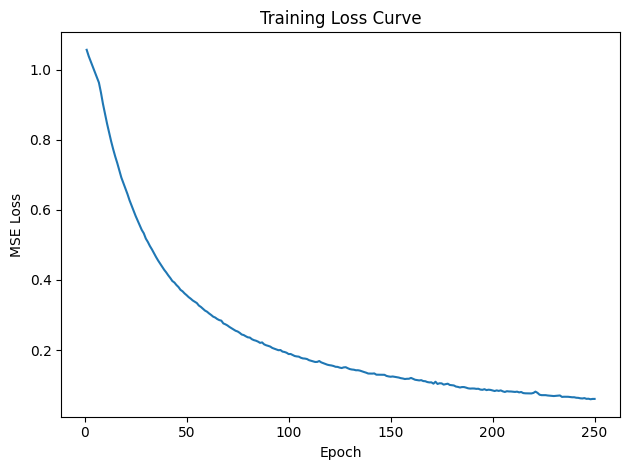

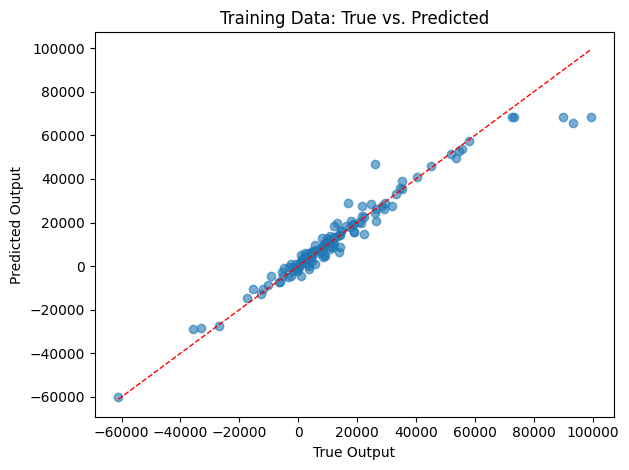

Saved model to:  trained_model_f6b61112.pt
Saved params to: trained_model_f6b61112_params.txt


In [19]:
import uuid
import torch
from Plot_helper import plot_train_scatter

# 1) Generate a random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Train your model
model, losses = train_nn(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size']
)

# 4) Plot true vs. predicted
plot_train_scatter(model, X, y, scaler_y=scaler_y, device='cpu')

# 5) Construct filenames with tag
model_fp  = f"trained_model_{tag}.pt"
params_fp = f"trained_model_{tag}_params.txt"

# 6) Save the model weights
torch.save(model.state_dict(), model_fp)

# 7) Save the hyper-parameters
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")

print(f"Saved model to:  {model_fp}")
print(f"Saved params to: {params_fp}")


# [8,8] Relu

Epoch   1/250  MSE=2.7543
Epoch  10/250  MSE=1.2680
Epoch  20/250  MSE=1.0410
Epoch  30/250  MSE=0.9436
Epoch  40/250  MSE=0.6987
Epoch  50/250  MSE=0.3842
Epoch  60/250  MSE=0.3091
Epoch  70/250  MSE=0.2679
Epoch  80/250  MSE=0.2338
Epoch  90/250  MSE=0.2084
Epoch 100/250  MSE=0.1871
Epoch 110/250  MSE=0.1718
Epoch 120/250  MSE=0.1586
Epoch 130/250  MSE=0.1453
Epoch 140/250  MSE=0.1355
Epoch 150/250  MSE=0.1278
Epoch 160/250  MSE=0.1201
Epoch 170/250  MSE=0.1142
Epoch 180/250  MSE=0.1083
Epoch 190/250  MSE=0.1035
Epoch 200/250  MSE=0.0999
Epoch 210/250  MSE=0.0954
Epoch 220/250  MSE=0.0921
Epoch 230/250  MSE=0.0888
Epoch 240/250  MSE=0.0863
Epoch 250/250  MSE=0.0821


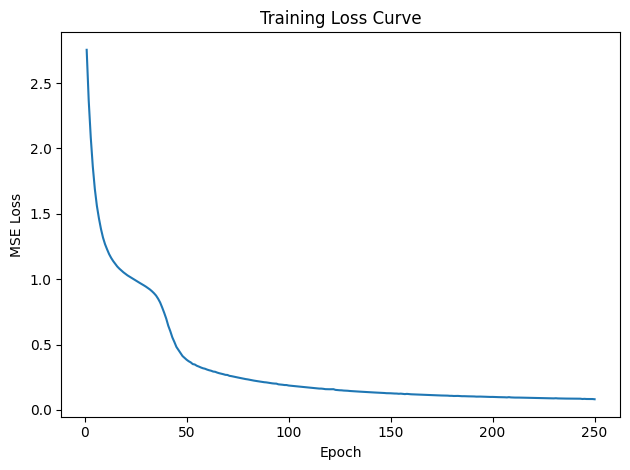

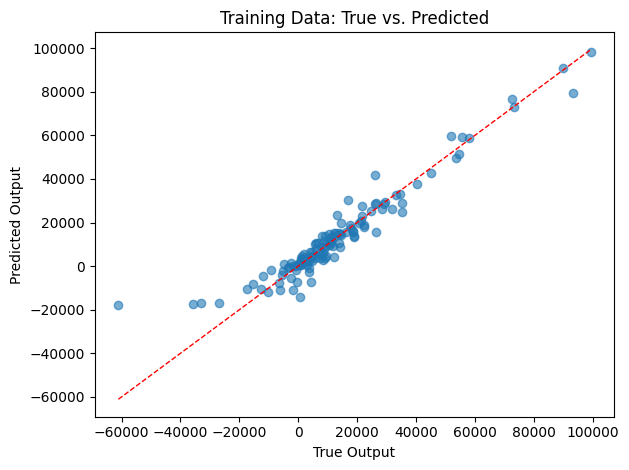

Saved model to:  trained_model_e700aeff.pt
Saved params to: trained_model_e700aeff_params.txt


In [20]:
import uuid
import torch
from Plot_helper import plot_train_scatter

# 1) Generate a random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [2, 2],
    'activation':  'Softplus',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Train your model
model, losses = train_nn(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size']
)

# 4) Plot true vs. predicted
plot_train_scatter(model, X, y, scaler_y=scaler_y, device='cpu')

# 5) Construct filenames with tag
model_fp  = f"trained_model_{tag}.pt"
params_fp = f"trained_model_{tag}_params.txt"

# 6) Save the model weights
torch.save(model.state_dict(), model_fp)

# 7) Save the hyper-parameters
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")

print(f"Saved model to:  {model_fp}")
print(f"Saved params to: {params_fp}")
